In [2]:
import numpy as np
import scipy as sp
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import heapq
from itertools import product
from functools import partial
import logging
import sympy as sym
smx,smy,smz=sym.symbols('x y z')

In [ ]:
def isoparametric2d(coords):
    local=[(-1.,-1.,),(1.,-1.),(1.,1.),(-1.,1.)]
    #print(coords)
    dNjdri=np.zeros((4,2,4))
    dXjdri=np.zeros((4,2,4))
    for ind,rs in enumerate(local):
        dNjdri[ind,:,:]=np.dstack([(local[i][0]*(1+local[i][1]*rs[1]),local[i][1]*(1+local[i][0]*rs[0])) for i in range(4)])/4
        #dXjdri(:,:,ind)=dNjdri(ind,:,:)@coords
    return dNjdri

def mesh_derivate(X,Y):
    m,n=np.shape(X)
    #print(m,n)
    dNjdxi=np.zeros((m-1,n-1,4,2,4))
    weights=np.zeros((m-1,n-1,4))
    for i in range(m-1):
        for j in range(n-1):
            nodes=((i,j),(i,j+1),(i+1,j+1),(i+1,j))
            coords=[(X[k,l],Y[k,l]) for (k,l) in nodes]
            dNjdris=isoparametric2d(coords)
            Js=dNjdris@np.array(coords)
            for k in range(4):
                ni,nj=nodes[k]
                J=Js[k,:,:]
                dNjdxi[i,j,k,:,:]=np.linalg.inv(J)@(dNjdris[k,:,:])
                weights[i,j,k]=1./np.linalg.det(J)
    return dNjdxi,weights

def grad(X,Y,Z,mesh_der=None):
    M,N=np.shape(X)
    der,wgh=np.zeros((2,M,N)),np.zeros((M,N))
    
    dNjdxis,weights=mesh_derivate(xx,yy) if mesh_der is None else mesh_der
        
    for i in range(M-1):
        for j in range(N-1):
            nodes=((i,j),(i,j+1),(i+1,j+1),(i+1,j))
            fs=[Z[k,l] for k,l in nodes]
            for k in range(4):
                ni,nj=nodes[k]
                dNjdxi=dNjdxis[i,j,k,:,:]
                w=weights[i,j,k]
                der[:,ni,nj]+=w*(dNjdxi@fs)
                wgh[ni,nj]+=w
    der=der/wgh
    return der,wgh

### 验证grad 

## uniform spacing
Nx,Ny=101,101
xs,ys=np.linspace(-1,1,Nx),np.linspace(-1,1,Ny)
xx,yy=np.meshgrid(xs,ys)
zz=np.exp(xx**2+yy**2)
fx,fy=2*zz*xx,2*zz*yy
meshder=mesh_derivate(xx,yy)
der,wgh=grad(xx,yy,zz,mesh_der=meshder)

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.contourf(xx,yy,fx)
plt.colorbar()
plt.subplot(1,2,2)
plt.contourf(xx,yy,der[0,:,:])
plt.colorbar()

1. Barth T J, Sethian J A. Numerical schemes for the Hamilton–Jacobi and level set equations on triangulated domains[J]. Journal of Computational Physics, 1998, 145(1): 1-40.

### Level Set update Algorithm

In [5]:
logger=logging.getLogger("LevelSet")
logger.handlers.clear()
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
ch.setFormatter(logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s'))
logger.addHandler(ch)

In [6]:
class GridHex:
    """
    >>> GridHex(np.linspce(0,1,11)) # for 1D
    >>> GridHex(np.linspce(0,1,11),np.linspce(0,1,21)) # for 2D
    >>> GridHex(np.linspce(0,1,11),np.linspce(0,1,21),np.linspce(0,1,31)) #for 3D
    """
    def __init__(self,*seeds,chs=2): 
        self.ndim=len(seeds)
        self.shape=tuple(len(seeds[axis]) for axis in range(self.ndim))
        self.seeds=[seeds[axis] for axis in range(self.ndim)]
        
        self.XYZs=np.meshgrid(*seeds,indexing='ij') # little different to meshgrid
        self.X,self.Y,self.Z=[self.XYZs[i] if self.ndim>i else None for i in range(3)]
        self.xs,self.ys,self.zs=[seeds[i] if self.ndim>i else None for i in range(3)]
        
        self.chs=chs
        self.funcs={
            0: self.upwindENO2,
            1: self.upwind,
            2: self.upwindENO2,
            3: self.upwindENO3,
        }

    def mesh_derivate(self):
        X,Y=self.X,self.Y
        m,n=np.shape(X)
        #print(m,n)
        dNjdxi=np.zeros((m-1,n-1,4,2,4))
        weights=np.zeros((m-1,n-1,4))
        for i in range(m-1):
            for j in range(n-1):
                nodes=((i,j),(i,j+1),(i+1,j+1),(i+1,j))
                coords=[(X[k,l],Y[k,l]) for (k,l) in nodes]
                dNjdris=isoparametric2d(coords)
                Js=dNjdris@np.array(coords)
                for k in range(4):
                    ni,nj=nodes[k]
                    J=Js[k,:,:]
                    dNjdxi[i,j,k,:,:]=np.linalg.inv(J)@(dNjdris[k,:,:])
                    weights[i,j,k]=1./np.linalg.det(J)
        return dNjdxi,weights
        
    def grad(self,Z):
        xs,ys=self.xs,self.ys
        fy,fx=np.gradient(Z,ys,xs)
        return np.array([fx,fy])
    
    def grad1(self,Z,mesh_der=None):
        """
        与np.gradient性能有较大差距，但是结果与其类似，不建议使用
        """
        X,Y=self.X,self.Y
        M,N=np.shape(X)
        der,wgh=np.zeros((2,M,N)),np.zeros((M,N))

        dNjdxis,weights=mesh_derivate(xx,yy) if mesh_der is None else mesh_der

        for i in range(M-1):
            for j in range(N-1):
                nodes=((i,j),(i,j+1),(i+1,j+1),(i+1,j))
                fs=[Z[k,l] for k,l in nodes]
                for k in range(4):
                    ni,nj=nodes[k]
                    dNjdxi=dNjdxis[i,j,k,:,:]
                    w=weights[i,j,k]
                    der[:,ni,nj]+=w*(dNjdxi@fs)
                    wgh[ni,nj]+=w
        der=der/wgh
        return der,wgh
    
    def plot(self,Z,title=''):
        if self.ndim==1:
            plt.plot(self.X,Z)
        elif self.ndim==2:
            plt.contourf(self.X,self.Y,Z)
            plt.colorbar()
        elif self.ndim==3:
            raise NotImplementedError("Unsupport 3D plot Now! ")
            pass
        plt.title(title)
        return 
    
    def __call__(self,axis,Z):
        return self.funcs[self.chs](axis,Z)
        
    def upwind(self,axis,Z):
        """
        used in upwind scheme.
        At each grid point, define φx− as D−φ and φx+ as D+φ. 
        If u_i > 0, approximate φx with φ−x . 
        If u_i < 0, approximate φx with φ+x .
        """
        xys=self.seeds
        triml1=tuple((slice(None) if i!=axis else slice(1,None) for i in range(ndim)))
        trimr1=tuple((slice(None) if i!=axis else slice(0,-1) for i in range(ndim)))        
        extd=tuple((None if i!=axis else slice(None) for i in range(ndim)))
        
        gc=GhostCell(stencil=1)
        dxy1=gc.periodic(axis,np.diff(xys[axis])[extd])
        
        D0=gc.periodic(axis,Z)
        D1=np.diff(D0,axis=axis)/dxy1

        Dlft,Drht=D1[trimr1],D1[triml1]

        return Dlft,Drht
    
    def upwindENO2(self,axis,Z,subcellfix=False):
        """
        Give second order approximation for One-Sided Derivatives φx− and φx+ 
        there are two possible second order approximations to both the left and right, 
        and  chooses the least oscillatory one according to the 
        
        Refer to:
            1. Osher S, Fedkiw R, Piechor K. Level set methods and dynamic implicit surfaces[J]. Appl. Mech. Rev., 2004, 57(3): B15-B15.
                Chapter 3.3 Hamilton-Jacobi ENO
            2. Mitchell I M. A toolbox of level set methods[J]. UBC Department of Computer Science Technical Report TR-2007-11, 2007.
                upwindFirstENO2.m
                
        Parameters
        __________
        axis : the dimension axis index; 0 means axis 0 , 1 means axis 1
        Z   : function values matrix

        """
        xys,ndim=self.seeds,self.ndim
        
        triml1=tuple((slice(None) if i!=axis else slice(1,None) for i in range(ndim)))
        triml2=tuple((slice(None) if i!=axis else slice(2,None) for i in range(ndim)))
        trimr1=tuple((slice(None) if i!=axis else slice(0,-1) for i in range(ndim)))
        trimr2=tuple((slice(None) if i!=axis else slice(0,-2) for i in range(ndim)))
        trimlr1=tuple((slice(None) if i!=axis else slice(1,-1) for i in range(ndim)))
        extd=tuple((None if i!=axis else slice(None) for i in range(ndim)))
        
        gc2=GhostCell(stencil=2)
        dxy1=gc2.zeroOrderExtrapolation(axis,np.diff(xys[axis])[extd])
        D0=gc2.zeroOrderExtrapolation(axis,Z)#gc2.periodic(axis,Z)
        D1=np.diff(D0,axis=axis)/dxy1
        D2=(D1[triml1]-D1[trimr1])/(dxy1[triml1]+dxy1[trimr1]) # N+2
        
        D1,dxy1=D1[trimlr1],dxy1[trimlr1] # N+1
        D2abs=np.abs(D2) 
        
        # when using second order Newton polynomial interpolation
        #  φ− can be defined from two cases : (i-2,i-1,i) or (i-1,i,i+1)
        #  φ+ can be defined from two cases : (i-1,i,i+1) or (i,i+1,i+2)
        #  According to Ref.1, Choose the one with smaller absolute value which can avoid interpolating near large variations such as discontinuities or steep gradients
        Dlft=D1[trimr1]+dxy1[trimr1]*np.where(D2abs[trimr2]<D2abs[trimlr1],D2[trimr2],D2[trimlr1])
        Drht=D1[triml1]-dxy1[triml1]*np.where(D2abs[trimlr1]<D2abs[triml2],D2[trimlr1],D2[triml2])
        return Dlft,Drht
    
    def upwindENO3(self,axis,Z):
        raise NotImplementedError('Uowind ENO 3 not implemented error!')
    
    def finite_difference(self,axis,Z,index):
        """
        return the first order and second order finite difference of the index of `Z` in the direction of `axis`
        """
        pass
    def coord(self,ptindex):
        return [seed[ind] for seed,ind in zip(self.seeds,ptindex)]
    
class GhostCell:
    """
    Chapter 7 Boundary Conditions and Ghost Cells from 
        LeVeque R J. Finite volume methods for hyperbolic problems[M]. Cambridge university press, 2002.
        
        https://github.com/clawpack/classic/blob/master/src/1d/bc1.f
    >>> X=np.np.linspace(0,23,24).reshape((2,3,4))
    >>> GhostCell(2).zeroOrderExtrapolation(1,X)
    """
    def __init__(self,stencil=1,scale=1.0):
        self.stencil=stencil
        self.scale=scale
        
    def periodic(self,axis,X):
        stencil=self.stencil
        slc1=tuple(slice(None) if i!=axis else slice(-stencil,None) for i in range(X.ndim))
        slc2=tuple(slice(None) if i!=axis else slice(stencil) for i in range(X.ndim))
        return np.concatenate((X[slc1]*self.scale,X,X[slc2]*self.scale),axis=axis)
    
    def zeroOrderExtrapolation(self,axis,X):
        stencil=self.stencil
        slc1=tuple(slice(None) if i!=axis else slice(0,1) for i in range(X.ndim))
        slc2=tuple(slice(None) if i!=axis else slice(-1,None) for i in range(X.ndim))
        
        X0=np.repeat(X[slc1],stencil,axis=axis)*self.scale
        X1=np.repeat(X[slc2],stencil,axis=axis)*self.scale
        
        #print(X0.shape,X1.shape,X.shape)
        return np.concatenate((X0,X,X1),axis=axis)

## TVD Runge Kutta 法

In [7]:
class TVDRungeKutta:
    def __init__(self,ydot,Z0,dt,t0=0,verbose=1):
        self.dt=dt
        self.Z0=Z0
        self.t0=t0
        
        self.Z=Z0
        self.t=t0
        
        self.ydot=ydot
        
        self.verbose=verbose
        self.logger=logger
        
    def iterate(self,dt=None,t=None,Z=None,**kwargs):
        dt=dt if dt else self.dt
        t0=t if t else self.t
        Z0=Z if Z else self.Z
        t,Z,cflbound=self.TVDRungeKutta(t0,Z0,dt,**kwargs)
        
        self.logger.debug('TVD RungeKutta (order=%d) from %f -> %f (CFL step bound: %f)'%(kwargs.get('order',2),t0,t,cflbound))
        if((t-t0)>cflbound):
            self.logger.warning("Warning : dt=(%.3f) > CFL step bound (%.3f) "%(t-t0,cflbound))
        if(np.amax(Z-Z0)<=1e-6*np.amax(Z)):
            self.logger.info("increment very small!")
        
        self.t,self.Z=t,Z
        return self.t,self.Z
    
    def TVDRungeKutta(self,t0,y0,dt,order=2,auto=False,
                      scale=0.9,dtmin=None,dtmax=None):
        """
        refer to :
            Osher S, Shu C W. High-order essentially nonoscillatory schemes for Hamilton-Jacobi equations[J]. SIAM Journal on numerical analysis, 1991, 28(4): 907-922.
            Osher S, Fedkiw R, Piechor K. Level set methods and dynamic implicit surfaces[J]. Appl. Mech. Rev., 2004, 57(3): B15-B15.
                Chapter 3.5
        """
        if auto:
            scale=0.8 if scale is None else scale
            dtmin=1e-5 if dtmin is None else dtmin
            dtmax=1.0 if dtmax is None else dtmax

        RKCoeffs={
            2:[np.array([[1,0],
                         [0.5,0.5]]),
               np.array([[1,0],
                         [0,0.5]]),],
            3:[np.array([[1,0,0],
                         [0.75,0.25,0],
                         [1/3,0,2/3]]),
               np.array([[1,0,0],
                         [0,0.25,0],
                         [0,0,2/3]]),],
            4:[np.array([[1,0,0,0],
                         [0.5,0.5,0,0],
                         [1/9,2/9,2/3,0],
                         [0,1/3,1/3,1/3]]),
               np.array([[0.5,0,0,0],
                         [-0.25,0.5,0,0],
                         [-1/9,-1/3,1,0],
                         [0,1/6,0,1/6]]),],
        }
        
        t,ys,dys=t0,[y0,],[]
        alpha,beta=RKCoeffs[order]
        cflbound=np.infty
        for k in range(order):
            ydot,cflb1=self.ydot(t,ys[k])
            
            cflbound=min(cflbound,cflb1)
            if k==0 and auto:
                dt=cflbound*scale
                dt=max(dt,dtmin)
                dt=min(dt,dtmax)
            
            dys.append(dt*ydot)
            
            t,y=t+dt,np.zeros_like(y0)
            for l in range(k+1):
                y+=alpha[k,l]*ys[l]+beta[k,l]*dys[l]
            ys.append(y)
        
        return t0+dt,ys[-1],cflbound
    
    def ForwardEuler(self,t0,y0,dt):
        ydot,cflbound=self.ydot(t0,y0)
        if(dt>cflbound):
            print("Warning : dt=(%.3f) > CFL step bound (%.3f) "%(dt,cflbound))
        return t0+dt,y0+ydot*dt,cflbound
        
    def reset(self,t=None,Z=None):
        self.Z=self.Z0 if Z is None else Z
        self.t=self.t0 if t is None else t

class HamiltonJacobi:
    def __init__(self,grid,Z0,dt):
        self.grid=grid
        self.rk=TVDRungeKutta(self.ydot,Z0,dt)
    
    def ydot(self,t,Z):
        raise NotImplementedError("ydot(t,Z) not implemented yet!")
    
    def iterate(self,**kwargs):
        t,Z = self.rk.iterate(**kwargs)
        return t,Z
    
    def reset(self):
        self.rk.reset()
    
    def steadyState(self,t=None,Z=None,dt=None,tend=None,
                    order=None,nmax=1000,eps=1e-4,
                    auto=False,scale=0.9):
        """
            calculate the steady state of Hamilton-Jacobi Equation 
            until 
                maximum nmax loops 
                or
                norm of ||order not great than eps
        or 
            caculate the solution at t=tend
        
        """
        tend=tend if tend else np.infty
        i,t,Z=0,t if t else self.rk.t0,Z if Z else self.rk.Z0
        while i<nmax:
            i=i+1
            if t<tend:
                t0,Z0=t,Z
                t,Z=self.rk.iterate(dt=dt,auto=auto,scale=scale)
                if(t>tend):
                    self.rk.reset(t0,Z0)
                    t,Z=self.rk.iterate(dt=tend-t0)
                    break
                n1=np.linalg.norm(Z-Z0,ord=order)
                n2=np.linalg.norm(Z0,ord=order)
                logger.debug("t=%f dZ norm %f Z0 norm %f"%(t,n1,n2))                
                if np.abs(n1)<=eps*np.abs(n2):
                    break
            else:
                break
        return t,Z
        
    def plot(self,Z=None,title=None):
        grid=self.grid
        t=0
        if Z is None: 
            Z=self.rk.Z 
            t=self.rk.t
        if title is None: 
            title='t=%.3f\nmin=%.3f\nmax=%.3f'%(t,Z.min(),Z.max())
        grid.plot(Z,title)
        plt.axis('equal')
    
    def solution(self,dt,N,Nstep,NperRow=4,figw=4,**kwargs):
        NRow=np.ceil((N+1)/(Nstep*NperRow))
        fig=plt.figure(figsize=(NperRow*figw,NRow*figw))
        
        plt.subplot(NRow,NperRow,1)
        t,Z=self.rk.t0,self.rk.Z0
        self.plot()
        
        for i in range(N):
            t,Z=self.iterate(dt=dt,**kwargs)
            if i%Nstep==Nstep-1:
                plt.subplot(NRow,NperRow,i//Nstep+2)
                self.plot()
    
    @staticmethod
    def smearedSign(Z,sgnfactor):
        return Z/np.sqrt(Z**2+sgnfactor**2)
    
    @staticmethod
    def minabs(A,B):
        """
        (2007)Antoine du Chéné, Chohong Min, Frédéric Gibou. Second-Order Accurate Computation of Curvatures in a Level Set Framework Using Novel High-Order Reinitialization Schemes(2007)Antoine du Chéné, Chohong Min, Frédéric Gibou. Second-Order Accurate Computation of Curvatures in a Level Set Framework Using Novel High-Order Reinitialization Schemes
        >>> minabs(-1,-2),minabs(1,-2),minabs(-1,2),minabs(1,2)
        """
        mask=abs(A)<abs(B)
        return A*mask+B*np.logical_not(mask)
    
    @staticmethod
    def minmod(A,B):
        """
        (2007)Antoine du Chéné, Chohong Min, Frédéric Gibou. Second-Order Accurate Computation of Curvatures in a Level Set Framework Using Novel High-Order Reinitialization Schemes
        >>> minmod(np.linspace(0,1,11),-0.5),minmod(np.linspace(0,1,11),0.5)
        """
        mask1=(A*B)>0
        mask2=abs(A)>abs(B)
        return B*np.logical_and(mask1,mask2)+A*np.logical_and(mask1,np.logical_not(mask2))
        
class Reinitialization(HamiltonJacobi):
    """
    0. Mitchell I M. The flexible, extensible and efficient toolbox of level set methods[J]. Journal of Scientific Computing, 2008, 35(2-3): 300-329.
    
    1. Osher S, Fedkiw R, Piechor K. Level set methods and dynamic implicit surfaces[J]. Appl. Mech. Rev., 2004, 57(3): B15-B15.
        Chapter 7. Constructing Signed Distance Functions
    2. Min C. On reinitializing level set functions[J]. Journal of computational physics, 2010, 229(8): 2764-2772.
    
    3. du Chéné A, Min C, Gibou F. Second-order accurate computation of curvatures in a level set framework using novel high-order reinitialization schemes[J]. Journal of Scientific Computing, 2008, 35(2-3): 114-131.
    4. Russo G, Smereka P. A remark on computing distance functions[J]. Journal of computational physics, 2000, 163(1): 51-67.
        Subcell fix Method
    5. Osher S, Shu C W. High-order essentially nonoscillatory schemes for Hamilton–Jacobi equations[J]. SIAM Journal on numerical analysis, 1991, 28(4): 907-922.
        generalized  high order essentially non-oscillatory (ENO) schemes and algorithms of TVD Runge-Kutta type time discretizations 
        
    """
    def __init__(self,grid,Z0,dt,smooth=False,subcellfix=False):
        super().__init__(grid,Z0,dt)

        self.smooth=smooth
        self.subcellfix=subcellfix  # from ref 4,
        
        
    def ydot(self,t,Z,schme="Godunov"):
        """
        Spatial Discretization—Godunov Scheme
        The Godunov Scheme of numerical Hamiltonian
        
        Osher S, Shu C W. High-order essentially nonoscillatory schemes for Hamilton–Jacobi equations[J]. SIAM Journal on numerical analysis, 1991, 28(4): 907-922.
            Chapter 2. SCHEME CONSTRUCTION
        Osher S, Fedkiw R, Piechor K. Level set methods and dynamic implicit surfaces[J]. Appl. Mech. Rev., 2004, 57(3): B15-B15.
            Chapter 5.3.3 
                give the formulation of Godunov’s Scheme

        Min C. On reinitializing level set functions[J]. Journal of computational physics, 2010, 229(8): 2764-2772.
        du Chéné A, Min C, Gibou F. Second-order accurate computation of curvatures in a level set framework using novel high-order reinitialization schemes[J]. Journal of Scientific Computing, 2008, 35(2-3): 114-131.
            give the expression of Godunov Hamiltonian
        """
        grid=self.grid
        dL=max([ np.amin(np.diff(seed)) for seed in grid.seeds])
                
        S=self.smearedSign(Z,dL) if self.smooth else np.sign(Z) 
        mask=(S>0.)
        trimallleft1=tuple((slice(1,None) for axis in range(grid.ndim)))
        
        CFLbound=None
        Hg=np.zeros_like(S)
        for axis in range(grid.ndim):
            deriv_left,deriv_right=self.grid(axis,Z)
            vrightp,vrightn=np.maximum(deriv_right,0),-np.minimum(deriv_right,0)
            vleftp,vleftn=np.maximum(deriv_left,0),-np.minimum(deriv_left,0)
            #print(vrightn,vleftn.shape,vrightp.shape,vleftp.shape)
            vels=mask*np.maximum(vrightn,vleftp)+(~mask)*np.maximum(vrightp,vleftn)
            Hg+=vels**2
            
            extd=tuple((None if i!=axis else slice(None) for i in range(grid.ndim)))
            dx=np.diff(grid.seeds[axis])[extd]
            if CFLbound is None:
                CFLbound=np.abs(vels[trimallleft1]/dx)
            else:
                CFLbound+=np.abs(vels[trimallleft1]/dx)
        
        Hg=S*(1-np.sqrt(Hg))
        cflbound=1/np.amax(CFLbound)
        return Hg,1.0 if np.isinf(cflbound) else cflbound

class TransportEquation:
    def velocity(self,axis):
        """
        Give the velocity filed of the axis direction
        
        axis : 0,1,2 is x y z resepectively
        
        """
        raise NotImplementedError("velocity(axis) not implemented yet!")
    
    def ydot(self,t,Z,scheme="Godunov"):
        """
        return dy/dt  and CFL step bound of Transport Equation
        """
        grid=self.grid
        
        trimallleft1=tuple((slice(1,None) for axis in range(grid.ndim)))
        trimallright1=tuple((slice(-1) for axis in range(grid.ndim)))
        trimalllr1=tuple((slice(1,-1) for axis in range(grid.ndim)))
        
        CFLbound=None
        Hg=np.zeros_like(Z)
        for axis in range(grid.ndim):
            vel=self.velocity(axis)
            velp,veln=np.maximum(vel,0),np.minimum(vel,0)
            
            deriv_left,deriv_right=self.grid(axis,Z)            
            Hg-=velp*deriv_left+veln*deriv_right
            
            
            trimleft1=tuple((slice(1,None) if i==axis else slice(None) for i in range(grid.ndim)))
            trimright1=tuple((slice(-1) if i==axis else slice(None) for i in range(grid.ndim)))
            extd=      tuple((slice(None) if i==axis else None  for i in range(grid.ndim)))
            dx=np.diff(grid.seeds[axis])[extd]
            
            #print(dx.shape,extd,velp[trimalllr1].shape,dx[trimright1].shape,veln[trimalllr1].shape,dx[trimleft1].shape)
            X=np.abs(velp[trimalllr1]/dx[trimright1]+veln[trimalllr1]/dx[trimleft1])
            if CFLbound is None:
                CFLbound=X
            else:
                CFLbound+=X
        #print(t,np.amax(Hg))
        cflbound=1/np.amax(CFLbound)
        return Hg,1.0 if np.isinf(cflbound) else cflbound
        

class Reorthogonalization(TransportEquation,HamiltonJacobi):
    """
    1. (2001)Burchard P, Cheng L-T, Merriman B, Osher SJ. Motion of curves in three spatial dimensions using a level set approach. Journal of Computational Physics 2001; 170:720–741.
    2. (2002)Non-planar 3D crack growth by the extended 5nite element and level sets—Part II: Level set update
    3. (2006)A study of the representation of cracks with level sets
    
    solve the Hamilton-Jacobi Equation
    
    $$
    \frac{\partial y}{\partial t}+ {\rm sign}(z)\frac{\nabla z}{\mid \nabla z \mid}\dot \nabla y=0
    $$
    
    """
    def __init__(self,grid,Y0,Z0,dt,smooth=True):
        super().__init__(grid,Z0,dt)

        self.Y0=Y0
        self.smooth=smooth

        dL=min([ np.amin(np.diff(seed)) for seed in grid.seeds])
        S=self.smearedSign(Y0,dL) if smooth else np.sign(Z) 
        
        arr=np.gradient(Y0,*(grid.seeds)) if grid.ndim>1 else (np.gradient(Y0,grid.seeds[0]),)
        grad0=np.stack(arr,axis=0)
        self.normgrad0=S*grad0/np.linalg.norm(grad0,axis=0)[None,]
        self.normgrad0[np.isnan(self.normgrad0)]=0
    
    def velocity(self,axis):
        return self.normgrad0[axis]
    

class LevelSetAdvance(TransportEquation,HamiltonJacobi):
    """
    1. (2001) Gravouil A, Moës N, Belytschko T. Non-planar 3D crack growth by the extended finite element and level sets—Part II: Level set update[J]. International journal for numerical methods in engineering, 2002, 53(11): 2569-2586.
    2. (2006) Marc Duflot. A study of the representation of cracks with level sets
    
    As ref.2 saied,  Update of the Phi function with an advance scalar lead to the inaccuraccy,
    using an advance vector is the better way
    
    grid: grid 
    Z0  : init value
    V   : advance scalar field (must be adjusted to prevent modification of previous crack surface)
    dt  : default time increment
    """
    def __init__(self,grid,Z0,V0,dt):
        super().__init__(grid,Z0,dt)
        
        self.AV=np.stack([gX*V0 for gX in np.gradient(Z0,*(grid.seeds))],
                         axis=0)

    def velocity(self,axis):
        return self.AV[axis]
    
    def steadyState(self,**kwargs):
        kwargs['tend']=1.0
        return super().steadyState(**kwargs)
    
class VelocityExtension(TransportEquation,HamiltonJacobi):
    """
    (1997) Chen S, Merriman B, Osher S, Smereka P. A simple level set method for solving Stefan problems. Journal of Computational Physics 1997; 135:8–29.abs
    (1997) Hou TY, Li Z, Osher S, Zhao H. A hybrid method for moving interface problems with application to the Hele-Shaw Row. Journal of Computational Physics 1997; 134:236–252.    
    (2001) Gravouil A, Moës N, Belytschko T. Non-planar 3D crack growth by the extended finite element and level sets—Part II: Level set update[J]. International journal for numerical methods in engineering, 2002, 53(11): 2569-2586.
    
    """
    def __init__(self,grid,Phis,V0,dt,smooth=False,subcellfix=False):
        super().__init__(grid,V0,dt)
        
    def ydot(self,t,Z,schme="Godunov"):
        """
        """
        pass


In [8]:
class LevelSet:
    def __init__(self,grid,phi0,psi0,dt=0.01,eps=1e-3):
        self.grid=grid
        self.eps=eps
        self.dt=dt
        
        self.phi0=phi0
        self.phi=self.reinitialize(phi0,dt=dt,eps=self.eps).rk.Z
        
        self.psi0=psi0
        psi1=self.reorthogonalize(self.phi,psi0,dt=dt,eps=self.eps).rk.Z
        self.psi=self.reinitialize(psi1,dt=dt,eps=self.eps).rk.Z
        
    def reinitialize(self,Z0,dt=0.01,eps=1e-3):
        rit=Reinitialization(self.grid,Z0,dt)
        rit.steadyState(order=2,eps=eps,auto=True)
        return rit

    def reorthogonalize(self,Y0,Z0,dt=0.01,eps=1e-3):
        rot=Reorthogonalization(self.grid,Y0,Z0,dt)
        rot.steadyState(order=2,eps=eps,auto=True)
        return rot

    def advance(self,Z,V,dt=0.01):
        adv=LevelSetAdvance(self.grid,Z,V,dt)
        adv.steadyState(auto=True)
        return adv
    
    def extend(self,V0,phiOrpsi=0):
        if phiOrpsi==0:
            print(" extend v_phi")
            # extend v_phi
            rot1=self.reorthogonalize(self.phi,V0)
            rot1.steadyState(order=2,eps=1e-3,auto=True)
            
            rot2=self.reorthogonalize(self.psi,rot1.rk.Z)
            rot2.steadyState(order=2,eps=1e-3,auto=True)
        else:
            print(" extend v_psi")
            # extend v_psi
            rot1=self.reorthogonalize(self.psi,V0)
            rot1.steadyState(order=2,eps=1e-3,auto=True)
            rot2=self.reorthogonalize(self.phi,rot1.rk.Z)
            rot2.steadyState(order=2,eps=1e-3,auto=True)
        return rot2.rk.Z
    
    def plotCrack(self):
        pass
    
    def update(self,vphi0,vpsi0):
        print(" extend vphi and vpsi to the domain")
        # extend vphi and vpsi to the domain
        vphi=self.extend(vphi0,phiOrpsi=0)
        self.grid.plot(vphi)
        plt.show()
        
        vpsi=self.extend(vpsi0,phiOrpsi=1)
        self.grid.plot(vpsi)
        plt.show()
        print(" adjustment to prevent modi5cation of previous crack surface")
        # adjustment to prevent modi5cation of previous crack surface
        #vphi=vphi/vpsi*np.maximum(psi,0)
        #vphi[np.isnan(vphi)]=0.0
        
        print(" update the phi level set")
        # update the phi level set
        adv=self.advance(self.phi,vphi)
        self.phi=adv.rk.Z
        adv.plot()
        plt.show()
        
        print(" reinitialize the phi level set")
        # reinitialize the phi level set
        rit_phi=self.reinitialize(self.phi)
        self.phi=rit_phi.rk.Z
        rit_phi.plot()
        plt.show()
        
        print(" update the psi level set")
        # update the psi level set
        adv=self.advance(self.psi,vpsi)
        self.psi=adv.rk.Z
        adv.plot()
        plt.show()
        
        print(" orthogonalize the psi level set")
        # orthogonalize and reinitialize the level se
        rot=self.reorthogonalize(self.phi,self.psi)
        rot.plot()
        plt.show()
        
        self.grid.plot(rot.rk.Z)
        self.grid.plot(self.phi)
        plt.show()
        print(" reinitialize the psi level set")
        rit_psi=self.reinitialize(rot.rk.Z)
        self.psi=rit_psi.rk.Z
        rit_psi.plot()
        plt.show()
        
        return vphi,vpsi,self.phi,self.psi

In [7]:
Nx,Ny=51,51
grid=GridHex(np.linspace(-1,1,Nx),np.linspace(-1,1,Ny))
mask=(grid.X<=-0.1)
phi,psi=(grid.X+grid.Y+0.1)/np.sqrt(2)*mask+grid.Y*(~mask),grid.X

ch.setLevel(logging.INFO)
lv=LevelSet(grid,phi,psi)

<a list of 14 text.Text objects>

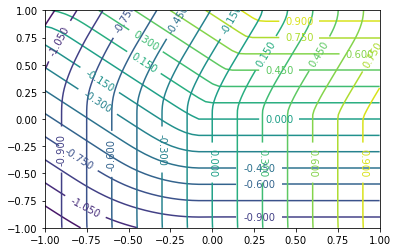

In [8]:
cs1=plt.contour(lv.grid.X,lv.grid.Y,lv.phi,20)
plt.clabel(cs1)
cs2=plt.contour(lv.grid.X,lv.grid.Y,lv.psi,20)
plt.clabel(cs2)

 extend vphi and vpsi to the domain
 extend v_phi


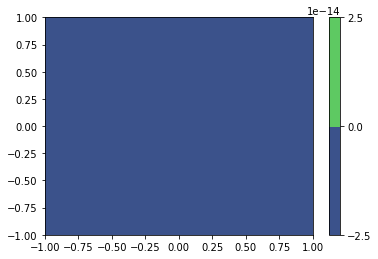

 extend v_psi


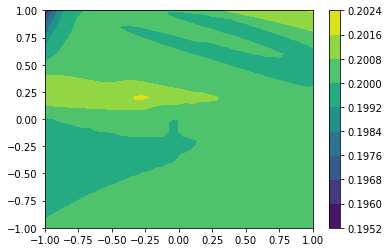

 adjustment to prevent modi5cation of previous crack surface
 update the phi level set


C:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:298: RuntimeWarning: divide by zero encountered in double_scalars


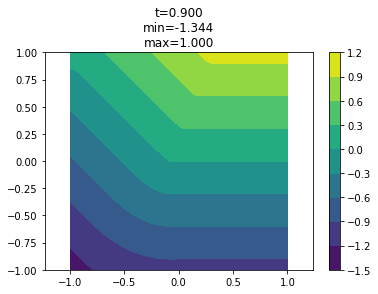

 reinitialize the phi level set


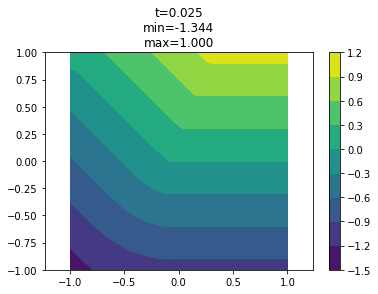

 update the psi level set


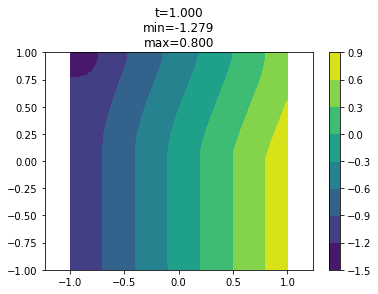

 orthogonalize the psi level set


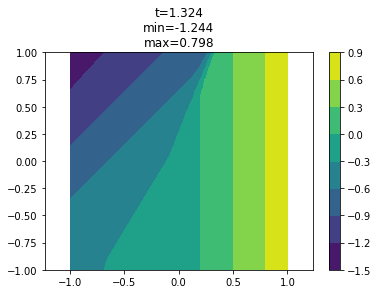

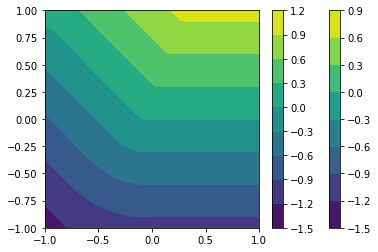

 reinitialize the psi level set


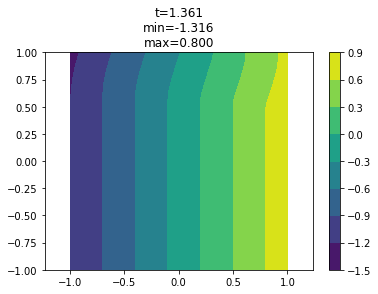

In [9]:
vphi=np.zeros_like(phi)
vpsi=0.2+lv.psi
vphi1,vpsi1,phi1,psi1=lv.update(vphi,vpsi)

<a list of 14 text.Text objects>

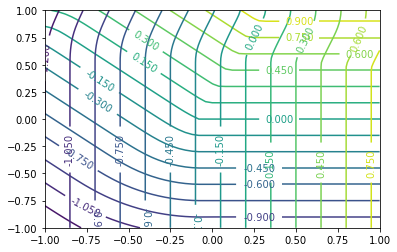

In [333]:
cs1=plt.contour(lv.grid.X,lv.grid.Y,lv.phi,20)
plt.clabel(cs1)
cs2=plt.contour(lv.grid.X,lv.grid.Y,lv.psi,20)
plt.clabel(cs2)

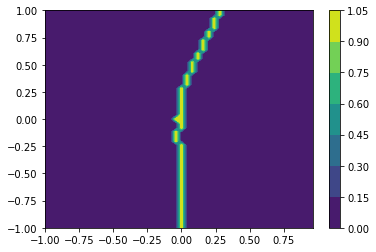

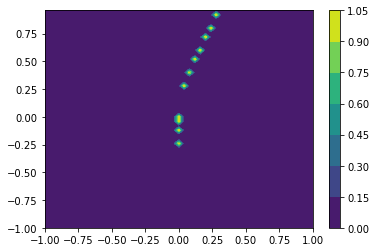

In [629]:
for i in range(lv.grid.ndim):
    triml1=tuple((slice(1,None) if j==i else slice(None) for j in range(lv.grid.ndim)))
    trimr1=tuple((slice(0,-1) if j==i else slice(None) for j in range(lv.grid.ndim)))
    plt.contourf(lv.grid.X[trimr1],lv.grid.Y[trimr1],lv.psi[triml1]*lv.psi[trimr1]<=0)
    plt.colorbar()
    plt.show()

(1.0014509730007175, -1.0)

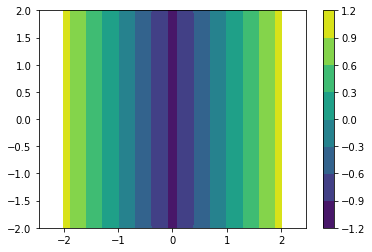

In [10]:
grid=GridHex(np.linspace(-2,2,51),np.linspace(-2,2,51))
ch.setLevel(logging.DEBUG)
lv_cir=LevelSet(grid,grid.Y,np.sqrt(grid.X**2+grid.Y**2)-1)

Z=lv_cir.psi
lv_cir.grid.plot(Z)
plt.axis('equal')
np.max(Z),np.min(Z)

 extend vphi and vpsi to the domain
 extend v_phi


C:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:326: RuntimeWarning: invalid value encountered in true_divide


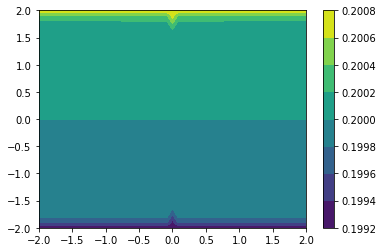

 extend v_psi


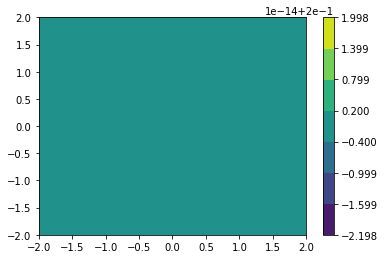

 adjustment to prevent modi5cation of previous crack surface
 update the phi level set


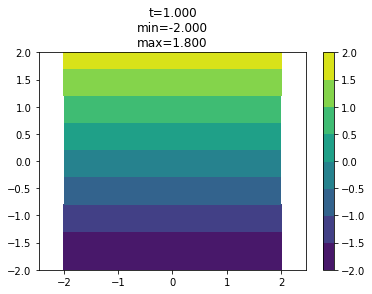

 reinitialize the phi level set


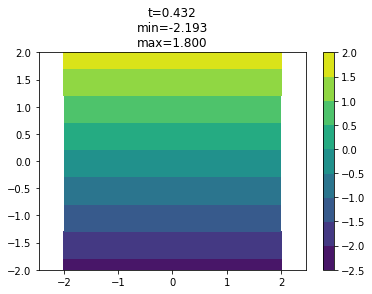

 update the psi level set


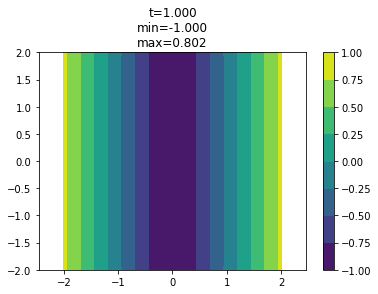

 orthogonalize the psi level set


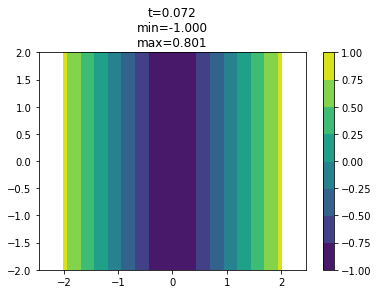

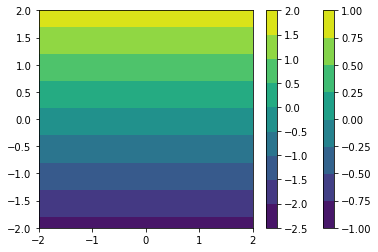

 reinitialize the psi level set


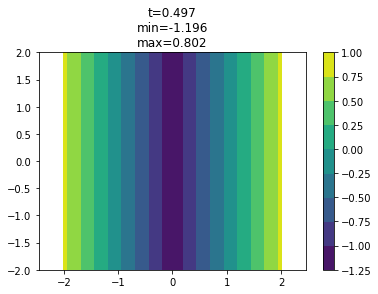

(array([[0.19922223, 0.1995752 , 0.1997449 , ..., 0.2002551 , 0.2004248 ,
         0.20077777],
        [0.19922249, 0.19957529, 0.19974494, ..., 0.20025506, 0.20042471,
         0.20077751],
        [0.19922277, 0.19957538, 0.19974498, ..., 0.20025502, 0.20042462,
         0.20077723],
        ...,
        [0.19922277, 0.19957538, 0.19974498, ..., 0.20025502, 0.20042462,
         0.20077723],
        [0.19922249, 0.19957529, 0.19974494, ..., 0.20025506, 0.20042471,
         0.20077751],
        [0.19922223, 0.1995752 , 0.1997449 , ..., 0.2002551 , 0.2004248 ,
         0.20077777]]), array([[0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
        [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
        [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
        ...,
        [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
        [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
        [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2]]), array([[-2.19332226, -2.11619823, -2.0393186 , ...,  1.63999189,
          1.71998549,  1.79997058],
        [-2.19332227, -2

In [11]:
vphi=lv_cir.phi+0.2
vpsi=np.zeros_like(vphi)+0.2
lv_cir.update(vphi,vpsi)

In [15]:
ch.level==logging.DEBUG

True

In [276]:
ch.setLevel(logging.INFO)

## 验证Reinitialization

### 1D 

2020-04-14 22:53:06,009 - LevelSet - WARNING - Warning : dt=(0.030) > CFL step bound (0.004) 
2020-04-14 22:53:06,012 - LevelSet - WARNING - Warning : dt=(0.030) > CFL step bound (0.007) 
2020-04-14 22:53:06,015 - LevelSet - WARNING - Warning : dt=(0.030) > CFL step bound (0.012) 
2020-04-14 22:53:06,017 - LevelSet - WARNING - Warning : dt=(0.030) > CFL step bound (0.021) 
2020-04-14 22:53:06,020 - LevelSet - WARNING - Warning : dt=(0.030) > CFL step bound (0.027) 


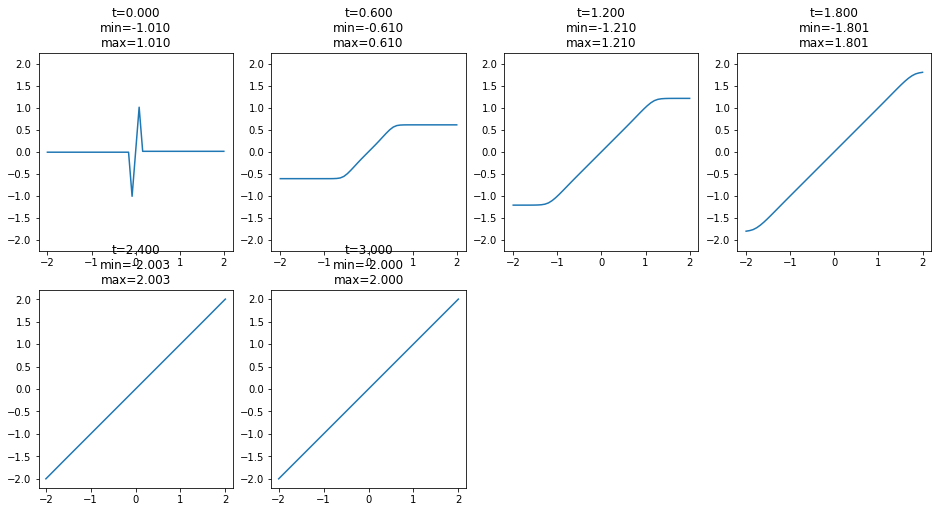

In [12]:
grid=GridHex(np.linspace(-2,2,51))
rit1=Reinitialization(grid,np.sign(grid.seeds[0])*(np.abs(grid.seeds[0])<0.1)+0.01*np.sign(grid.X),dt=0.002)

rit1.solution(0.03,100,20)
#t,Z=rit1.steadyState(auto=True,scale=0.7)
#rit1.plot()

2020-04-14 23:02:14,081 - LevelSet - WARNING - Warning : dt=(0.010) > CFL step bound (0.009) 
2020-04-14 23:02:14,083 - LevelSet - WARNING - Warning : dt=(0.010) > CFL step bound (0.009) 
2020-04-14 23:02:14,087 - LevelSet - WARNING - Warning : dt=(0.010) > CFL step bound (0.009) 
2020-04-14 23:02:14,092 - LevelSet - WARNING - Warning : dt=(0.010) > CFL step bound (0.009) 
2020-04-14 23:02:14,095 - LevelSet - WARNING - Warning : dt=(0.010) > CFL step bound (0.009) 
2020-04-14 23:02:14,097 - LevelSet - WARNING - Warning : dt=(0.010) > CFL step bound (0.009) 
2020-04-14 23:02:14,099 - LevelSet - WARNING - Warning : dt=(0.010) > CFL step bound (0.009) 
2020-04-14 23:02:14,101 - LevelSet - WARNING - Warning : dt=(0.010) > CFL step bound (0.009) 
2020-04-14 23:02:14,105 - LevelSet - WARNING - Warning : dt=(0.010) > CFL step bound (0.009) 
2020-04-14 23:02:14,108 - LevelSet - WARNING - Warning : dt=(0.010) > CFL step bound (0.009) 
2020-04-14 23:02:14,110 - LevelSet - WARNING - Warning : dt=

(1.5094590178816087, -0.7387658864967825)

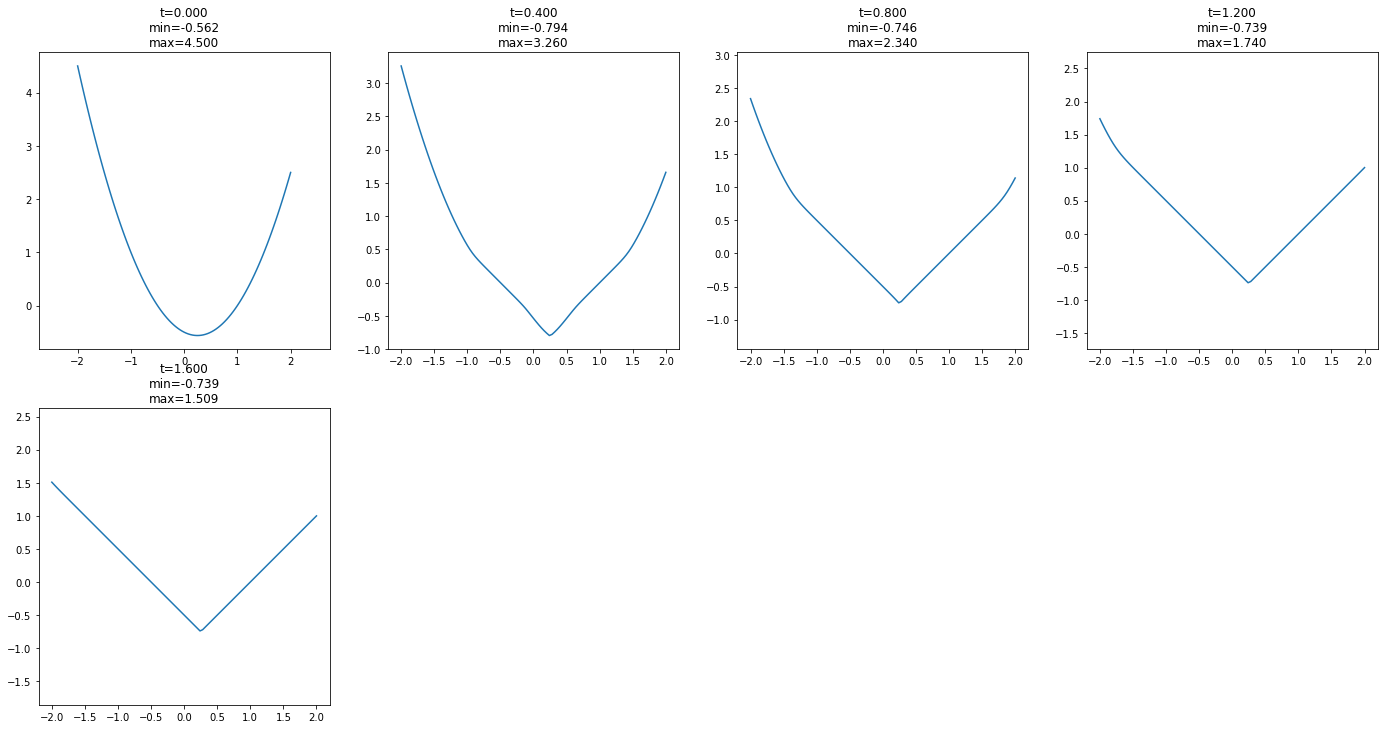

In [13]:
grid=GridHex(np.linspace(-2,2,101))
rit2=Reinitialization(grid,(grid.seeds[0]**2-0.5*grid.seeds[0]-0.5),dt=0.01)
#rit2.plot()

rit2.solution(0.01,160,40,figw=6)
#rit2.steadyState()
#rit2.plot()
np.max(rit2.rk.Z),np.min(rit2.rk.Z) 

2020-04-14 23:02:20,810 - LevelSet - WARNING - Warning : dt=(0.020) > CFL step bound (0.003) 
2020-04-14 23:02:20,813 - LevelSet - WARNING - Warning : dt=(0.020) > CFL step bound (0.003) 
2020-04-14 23:02:20,816 - LevelSet - WARNING - Warning : dt=(0.020) > CFL step bound (0.003) 
2020-04-14 23:02:20,819 - LevelSet - WARNING - Warning : dt=(0.020) > CFL step bound (0.003) 
2020-04-14 23:02:20,821 - LevelSet - WARNING - Warning : dt=(0.020) > CFL step bound (0.003) 
2020-04-14 23:02:20,824 - LevelSet - WARNING - Warning : dt=(0.020) > CFL step bound (0.003) 
2020-04-14 23:02:20,827 - LevelSet - WARNING - Warning : dt=(0.020) > CFL step bound (0.003) 
2020-04-14 23:02:20,829 - LevelSet - WARNING - Warning : dt=(0.020) > CFL step bound (0.004) 
2020-04-14 23:02:20,832 - LevelSet - WARNING - Warning : dt=(0.020) > CFL step bound (0.004) 
2020-04-14 23:02:20,835 - LevelSet - WARNING - Warning : dt=(0.020) > CFL step bound (0.004) 
2020-04-14 23:02:20,837 - LevelSet - WARNING - Warning : dt=

(1.0000037535247706, -1.501861596172315)

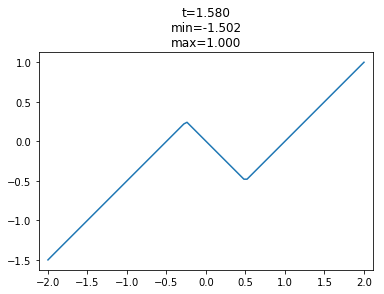

In [14]:
grid=GridHex(np.linspace(-2,2,101))
rit2=Reinitialization(grid,grid.seeds[0]*(grid.seeds[0]**2-0.5*grid.seeds[0]-0.5),dt=0.01)
#rit2.plot()

#rit2.solution(0.003,160,40,figw=6)
rit2.steadyState(dt=0.02)
rit2.plot()
np.max(rit2.rk.Z),np.min(rit2.rk.Z) 

### 一维扩散

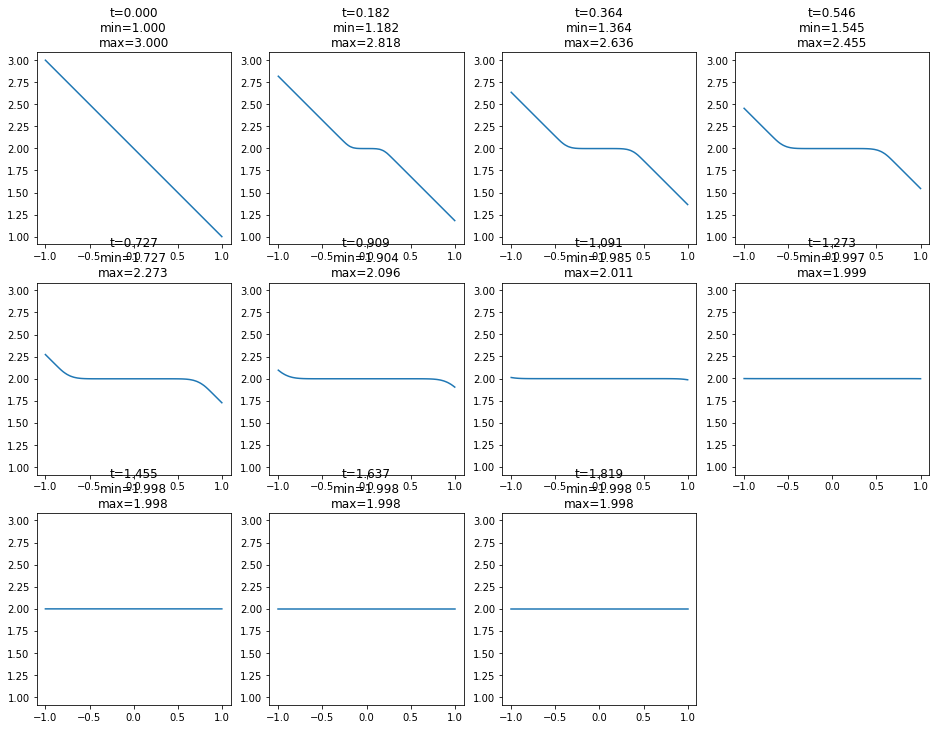

In [15]:
g1=GridHex(np.linspace(-1,1,100))
rot1=Reorthogonalization(g1,g1.X,2-g1.X,0.01)
rot1.solution(0.02,100,10,auto=True)

### 2D 圆形

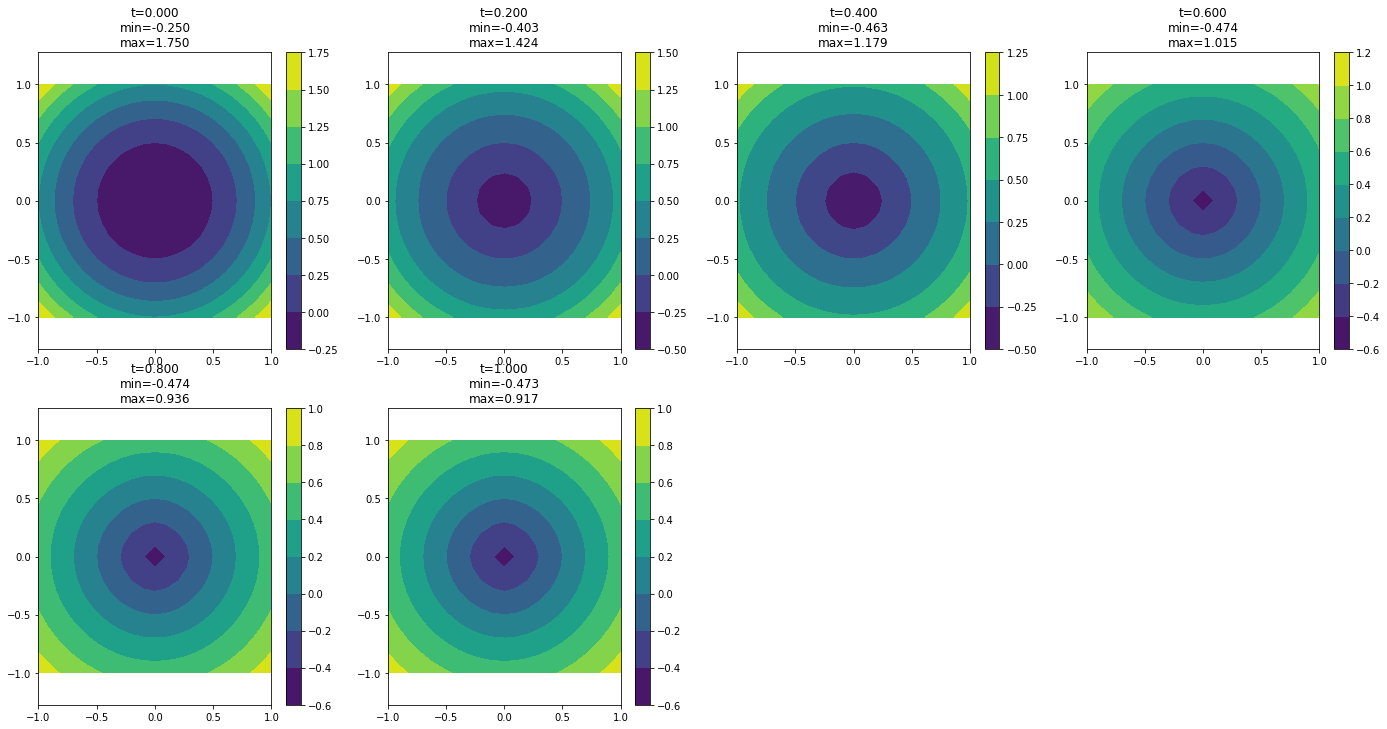

In [16]:
grid=GridHex(np.linspace(-1,1,21),np.linspace(-1,1,21))
rit2d=Reinitialization(grid,(grid.X**2+grid.Y**2-0.25),0.005)        
rit2d.solution(0.01,100,20,figw=6)

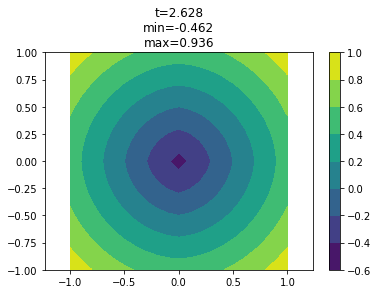

In [17]:
rit2d.reset()
rit2d.steadyState(eps=1e-3,dt=0.004,auto=True,scale=0.8)
rit2d.plot()

### 2D椭圆

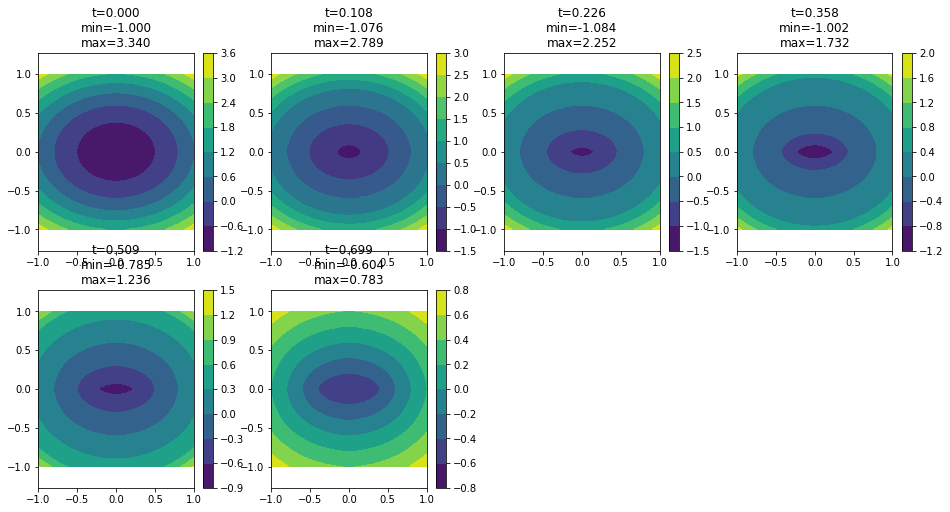

In [18]:
Nx,Ny=101,101
grid=GridHex(np.linspace(-1,1,Nx),np.linspace(-1,1,Ny))
rit_ell=Reinitialization(grid,grid.X**2/0.64+grid.Y**2/0.36-1,0.01)
rit_ell.solution(0.004,250,50,auto=True)

### 2D 
A PDE-Based Fast Local Level Set Method

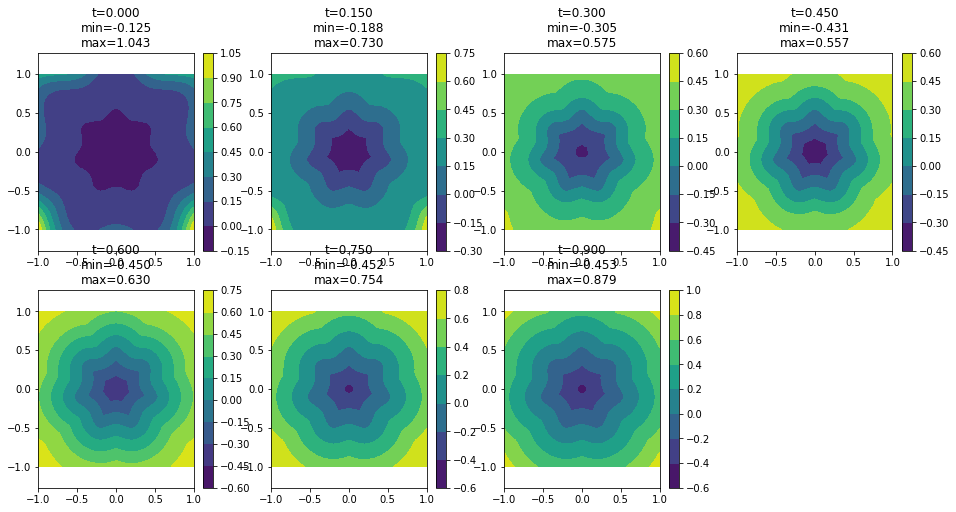

In [19]:
Nx,Ny=101,101
grid=GridHex(np.linspace(-1,1,Nx),np.linspace(-1,1,Ny))
r,theta=np.sqrt(grid.X**2+grid.Y**2),np.arctan2(grid.Y,grid.X)
rit_star=Reinitialization(grid,(r-0.5+0.1*r*np.sin(7*theta))**3,0.01)
rit_star.solution(0.003,300,50)

### 2D  Discontinuous
> Duflot M. A study of the representation of cracks with level sets[J]. International journal for numerical methods in engineering, 2007, 70(11): 1261-1302.  
section 3.1

In [20]:
Nx,Ny=101,101
grid=GridHex(np.linspace(-1,1,Nx),np.linspace(-1,1,Ny))
phi,psi=(grid.X+grid.Y+0.1)/np.sqrt(2)*(grid.X<=-0.1)+grid.Y*(grid.X>-0.1),grid.X
r,theta=np.sqrt(phi**2+psi**2),np.arctan2(phi,psi)

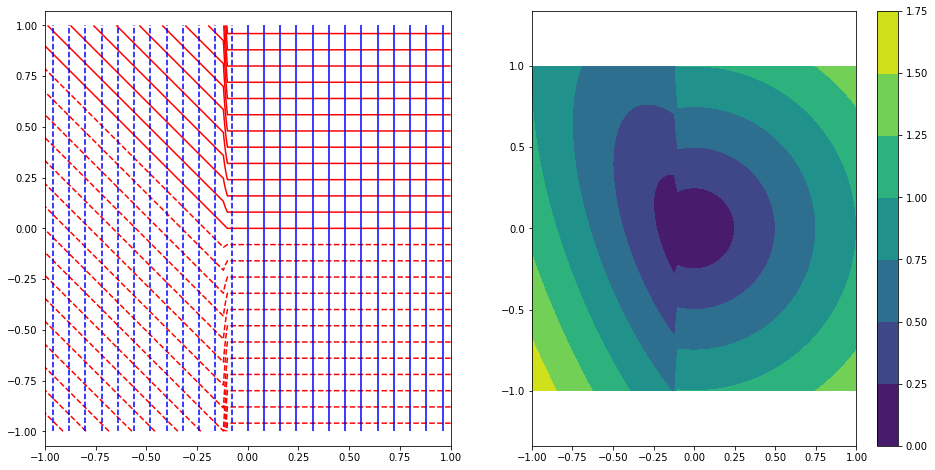

In [21]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.axis('equal')
for zz,color in zip([phi,psi,],['red','blue','green','black']):
    cphi=plt.contour(grid.X,grid.Y,zz,30,colors=color)
    #plt.clabel(cphi, inline=1, fontsize=10)
plt.subplot(1,2,2)
plt.axis('equal')
plt.contourf(grid.X,grid.Y,r)
plt.colorbar()

2020-04-14 23:03:18,677 - LevelSet - WARNING - Warning : dt=(0.010) > CFL step bound (0.001) 
2020-04-14 23:03:18,685 - LevelSet - WARNING - Warning : dt=(0.010) > CFL step bound (0.003) 
2020-04-14 23:03:18,693 - LevelSet - WARNING - Warning : dt=(0.010) > CFL step bound (0.003) 
2020-04-14 23:03:18,700 - LevelSet - WARNING - Warning : dt=(0.010) > CFL step bound (0.003) 
2020-04-14 23:03:18,709 - LevelSet - WARNING - Warning : dt=(0.010) > CFL step bound (0.004) 
2020-04-14 23:03:18,773 - LevelSet - WARNING - Warning : dt=(0.010) > CFL step bound (0.004) 
2020-04-14 23:03:18,782 - LevelSet - WARNING - Warning : dt=(0.010) > CFL step bound (0.004) 
2020-04-14 23:03:18,789 - LevelSet - WARNING - Warning : dt=(0.010) > CFL step bound (0.004) 
2020-04-14 23:03:18,798 - LevelSet - WARNING - Warning : dt=(0.010) > CFL step bound (0.004) 
2020-04-14 23:03:18,806 - LevelSet - WARNING - Warning : dt=(0.010) > CFL step bound (0.004) 
2020-04-14 23:03:18,979 - LevelSet - WARNING - Warning : dt=

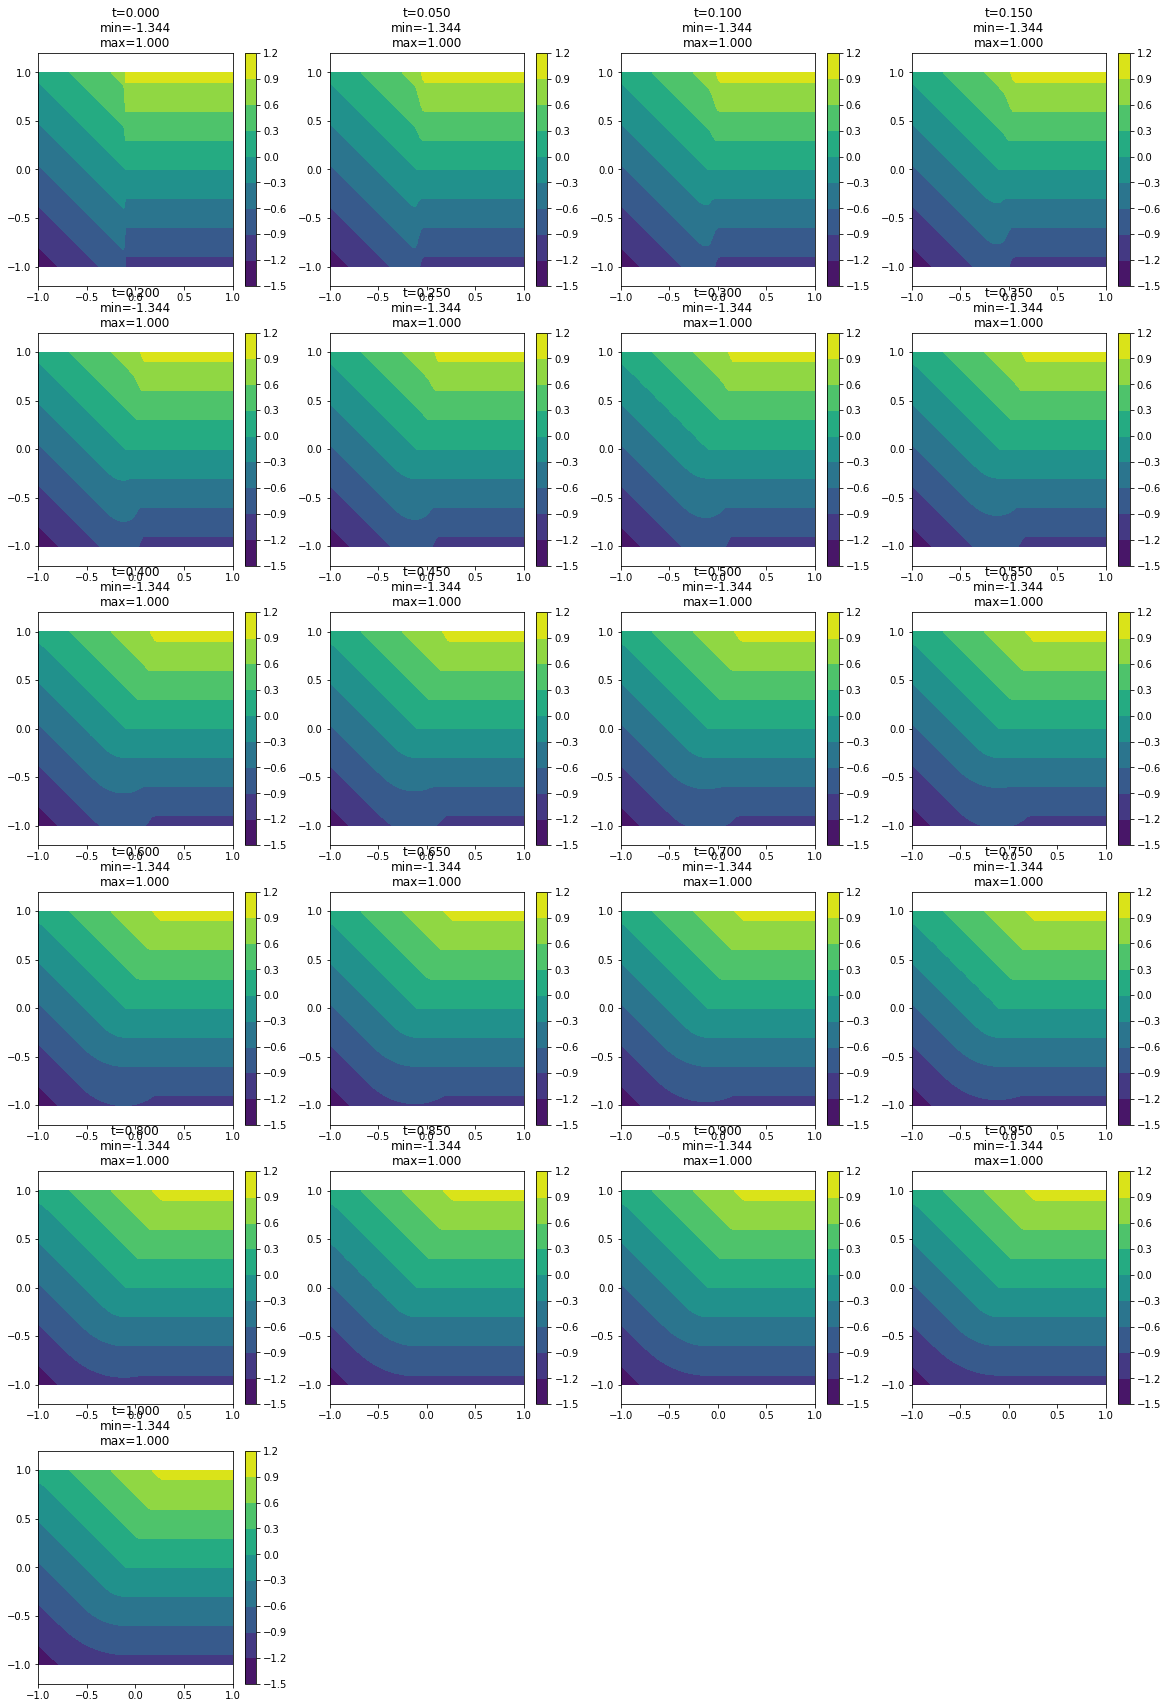

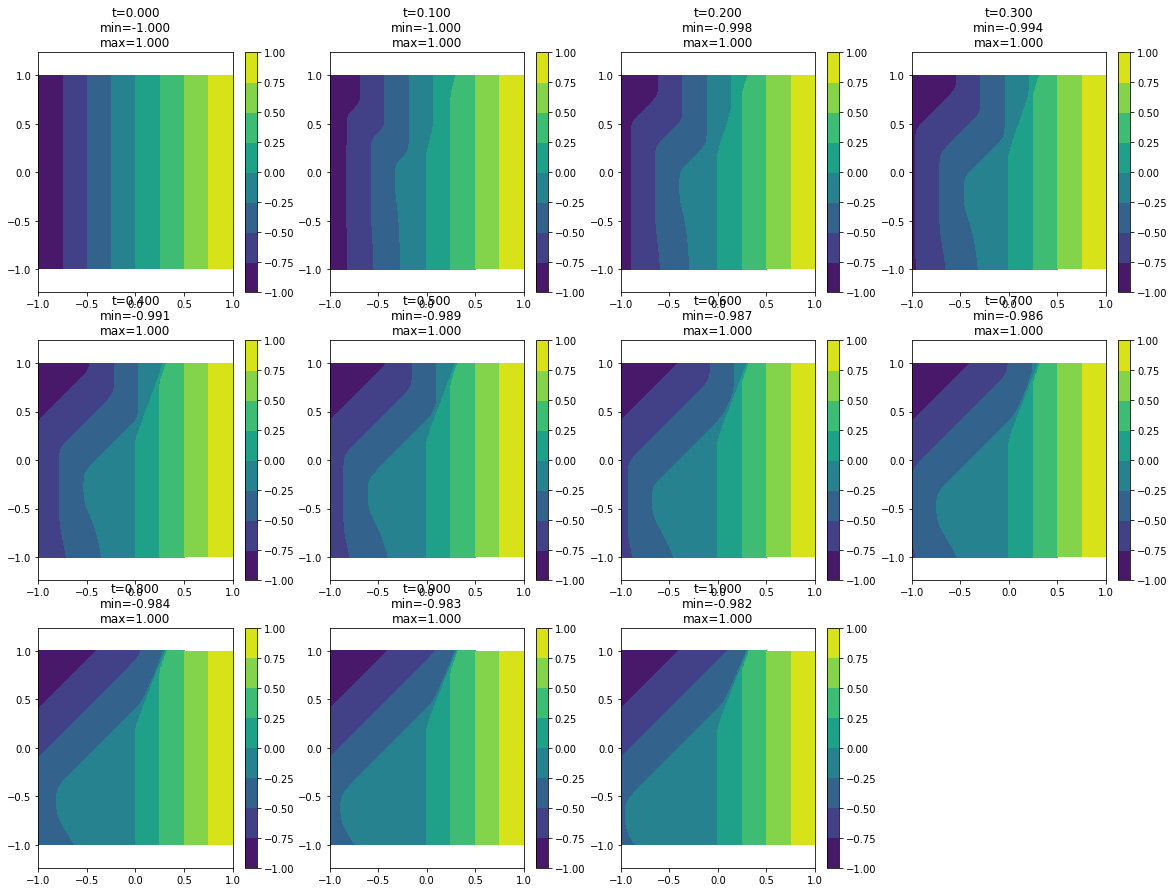

2020-04-14 23:03:28,615 - LevelSet - WARNING - Warning : dt=(0.001) > CFL step bound (0.001) 
2020-04-14 23:03:28,650 - LevelSet - WARNING - Warning : dt=(0.001) > CFL step bound (0.001) 
2020-04-14 23:03:28,675 - LevelSet - WARNING - Warning : dt=(0.001) > CFL step bound (0.001) 
2020-04-14 23:03:28,691 - LevelSet - WARNING - Warning : dt=(0.001) > CFL step bound (0.001) 


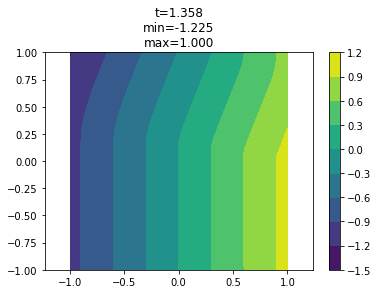

(-1.0, 1.0, -1.0, 1.0)

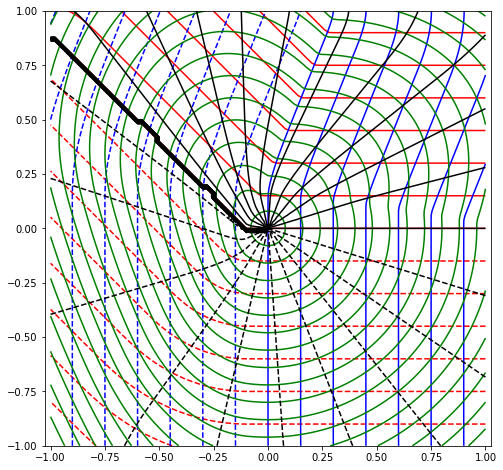

In [22]:
reinit1=Reinitialization(grid,phi,0.1)
reinit1.solution(0.01,100,5,figw=5)
plt.axis('equal')
plt.show()

reorth=Reorthogonalization(grid,reinit1.rk.Z,psi,0.01)
reorth.solution(0.01,100,10,figw=5)
plt.axis('equal')
plt.show()

reinit_psi=Reinitialization(grid,reorth.rk.Z,0.005)
reinit_psi.steadyState(auto=True)
reinit_psi.plot()
plt.show()

plt.figure(figsize=(8,8))
grid=reinit1.grid

for zz,color in zip([reinit1.rk.Z,
                     reinit_psi.rk.Z,
                     np.sqrt(reinit1.rk.Z**2+reinit_psi.rk.Z**2),
                     np.arctan2(reinit1.rk.Z,reinit_psi.rk.Z)],['red','blue','green','black']):
    cphi=plt.contour(grid.X,grid.Y,zz,20,colors=color)
plt.axis("equal")

2020-04-14 23:03:38,919 - LevelSet - WARNING - Warning : dt=(0.010) > CFL step bound (0.001) 
2020-04-14 23:03:38,927 - LevelSet - WARNING - Warning : dt=(0.010) > CFL step bound (0.003) 
2020-04-14 23:03:38,934 - LevelSet - WARNING - Warning : dt=(0.010) > CFL step bound (0.003) 
2020-04-14 23:03:38,941 - LevelSet - WARNING - Warning : dt=(0.010) > CFL step bound (0.003) 
2020-04-14 23:03:38,950 - LevelSet - WARNING - Warning : dt=(0.010) > CFL step bound (0.004) 
2020-04-14 23:03:39,025 - LevelSet - WARNING - Warning : dt=(0.010) > CFL step bound (0.004) 
2020-04-14 23:03:39,032 - LevelSet - WARNING - Warning : dt=(0.010) > CFL step bound (0.004) 
2020-04-14 23:03:39,040 - LevelSet - WARNING - Warning : dt=(0.010) > CFL step bound (0.004) 
2020-04-14 23:03:39,049 - LevelSet - WARNING - Warning : dt=(0.010) > CFL step bound (0.004) 
2020-04-14 23:03:39,057 - LevelSet - WARNING - Warning : dt=(0.010) > CFL step bound (0.004) 
2020-04-14 23:03:39,134 - LevelSet - WARNING - Warning : dt=

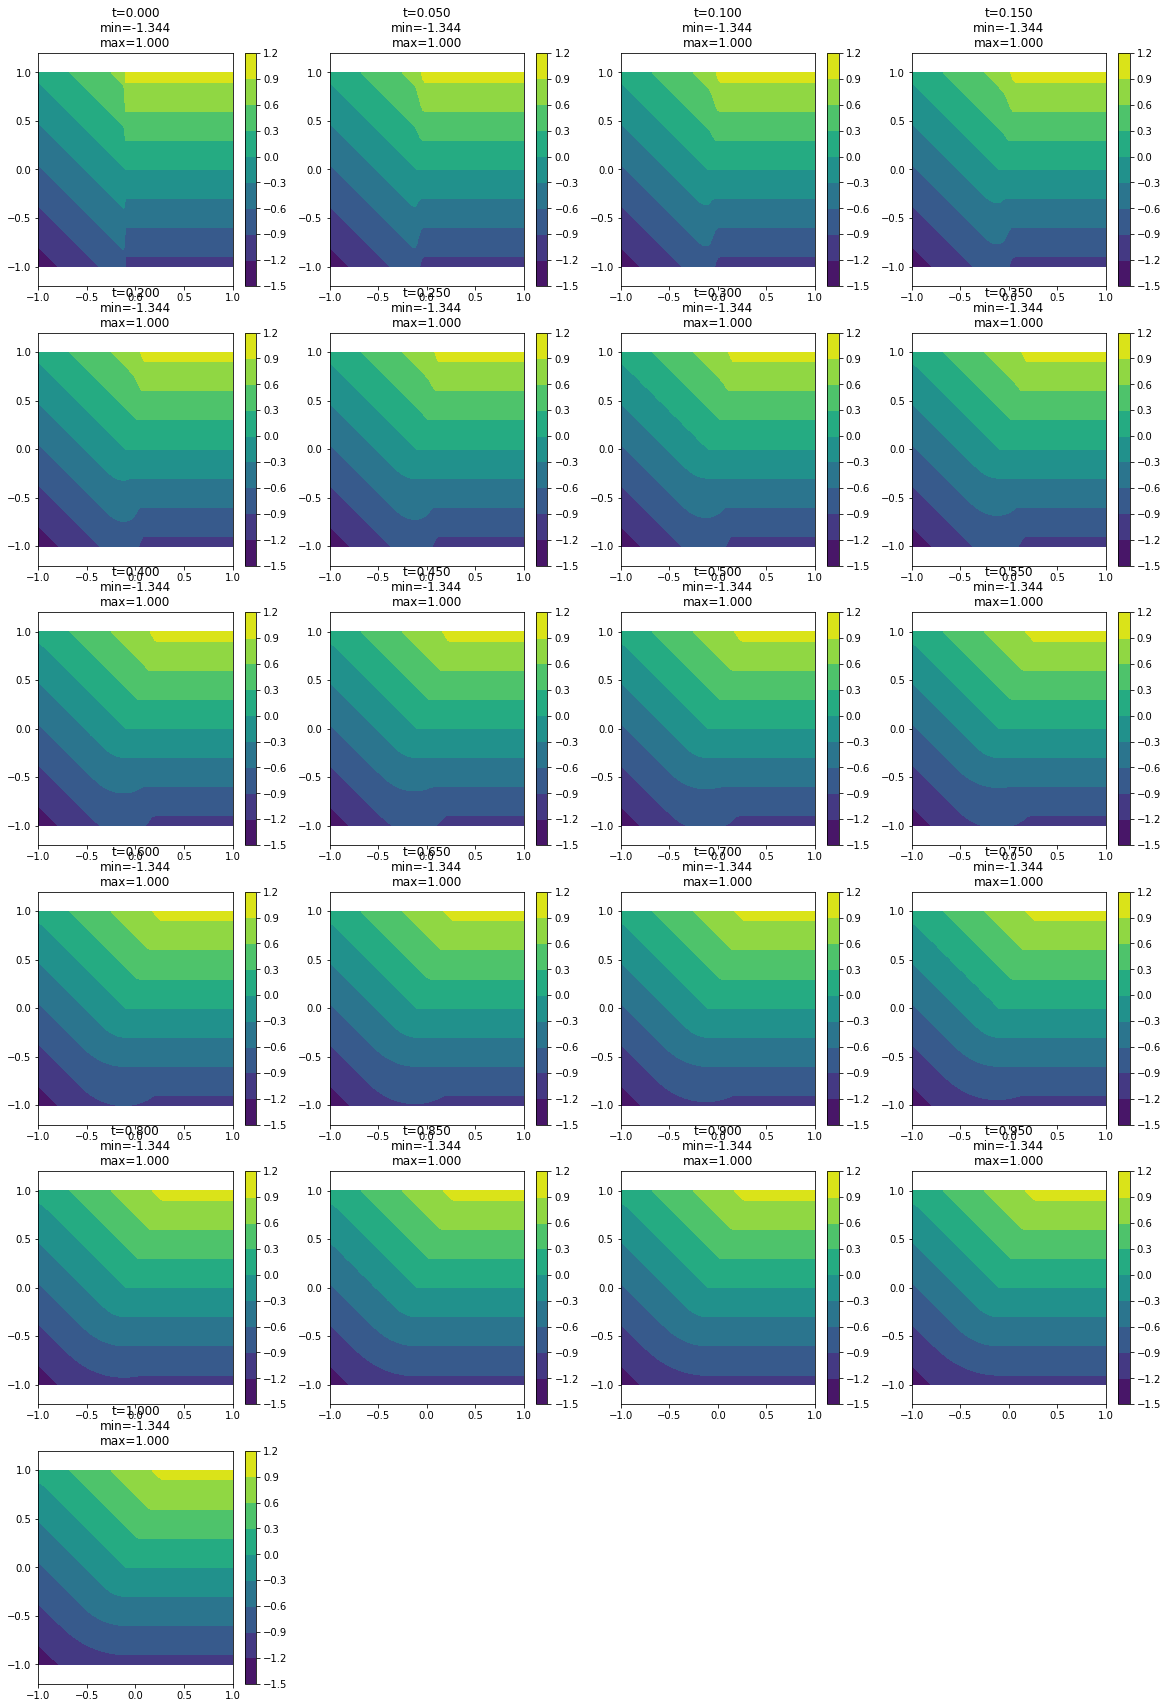

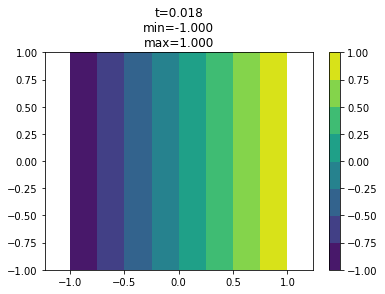

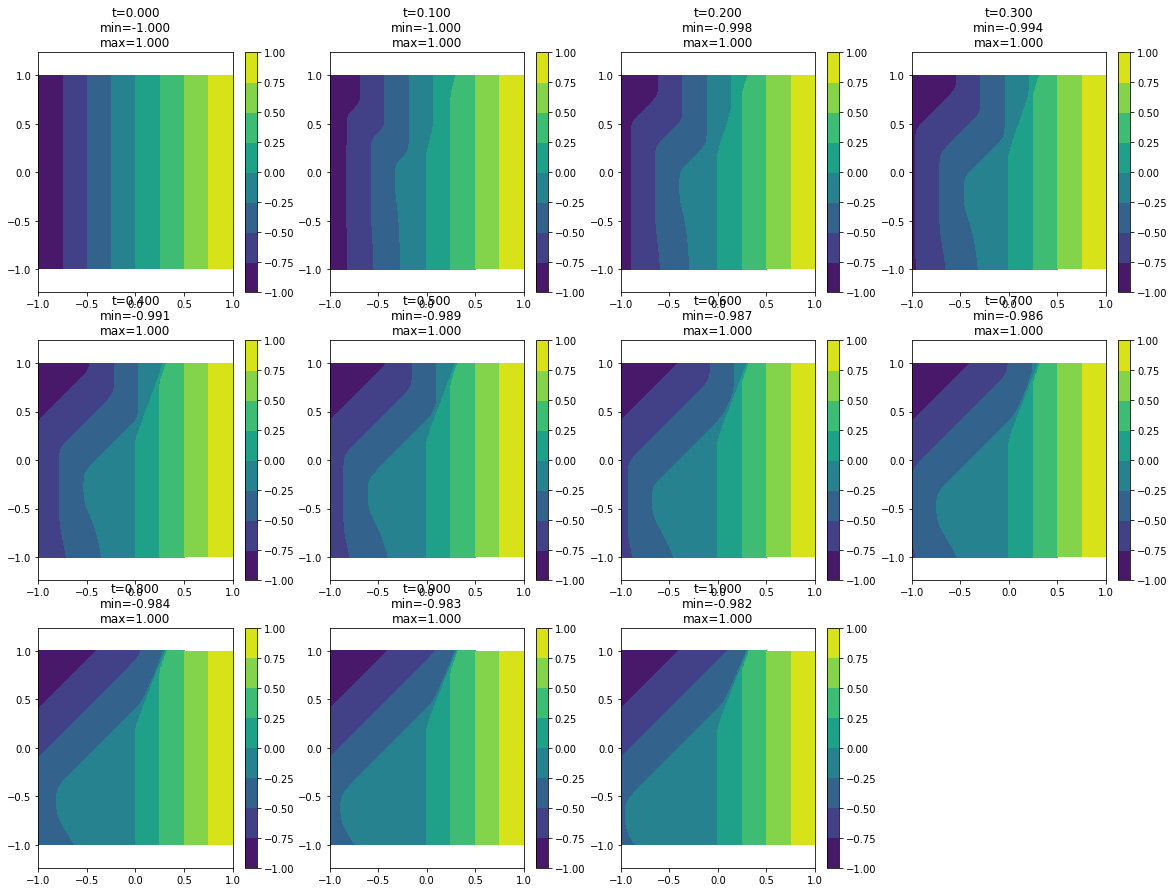

(-1.0, 1.0, -1.0, 1.0)

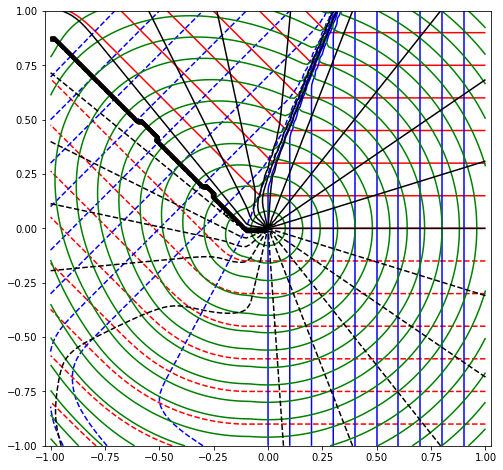

In [23]:
reinit1=Reinitialization(grid,phi,0.1)
reinit1.solution(0.01,100,5,figw=5)
plt.axis('equal')
plt.show()

reinit_psi=Reinitialization(grid,psi,0.005)
reinit_psi.steadyState(auto=True)
reinit_psi.plot()
plt.show()

reorth=Reorthogonalization(grid,reinit1.rk.Z,reinit_psi.rk.Z,0.01)
reorth.solution(0.01,100,10,figw=5)
plt.axis('equal')
plt.show()

plt.figure(figsize=(8,8))
grid=reinit1.grid
for zz,color in zip([reinit1.rk.Z,reorth.rk.Z,
                     np.sqrt(reinit1.rk.Z**2+reorth.rk.Z**2),
                     np.arctan2(reinit1.rk.Z,reorth.rk.Z)],['red','blue','green','black']):
    cphi=plt.contour(grid.X,grid.Y,zz,20,colors=color)
plt.axis("equal")

In [107]:
VoxelPointOrder={
    1:[(0,),(1,)],
    2:[(0,0),(0,1),(1,1),(0,1)],
    3:[(0,0,0),(0,1,0),(1,1,0),(0,1,0),
       (0,0,1),(0,1,1),(1,1,1),(0,1,1),],
}
VoxelPointOrder={
    1:[(0,),(1,)],
    2:[(0,0),(0,1),(1,0),(1,1)],
    3:[(0, 0, 0),(0, 0, 1),(0, 1, 0),(0, 1, 1),
       (1, 0, 0),(1, 0, 1),(1, 1, 0),(1, 1, 1)],
}
W1=np.linalg.inv(np.array([[1,0,0,0],
                           [1,1,1,1],
                           [0,1,0,0],
                           [0,1,2,3]]))
# Press W H, Teukolsky S A, Flannery B P, et al. Numerical recipes in Fortran 77: volume 1, volume 1 of Fortran numerical recipes: the art of scientific computing[M]. Cambridge university press, 1992.
def cucof(ys,y1s,ds,W=None):
    """
    ys,y1s : the value of f,f_x in grid points (0,0),(0,1),(1,0),(1,1)
    d1 : the length of the 1th and 2th dimension
    """
    d1=ds[0]
    x=np.concatenate([ys,y1s*d1])
    c=np.dot(W,x).reshape((4,),order='C')
    return c
cucof=partial(cucof,W=W1)
def cuint(c,seeds,xs):
    x=xs[0]
    d1=seeds[0][1]-seeds[0][0]
    t=(x-seeds[0][0])/d1
    y=((c[3]*t+c[2])*t+c[1])*t+c[0]
    y1=(3*c[3]*t+2*c[2])*t+c[1]
    return y,(y1/d1,)

d1,d2,d3=1.0,1.0,1.0
xs,ys,zs=(0,1),(0,1),(0,1)
X=np.zeros((16,16))
## The order is different to the Figure 3.6.1 in Numerical recips
## So W2 is also different
for k,(x,y) in enumerate(product(xs,ys)):
    X[k,:]=np.array([x**i*y**j for i,j in product(range(4),range(4))])
    X[k+4,:]=np.array([i*(0 if i<1 else x**(i-1))*y**j for i,j in product(range(4),range(4))])
    X[k+8,:]=np.array([j*x**i*(0 if j<1 else y**(j-1)) for i,j in product(range(4),range(4))])
    X[k+12,:]=np.array([i*j*(0 if i<1 else x**(i-1))*(0 if j<1 else y**(j-1)) for i,j in product(range(4),range(4))])
W2=np.linalg.inv(X) 

# Press W H, Teukolsky S A, Flannery B P, et al. Numerical recipes in Fortran 77: volume 1, volume 1 of Fortran numerical recipes: the art of scientific computing[M]. Cambridge university press, 1992.
def bcucof(ys,y1s,y2s,y12s,ds,W=None):
    """
    ys,y1s,y2s,y12s : the value of f,f_x,f_y,f_xy in grid points (0,0),(0,1),(1,0),(1,1)
    d1,d2 : the length of the 1th and 2th dimension
    """
    d1,d2=ds
    x=np.concatenate([ys,y1s*d1,y2s*d2,y12s*(d1*d2)])
    c=np.dot(W,x).reshape((4,4),order='C')
    return c
bcucof=partial(bcucof,W=W2)
def bcuint(c,seeds,xs):
    d1,d2=[seed[1]-seed[0] for seed in seeds]
    t,u=[(xs[i]-seeds[i][0])/(seeds[i][1]-seeds[i][0]) for i in range(2)]

    y,y1,y2=0.,0.,0.
    for i in range(3,-1,-1):
        y=t*y+((c[i,3]*u+c[i,2])*u+c[i,1])*u+c[i,0]
        y1=u*y1+(3*c[3,i]*t+2*c[2,i])*t+c[1,i]
        y2=t*y2+(3*c[i,3]*u+2*c[i,2])*u+c[i,1]
    return y,(y1/d1,y2/d2)

X=np.zeros((64,64))
N=3
p=lambda x,k: 0 if k<0 else x**k
for n,(x,y,z) in enumerate(product((0.,1.),(0.,1.),(0.,1.))):
    X[n,:]   =np.array([p(x,i)*p(y,j)*p(z,k) for i,j,k in product(range(4),range(4),range(4))])
    X[n+8,:] =np.array([i*p(x,i-1)*p(y,j)*p(z,k) for i,j,k in product(range(4),range(4),range(4))])
    X[n+16,:]=np.array([j*p(x,i)*p(y,j-1)*p(z,k) for i,j,k in product(range(4),range(4),range(4))])
    X[n+24,:]=np.array([k*p(x,i)*p(y,j)*p(z,k-1) for i,j,k in product(range(4),range(4),range(4))])
    X[n+32,:]=np.array([k*j*p(x,i)*p(y,j-1)*p(z,k-1) for i,j,k in product(range(4),range(4),range(4))])    
    X[n+40,:]=np.array([i*k*p(x,i-1)*p(y,j)*p(z,k-1) for i,j,k in product(range(4),range(4),range(4))])
    X[n+48,:]=np.array([i*j*p(x,i-1)*p(y,j-1)*p(z,k) for i,j,k in product(range(4),range(4),range(4))])
    X[n+56,:]=np.array([i*j*k*p(x,i-1)*p(y,j-1)*p(z,k-1) for i,j,k in product(range(4),range(4),range(4))])
W3=np.linalg.inv(X)
#W.flatten('F')
def tricucof(ys,y1s,y2s,y3s,y23s,y13s,y12s,y123s,ds,W=None):
    d1,d2,d3=ds
    x=np.concatenate([ys,y1s*d1,y2s*d2,y3s*d3,
                      y23s*(d2*d3),y13s*(d1*d3),y12s*(d1*d2),
                      y123s*(d1*d2*d3)])
    c=np.dot(W,x).reshape((4,4,4),order='C')
    return c
tricucof=partial(tricucof,W=W3)

def tricuint(c,seeds,xs):
    """
    seeds: tuple of lower bound and upper bound of axis
        ((x1l,x1u),(x2l,x2u),(x3l,x3u))
    """
    d1,d2,d3=[seeds[i][1]-seeds[i][0] for i in range(3)]
    r,s,t=[(xs[i]-seeds[i][0])/(seeds[i][1]-seeds[i][0]) for i in range(3)]
    #print(c)
    
    y,y1,y2,y3=0.,0.,0.,0.
    for i in range(3,-1,-1):
        inc,inc1,inc2,inc3=0.,0.,0.,0.
        for j in range(3,-1,-1):
            inc=t*inc+((c[i,3,j]*s+c[i,2,j])*s+c[i,1,j])*s+c[i,0,j]
            inc1=s*inc1+(3*c[3,j,i]*r+2*c[2,j,i])*r+c[1,j,i]
            inc2=t*inc2+(3*c[i,3,j]*s+2*c[i,2,j])*s+c[i,1,j]
            inc3=r*inc3+(3*c[j,i,3]*t+2*c[j,i,2])*t+c[j,i,1]
        y=r*y+inc
        y1=t*y1+inc1
        y2=r*y2+inc2
        y3=s*y3+inc3
    return y,(y1/d1,y2/d2,y3/d3)

### 一维三次插值

In [10]:
W1.flatten('F')

array([ 1.,  0., -3.,  2.,  0.,  0.,  3., -2.,  0.,  1., -2.,  1.,  0.,
        0., -1.,  1.])

In [11]:
f=smx**4
#f1,f2,f3,f12,f13,f23,f123
fs=f,f.diff(smx)
seeds=((0.,1.),)

vals=list(zip(*[[expr.evalf(subs={'x':x}) for expr in fs] for x in seeds[0]]))
cof=cucof(*[np.array(val) for val in vals],(seeds[0][1]-seeds[0][0],))

In [15]:
[cuint(cof,seeds,(x,)) for x in xs]

[(0, (0,)),
 (-0.00800000000000000, (-0.140000000000000,)),
 (-0.0240000000000000, (-0.160000000000000,)),
 (-0.0360000000000000, (-0.0599999999999999,)),
 (-0.0320000000000000, (0.160000000000000,)),
 (0, (0.500000000000000,)),
 (0.0720000000000001, (0.960000000000000,)),
 (0.196000000000000, (1.54000000000000,)),
 (0.384000000000000, (2.24000000000000,)),
 (0.648000000000000, (3.06000000000000,)),
 (1.00000000000000, (4.00000000000000,))]

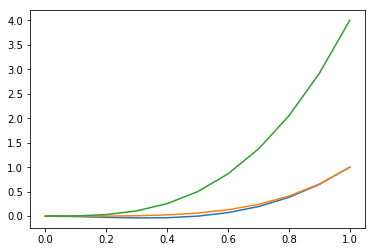

In [16]:
xs=np.linspace(0,1,11)
plt.plot(xs,[cuint(cof,seeds,(x,))[0] for x in xs])
plt.plot(xs,[fs[0].evalf(subs={'x':x}) for x in xs])
plt.plot(xs,[fs[1].evalf(subs={'x':x}) for x in xs])

### 二维三次插值

In [17]:
np.set_printoptions(linewidth=np.nan)
np.savetxt('W2_16x16.txt',W2.flatten('F').astype(np.int),fmt='%d', delimiter=',',newline='\n')
W2.flatten('C')

array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -3.,  3., -0., -0., -0., -0., -0., -0., -2., -1., -0., -0., -0., -0., -0., -0.,  2., -2.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0., -0., -0., -0., -0., -3.,  3., -0., -0., -0., -0., -0., -0., -2., -1., -0., -0.,  0.,  0.,  0.,  0.,  2., -2.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0., -3.,  0.,  3.,  0., -2.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -3.,  0.,  3.,  0., -2.,  0., -1.,  0.,  9., -9., -9.,  9.,  6., -6.,  3., -3.,  6.,  3., -6., -3.,  4.,  2.,  2.,  1., -6.,  6.,  6., -6., -4.,  4., -2.,  2., -3., -3.,  3.,  3., -2., -2., -1., -1.,  2., -0., -2., -0.,  1., -0.,  1.

In [25]:
f=sym.exp(smx**4+smy**4)
#f1,f2,f3,f12,f13,f23,f123
fs=f,f.diff(smx),f.diff(smy),f.diff(smx,smy)
seeds=((0.,1.),(0.,1.))

vals=list(zip(*[[expr.evalf(subs={'x':x,'y':y}) for expr in fs] for x,y in product(*seeds)]))
cof=bcucof(*[np.array(val) for val in vals],[seed[1]-seed[0] for seed in seeds])

In [26]:
for coord in product(*[np.linspace(seed[0],seed[1],3) for seed in seeds]):
    print(coord,end=':')
    y,y1s=bcuint(cof,seeds,coord)
    for x,y in zip([y,*y1s],
                   [expr.evalf(subs={'x':coord[0],'y':coord[1]}) for expr in fs[:4]]):
        print((x-y)/y,end=';')
    print('')    

(0.0, 0.0):0;nan;nan;
(0.0, 0.5):-0.530293468593262;nan;-1.26464973037750;
(0.0, 1.0):1.63371290349908e-16;nan;1.63371290349908e-16;
(0.5, 0.0):-0.530293468593262;-1.26464973037750;nan;
(0.5, 0.5):-0.779375774353850;-1.12430770689333;-1.12430770689333;
(0.5, 1.0):-0.530293468593260;-1.26464973037748;-0.530293468593261;
(1.0, 0.0):1.63371290349908e-16;1.63371290349908e-16;nan;
(1.0, 0.5):-0.530293468593260;-0.530293468593261;-1.26464973037748;
(1.0, 1.0):3.24545070585861e-15;1.80302816992145e-15;1.80302816992145e-15;


### 三维三次插值

In [27]:
np.set_printoptions(linewidth=np.nan)
W3.flatten('F')
np.savetxt('W3_64x64.txt',W3.flatten('F').astype(np.int),fmt='%d', delimiter=',',newline='\n')

In [28]:
f=smx**5+smy**5+smz**5
#f1,f2,f3,f12,f13,f23,f123
fs=f,f.diff(smx),f.diff(smy),f.diff(smz),f.diff(smy,smz),f.diff(smx,smz),f.diff(smx,smy),f.diff(smx,smy,smz)

seeds=((1.,2.),(1.,2.),(1.,2.))
vals=list(zip(*[[expr.evalf(subs={'x':x,'y':y,'z':z}) for expr in fs] for x,y,z in product(*seeds)]))
cof=tricucof(*[np.array(val) for val in vals],[seeds[i][1]-seeds[i][0] for i in range(3)])
for coord in product(*[np.linspace(seeds[i][0],seeds[i][1],3) for i in range(3)]):
    y,y1s=tricuint(cof,seeds,coord)
    for x,y in zip([y,*y1s],
                   [expr.evalf(subs={'x':coord[0],'y':coord[1],'z':coord[2]}) for expr in fs[1:4]]):
        print('%.3f %.3f'%(y,(x-y)/y),end=';')
    print('')

5.000 -0.400;5.000 0.000;5.000 0.000;
5.000 0.825;5.000 0.000;25.312 -0.802;
5.000 5.800;5.000 0.000;80.000 -0.938;
5.000 0.825;25.312 -0.802;5.000 4.050;
5.000 2.050;25.312 -0.802;25.312 -0.002;
5.000 7.025;25.312 -0.802;80.000 -0.684;
5.000 5.800;80.000 -0.938;5.000 15.000;
5.000 7.025;80.000 -0.938;25.312 2.160;
5.000 12.000;80.000 -0.938;80.000 0.000;
25.312 -0.640;5.000 4.050;5.000 0.000;
25.312 -0.398;5.000 4.050;25.312 -0.802;
25.312 0.585;5.000 4.050;80.000 -0.938;
25.312 -0.398;25.312 -0.002;5.000 4.050;
25.312 -0.156;25.312 -0.002;25.312 -0.002;
25.312 0.827;25.312 -0.002;80.000 -0.684;
25.312 0.585;80.000 -0.684;5.000 15.000;
25.312 0.827;80.000 -0.684;25.312 2.160;
25.312 1.810;80.000 -0.684;80.000 0.000;
80.000 -0.575;5.000 15.000;5.000 0.000;
80.000 -0.498;5.000 15.000;25.312 -0.802;
80.000 -0.188;5.000 15.000;80.000 -0.938;
80.000 -0.498;25.312 2.160;5.000 4.050;
80.000 -0.422;25.312 2.160;25.312 -0.002;
80.000 -0.111;25.312 2.160;80.000 -0.684;
80.000 -0.188;80.000 0.00

# Fast Marching Method


In [29]:
fmmlogger=logging.getLogger("FastMarching")
fmmlogger.setLevel(logging.DEBUG)
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
ch.setFormatter(logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s'))
fmmlogger.handlers.clear()
fmmlogger.addHandler(ch)

In [603]:
class FastMarching:
    """
    1. Bærentzen J A. On the implementation of fast marching methods for 3D lattices[J]. 2001.
    2. Sukumar N, Chopp D L, Moran B. Extended finite element method and fast marching method for three-dimensional fatigue crack propagation[J]. Engineering Fracture Mechanics, 2003, 70(1): 29-48.
    3. Sethian J A. Fast marching methods[J]. SIAM review, 1999, 41(2): 199-235.    
    4. Sukumar N, Chopp D L, Bechet E, et al. Three‐dimensional non‐planar crack growth by a coupled extended finite element and fast marching method[J]. International Journal for Numerical Methods in Engineering, 2008, 76(5): 727-748.
    """
    def __init__(self,grid,T0,status,extend=None,Fext=[]):
        self.logger=logging.getLogger("FastMarching")
        
        self.grid=grid
        self.T0=T0
        self.T=np.where(status==1,T0,np.inf) #np.sign(T0)*
        
        # fields need to extend from interface to entire domain
        # if extend is None or dict lick {'xl':xl,'Fl':Fl}
        #   xl is  a list of sample coordinates on the inteface
        #   Fl is list of fieled defined on the vertices
        self.extend=(extend is not None)
        if self.extend:
            self.xl=extend['xl']
            self.Fl=extend['Fl']
            self.Fext=[np.full_like(self.T,np.inf) for _ in range(len(self.Fl))]
        # status of each grid points : 
        #   -1 for Distant : also know as Far, far from the initial interface to be possible candidates for 
        #   0 for Tentaive : also know as Narrow Band, all potential candidates to be the next mesh point to be added to the set A
        #   1 for Accepted : also know as Frozen, All the mesh points are considered computed and are always closer to the initial interface than any of the remaining mesh points
        self.Status=status
        
        # used in Reintialization to 
        self.frontInitialize()
        
        # all potential candidates to be the next mesh point to be added to the set A
        #  kept sorted in a heap sort
        self.Tentative=[]
        heapq.heapify(self.Tentative)
        
        self.initialization()
            
    def frontInitialize(self):
        #raise NotImplementedError('frontInitialize not implemented!')
        pass
    
    def velocity(self,index):
        raise NotImplementedError('Velocity not implemented!')

    def initialization(self):
        for index in np.argwhere(self.Status==1):
            index=tuple(index)
            if self.extend:
                # Ref.4 Eq.20
                x=self.pointCoord(index)
                i1,x1,d1=None,None,np.infty
                i2,x2,d2=None,None,np.infty
                for i,pt in enumerate(self.xl):
                    d=sum(((x[j]-pt[j])**2 for j in range(len(x))))**0.5
                    if d<d1:
                        i2,x2,d2=i1,x1,d1
                        i1,x1,d1=i,pt,d
                    elif d<d2:
                        i2,x2,d2=i,pt,d
                
                a=sum(((x[j]-x1[j])**2 for j in range(len(x))))
                b=sum(((x[j]-x2[j])**2 for j in range(len(x))))
                c=sum(((x[j]-x1[j])*(x[j]-x2[j]) for j in range(len(x))))
                # (1-alpha)*x1+alpha*x2 is the closet 
                alpha=min(1,max(0,(a-c)/(a+b-2*c)))
                for i in range(len(self.Fext)):
                    self.Fext[i][index]=(1-alpha)*self.Fl[i][i1]+alpha*self.Fl[i][i2]
                self.logger.debug("index=%s,x=%s,x1=%s,x2=%s,alpha=%f,a=%f,b=%f,c=%f"%(repr(index),repr(x),repr(x1),repr(x2),alpha,a,b,c))
            self.updateNeibour(index)
    
    def loop(self,vstop=np.infty):
        """
        loop update procedure until reach `vstop`
        """
        while(len(self.Tentative)>0):
            _,(v,index)=heapq.heappop(self.Tentative)
            if self.Status[index]==0:
                # 由于无法更新非Heap中元素的值，Tentative中存在过期的元素
                if v>vstop:
                    break
                self.n2k(index,v)
                self.updateNeibour(index)
    
    def updateNeibour(self,index):
        """
        updat each  neighbour of `index`
        """
        for neib in self.neighbours(index):
            status=self.Status[neib]
            if status<1:
                # Narrow band  or Far
                t=self.compute(neib)
                if np.isnan(t):
                    self.logger.warning('nan get in compute distance of index=%s'%(repr(neib)))
                elif abs(t)<abs(self.T[neib]):
                    self.f2n(neib,t)

    def n2k(self,ptindex,v):
        self.logger.info('n2k: index=%s,coords=%s,t=%f'%(ptindex,self.pointCoord(ptindex),v))
        self.Status[ptindex]=1
        self.T[ptindex]=v
        self.updateNeibour(ptindex)
    
    def f2n(self,ptindex,v):
        self.logger.info('f2n: index=%s,coords=%s,t=%f,old t=%f'%(repr(ptindex),self.pointCoord(ptindex),v,self.T[ptindex]))
        self.Status[ptindex]=0
        self.T[ptindex]=v
        heapq.heappush(self.Tentative,(abs(v),(v,ptindex)))

    def compute(self,index):
        """
        compute the distance of the voxel 
        1. Bærentzen J A. On the implementation of fast marching methods for 3D lattices[J]. 2001.
            Appendix A: Pseudo Code
        2. Sukumar N, Chopp D L, Moran B. Extended finite element method and fast marching method for three-dimensional fatigue crack propagation[J]. Engineering Fracture Mechanics, 2003, 70(1): 29-48.
            Section 3: Fast Marching Method (7a),(7b)
        3. Sethian J A. Fast marching methods[J]. SIAM review, 1999, 41(2): 199-235.
            Section 5:  Higher-Accuracy Fast Marching Methods
        """
        grid=self.grid
        ndim=grid.ndim
        
        if self.Status[index]==1:
            return None
        coeffs=[-1,0,0] # c,b,a for ax^2+bx+c=0
        
        # list of (+1 for right -1 for left, phi_1, delta_x)
        dervCoffs=self.dervCoff(index)
        neibs=[tuple((index[j]+ dervCoffs[axis][0]*(j==axis) for j in range(ndim))) 
                         for axis in range(ndim) if dervCoffs[axis][0]!=0]
        neibCoffs=[self.dervCoff(neib) for neib in neibs]
        for axis in range(ndim):
            if dervCoffs[axis][0]!=0:
                dirct,k,b,d1,d2=dervCoffs[axis]
                coeffs[2]=coeffs[2]+k**2
                coeffs[1]=coeffs[1]+2*k*b
                coeffs[0]=coeffs[0]+b**2
            else:
                coeffs[0]=coeffs[0]+max((cof[axis][1]*self.T[neib]+cof[axis][2])**2 for neib,cof in zip(neibs,neibCoffs))
            
        if coeffs[2]!=0:
            c,b,a=coeffs
            # 选择绝对值大的那个作为解
            if abs(b**2-4*a*c)<1e-8:
                t=-b/(2*a)
            else:
                q=0.5*(-b-(1 if b>=0 else -1)*np.sqrt(b**2-4*a*c))
                t1,t2=q/a,c/q
                if abs(abs(t1)-abs(t2))<1e-10:
                    t=np.sign(self.T0[index])*abs(t1)
                else:
                    t=t1 if abs(t1)>abs(t2) else t2
            
            self.logger.debug("index=%s,t=%f,equation=%s,neibs=%s,neib coffs=%s"%(repr(index),t,repr(dervCoffs),repr(neibs),repr(neibCoffs)))
            self.logger.debug("a=%f,b=%f,c=%f"%(a,b,c))
            # extend the velocity in the front 
            if self.extend:
                for i in range(len(self.Fext)):
                    k,b=0.,0.
                    for axis in range(ndim):
                        dirct,kj,bj,d1,d2=dervCoffs[axis]
                        derv=(kj*t+bj)
                        if dirct!=0:
                            v=self.Fext[i][tuple((index[j]+dirct*(j==axis) for j in range(ndim)))]
                            k=k-derv/(dirct*d1)
                            b=b+derv*v/(dirct*d1)
                    self.logger.debug("index=%s,d1=%f,k=%f,b=%f,Fext=%f"%(repr(index),d1,k,b,-b/k))
                    self.Fext[i][index]=-b/k
            return t
        else:
            self.logger.debug("index=%s,neibs=%s,equation=%s,coeffs=%s"%(repr(index),repr(neibs),repr(dervCoffs),repr(coeffs)))
            raise ValueError('compute invalid point index=%s'%repr(index))
    
    def dervCoff(self,index,order=1):
        grid=self.grid
        ndim=grid.ndim
        coffes=[]

        coords=self.pointCoord(index) 
        for axis in range(ndim):
            dirct,k,b,d1,d2=0,0,0,np.infty,np.infty
            for j in (-1,1):
                neib=tuple((index[k]+j*(k==axis) for k in range(ndim)))
                kj,bj,dx1,dx2=0.,np.infty,0.,np.infty
                if self.isPoint(neib) and self.Status[neib]==1:
                    coords1,t1=self.pointInfo(neib)
                    dx1=abs(coords1[axis]-coords[axis])
                    kj,bj=-1/(j*dx1),t1/(j*dx1)
                    
                    if order==2:
                        neib2=tuple((index[k]+2*j*(k==axis) for k in range(ndim)))
                        if self.isPoint(neib2) and self.Status[neib2]==1:
                            coords2,t2=self.pointInfo(neib2)
                            dx2=abs(coords2[axis]-coords1[axis])
                            kj=kj-1/(j*(dx1+dx2))
                            bj=bj+t1/(j*dx2)-(dx1/dx2)*(t2/(j*dx1+j*dx2))
                    
                    if (dirct==0) or (bj/kj)>(b/k):
                            dirct,k,b,d1,d2=j,kj,bj,dx1,dx2            
            coffes.append([dirct,k,b,d1,d2])
        return coffes
    
    def isPoint(self,ptindex):
        """
        返回节点是否是内部节点
        """
        return all(0<=ind<l for l,ind in zip(self.grid.shape,ptindex))
    
    def pointCoord(self,ptindex):
        return [seed[ind] for seed,ind in zip(self.grid.seeds,ptindex)]

    def pointInfo(self,ptindex):
        """
        返回节点index的坐标和T值
        如果节点在外部，则返回边界点的坐标和位置
        """
        #index=tuple(min(max(n,0),self.grid.X.shape[i]-1) for i,n in enumerate(index))
        return tuple(seed[ind] for seed,ind in zip(self.grid.seeds,ptindex)),self.T[ptindex]
    
    def neighbours(self,index):
        """
        返回邻接节点的索引列表
        """
        ndim=self.grid.ndim
        return [tuple((index[k]+j*(k==i) for k in range(ndim))) 
                        for i in range(ndim) for j in (-1,1) 
                        if 0<=index[i]+j<self.grid.shape[i]]
        
    def voxelPoints(self,vindex):
        """
        单元`vindex`中所有节点，节点顺序为三次插值中定义的顺序
        """
        ndim=self.grid.ndim
        return list(product(*(range(vindex[i],vindex[i]+2) for i in range(ndim))))
    
    def adjacent(self,ptindex,axis,N=1):
        """
        返回 沿axis方向左右两侧与节点index相邻的N个节点的列表的列表
        
        """
        ndim=self.grid.ndim
        
        pts=[[tuple([ptindex[k]-i*(k==axis) for k in range(ndim)]) for i in range(1,N+1)],
             [tuple([ptindex[k]+i*(k==axis) for k in range(ndim)]) for i in range(1,N+1)]]
        return pts

    def delta(self,index,axis):
        """
        计算节点index 沿着axis方向的长度
        """
        ind=index[axis] #min(max(index[axis],0),self.grid.X.shape[axis]-2)
        seed=self.grid.seeds[axis]
        return seed[ind+1]-seed[axis][ind]


class ReinitializeFMM(FastMarching):
    """
    1. Chopp D L. Some improvements of the fast marching method[J]. SIAM Journal on Scientific Computing, 2001, 23(1): 230-244.
        Give the detail for 2D case
    2. Shi J, Chopp D, Lua J, et al. Abaqus implementation of extended finite element method using a level set representation for three-dimensional fatigue crack growth and life predictions[J]. Engineering Fracture Mechanics, 2010, 77(14): 2840-2863.
        Give the detail for 3D case
    3. Sukumar N, Chopp D L, Béchet E, et al. Three‐dimensional non‐planar crack growth by a coupled extended finite element and fast marching method[J]. International journal for numerical methods in engineering, 2008, 76(5): 727-748.
    4. Adalsteinsson D , Sethian J A . The Fast Construction of Extension Velocities in Level Set Methods[J]. Journal of Computational Physics, 1999, 148(1):2-22.
    
    Reinitialization 
        
    Tip Velocity Extension
        Ref.1 Section 3.3
        Ref.3 Section 3.1.2
        Ref.4 
     the front velocity data are provided as a list of sample coordinates, Xl , and the corresponding front velocity vector, Fl.
      search for the two sample coordinates xl1 and xl2 closest to x,
          F_{ijk} =(1−\alpha)F_{l1} +\alpha F_{l2 }    
    """
    def __init__(self,grid,X,extend=None):
        status=np.full_like(X,-1)
        super().__init__(grid,X,status,extend=extend)
        
    def frontInitialize(self):
        """
        reconstruct process provides local tricubic approximation 
        of the initial conditions on grid points near the crack front
        """
        grid=self.grid
        ndim=grid.ndim
        
        for vindex in product(*(range(grid.shape[i]-1) for i in range(ndim))):
            if self.signChange(vindex):
                # sign changed
                cof=self.cubicCoff(vindex)
                for point in self.voxelPoints(vindex):
                    self.Status[point]=1
                    d=self.cubicDistance(vindex,cof,self.pointCoord(point))
                    #print(point,d,self.T0[point],self.T[point])
                    self.T[point]=np.sign(self.T0[point])*min(d,np.abs(self.T[point]))
    def velocity(self,ptindex):
        return 1.0
    
    def signChange(self,vindex):
        vals=self.voxelValues(vindex)
        return np.abs(np.mean(np.sign(vals)))!=1
    
    def voxelValues(self,vindex,X=None):  
        if X is None:
            X=self.T0
        return X[tuple(slice(ind,ind+2) for ind in vindex)]

        
    def cubicDistance(self,vindex,cof,xs):
        """
        Ref.1 Section 3.2
        """
        grid=self.grid
        ndim=grid.ndim
        
        x0,x=np.array(xs),np.array(xs)
        ds=np.array([(grid.seeds[i][vindex[i]],grid.seeds[i][vindex[i]+1]) for i in range(ndim)])
        vol=np.prod([seed[ind+1]-seed[ind] for seed,ind in zip(grid.seeds,vindex)])
        
        cnt=0
        while True:
            ## 是否在外部
            inside,index1=True,[]
            for i in range(ndim):
                inc=0 
                if x[i]<ds[i,0]:
                    inc,inside=-1,False
                elif x[i]>ds[i,1]:
                    inc,inside=1,False
                index1.append(vindex[i]+inc)
            
            if inside:
                f,derv=self.cubicInterpolation(cof,vindex,x)
            else:
                cof1=self.cubicCoff(index1)
                f,derv=self.cubicInterpolation(cof1,index1,x)
            derv=np.array(derv)
            sqr=np.linalg.norm(derv)**2
            
            dlt1=-f/sqr*derv
            dlt2=(x0-x)-np.dot(x0-x,derv)/sqr*derv
            #print(x0,x,f,derv,dlt1,dlt2)
            
            x=x+dlt1+dlt2
            cnt=cnt+1
            if(np.linalg.norm(dlt1+dlt2)<(1e-3*vol)):
                return np.linalg.norm(x-x0)
            if cnt>20:
                self.logger.warning('cubic distance while loop than 100 times %s -> %s'%(x0,x))
                return np.linalg.norm(x-x0)
        
    def cubicInterpolation(self,cof,vindex,xs):
        """
        return the `coef` used in the cubic interpolation
        """
        grid=self.grid
        ndim=grid.ndim
        seeds=[(grid.seeds[i][vindex[i]],grid.seeds[i][vindex[i]+1]) for i in range(ndim)]
        if ndim==1:
            return cuint(cof,seeds,xs)
        elif ndim==2:
            return bcuint(cof,seeds,xs)
        elif ndim==3:
            return tricuint(cof,seeds,xs)
        else:
            raise NotImplementedError('Cubic Interpolation for %d D Not Sumpport Now'%(ndim))        
    
    def cubicCoff(self,vindex):
        """
        Using Bicubic or Tricubic Interpolation to Calculate The distance of nodes in those elements which the zero level set crosses 
        1. Ref 1 Section 3.2
        2. Ref 3 Section 3.1.1 
        vindex: 
        """
        grid=self.grid
        ndim=grid.ndim
        oneOrder=lambda dx1,dx2: (-(dx2)/(dx1 * (dx1 + dx2)),(dx2 - dx1) / (dx1 * dx2),dx1 / (dx2 * (dx1 + dx2)))
        
        if ndim==1:
            # ys,y1s
            vals=np.array([self.T0[i] for i in 
                           (max(0,min(j,grid.shape[0]-1)) for j in range(vindex[0]-1,vindex[0]+3))])
            ds=np.array([grid.seeds[0][j+1]-grid.seeds[0][j] for j in 
                         (max(0,min(i,grid.shape[0]-2)) for i in range(vindex[0]-1,vindex[0]+2))])
            ys=vals[1:3]
            y1s=np.zeros((2,))
            for i in range(1,3):
                a,b,c=oneOrder(ds[i-1],ds[i])
                y1s[i-1]=a*vals[i-1]+b*vals[i]+c*vals[i+1]
            return cucof(ys,y1s,[grid.seeds[i][vindex[i]+1]-grid.seeds[i][vindex[i]] for i in range(ndim)])
        elif ndim==2:
            #ys,y1s,y2s,y12s
            vals,ds=np.zeros((4,4)),np.zeros((2,3))
            ys=np.zeros((2,2))
            y1s,y2s=np.zeros((2,2)),np.zeros((2,2))
            y12s=np.zeros((2,2))
            
            for i in range(4):
                ind1=min(max(vindex[0]-1+i,0),grid.shape[0]-1)
                for j in range(4):
                    ind2=min(max(vindex[1]-1+j,0),grid.shape[1]-1)
                    vals[i,j]=self.T0[ind1,ind2]
            for axis in range(2):
                for j in range(3):
                    ind=vindex[axis]-1+j
                    if ind<0 or ind>grid.shape[axis]-2:
                        ds[axis,j]=10000*(grid.seeds[axis][-1]-grid.seeds[axis][0])
                    else:
                        ds[axis,j]=grid.seeds[axis][ind+1]-grid.seeds[axis][ind]
            for i in range(1,3):
                dx1,dx0=ds[0,i],ds[0,i-1]
                for j in range(1,3):
                    dy1,dy0=ds[1,j],ds[1,j-1]
                    ys[i-1,j-1]=vals[i,j]
                    
                    a,b,c=oneOrder(dx0,dx1)
                    y1s[i-1,j-1]=a*vals[i-1,j]+b*vals[i,j]+c*vals[i+1,j]
                    a,b,c=oneOrder(dy0,dy1)
                    y2s[i-1,j-1]=a*vals[i,j-1]+b*vals[i,j]+c*vals[i,j+1]
                    
                    y12s[i-1,j-1]=(vals[i+1,j+1]-vals[i+1,j-1]-vals[i-1,j+1]+vals[i-1,j-1])/((dx0+dx1)*(dy1+dy0))
                    
            return bcucof(ys.flatten(),y1s.flatten(),y2s.flatten(),y12s.flatten(),
                         [grid.seeds[i][vindex[i]+1]-grid.seeds[i][vindex[i]] for i in range(ndim)])
        elif ndim==3:
            #ys,y1s,y2s,y3s,y12ss,y13s,y23s,y123s
            ys=np.zeros((2,2,2))
            y1s,y2s,y3s=np.zeros((2,2,2)),np.zeros((2,2,2)),np.zeros((2,2,2))
            y23s,y13s,y12s=np.zeros((2,2,2)),np.zeros((2,2,2)),np.zeros((2,2,2))
            y123s=np.zeros((2,2,2))
            
            vals=np.zeros((4,4,4))
            for idx in product(*[range(4) for i in range(ndim)]):
                vals[idx]=self.T0[tuple(min(max(vindex[i]-1+idx[i],0),grid.shape[i]-1) for i in range(ndim))]
            
            ax_dx=[[],]*ndim
            for axis in range(ndim):
                ind=vindex[axis]
                for i in range(-1,2):
                    ind1=ind+i
                    if ind1<0 or ind1>grid.shape[axis]-2:
                        lth=10000*(grid.seeds[axis][-1]-grid.seeds[axis][1])
                    else:
                        lth=grid.seeds[axis][ind1+1]-grid.seeds[axis][ind1]
                    ax_dx[axis].append(lth)
                ax_dx[axis]=np.array(ax_dx[axis])
            
            for idx in product(*[range(2) for i in range(ndim)]):
                i,j,k=tuple(idx[l]+1 for l in range(ndim))
                ys[idx]=vals[i,j,k]
                ds=[(ax_dx[axis][idx[axis]],ax_dx[axis][idx[axis]+1]) for axis in range(ndim)]
                
                a,b,c=oneOrder(*ds[0])
                y1s[idx]=a*vals[i-1,j,k]+b*vals[i,j,k]+c*vals[i+1,j,k]
                a,b,c=oneOrder(*ds[1])
                y2s[idx]=a*vals[i,j-1,k]+b*vals[i,j,k]+c*vals[i,j+1,k]
                a,b,c=oneOrder(*ds[2])
                y3s[idx]=a*vals[i,j,k-1]+b*vals[i,j,k]+c*vals[i,j,k+1]
                
                a=(ds[1][0]+ds[1][1])*(ds[2][0]+ds[2][1])
                y23s[idx]=(vals[i,j+1,k+1]+vals[i,j-1,k-1]-vals[i,j+1,k-1]-vals[i,j-1,k+1])/a
                a=(ds[0][0]+ds[0][1])*(ds[2][0]+ds[2][1])
                y13s[idx]=(vals[i+1,j,k+1]+vals[i-1,j,k-1]-vals[i+1,j,k-1]-vals[i-1,j,k+1])/a
                a=(ds[1][0]+ds[1][1])*(ds[0][0]+ds[0][1])
                y12s[idx]=(vals[i+1,j+1,k]+vals[i-1,j-1,k]-vals[i-1,j+1,k]-vals[i+1,j-1,k])/a   
                
                a=(ds[0][0]+ds[0][1])*(ds[1][0]+ds[1][1])*(ds[2][0]+ds[2][1])
                y123s[idx]=((vals[i+1,j+1,k+1]+vals[i-1,j-1,k+1]-vals[i-1,j+1,k+1]-vals[i+1,j-1,k+1])-
                            (vals[i+1,j+1,k-1]+vals[i-1,j-1,k-1]-vals[i-1,j+1,k-1]-vals[i+1,j-1,k-1]))/a 
            return tricucof(ys.flatten(),y1s.flatten(),y2s.flatten(),y3s.flatten(),
                            y23s.flatten(),y13s.flatten(),y12s.flatten(),y123s.flatten(),
                            [grid.seeds[i][vindex[i]+1]-grid.seeds[i][vindex[i]] for i in range(ndim)])
        else:
            raise NotImplementedError('Cubic Interpolation for %d D Not Sumpport Now'%(ndim))

class ReorthFMM(FastMarching):
    """
    $$
    \nabla \phi \dot \nabla F=0
    $$
    can be used to 
     1. extended velocity `F` on the grid points near the crack front into the rest of the domain
        in such a way that F is constant in the direction normal to the interface
     2. 
    """
    def __init__(self,grid,phi,F0,status):
        super().__init__(grid,F0)
        
        
    def compute(self,ptindex):
        pass
    
class CrackEvolution(FastMarching):
    """
    
    """
    def __init__(self,grid,phi0,psi0):
        self.Phi=np.zeros_like(grid.X)
        self.Psi=np.zeros_like(grid.X)
        
        # Evaluate the front speed F at n discrete points on the front.  
        # determine the speed on grid point near front according to 
    def initialize(self):
        """
        1.  Initialize all the points adjacent to the initial interface with an initial value, put those points in A. 
        2.  All points X i,j,k not ∈ A,but are adjacent to a point in A are given initial estimates for X i,j,k by solving Equation (3) 
            for the given configuration of neighboring points in A. These points are tentative points and put in the set T.
        3, All remaining points are placed in D and given initial value of ? i,j,k =+∞.
        """
    def estimate(self):
        """
         estimate of phi for points in T
        """

class ExtendingVelocity(FastMarching):
    """
    1. Chopp D L. Some improvements of the fast marching method[J]. SIAM Journal on Scientific Computing, 2001, 23(1): 230-244.
        Give the detail for 2D case
    2. Shi J, Chopp D, Lua J, et al. Abaqus implementation of extended finite element method using a level set representation for three-dimensional fatigue crack growth and life predictions[J]. Engineering Fracture Mechanics, 2010, 77(14): 2840-2863.
        Give the detail for 3D case
    3. Sukumar N, Chopp D L, Béchet E, et al. Three‐dimensional non‐planar crack growth by a coupled extended finite element and fast marching method[J]. International journal for numerical methods in engineering, 2008, 76(5): 727-748.    
    4. Adalsteinsson D , Sethian J A . The Fast Construction of Extension Velocities in Level Set Methods[J]. Journal of Computational Physics, 1999, 148(1):2-22.
    
    Ref.1 Section 3.3
    Ref.3 Section 3.1.2
    
     the front velocity data are provided as a list of sample coordinates, Xl , and the corresponding front velocity vector, Fl.
      search for the two sample coordinates xl1 and xl2 closest to x,
          F_{ijk} =(1−\alpha)F_{l1} +\alpha F_{l2 }
    """
    def __init__(self,grid,phi,xl,Fl):
        self.grid=grid
        self.phi=phi

### 1D FMM

In [529]:
ch.setLevel(logging.DEBUG)

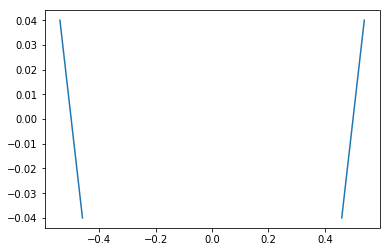

In [604]:
grid1D=GridHex(np.linspace(-1,1,101))
y=grid1D.X**2-0.25
reinit1D=ReinitializeFMM(grid1D,y,extend={"xl":[(-0.5,),(0.5,)],"Fl":[[-1,1],]})
#reinit1D.Fext=[grid1D.X.copy(),]
grid1D.plot(reinit1D.T)

In [605]:
reinit1D.loop(vstop=0.5)

(-1.1, 1.1, -1.1, 1.1)

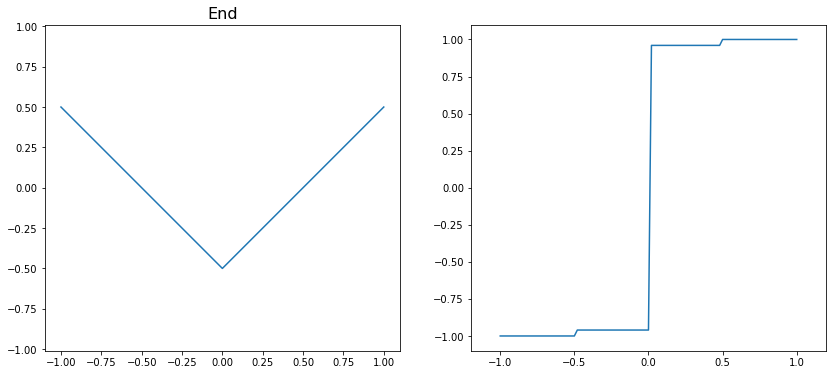

In [606]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
grid1D.plot(reinit1D.T)
plt.title('End',fontsize=16)
plt.axis('equal')
plt.subplot(1,2,2)
grid1D.plot(reinit1D.Fext[0])
plt.title('',fontsize=16)
plt.axis('equal')

### 2D FMM

In [593]:
ch.setLevel(logging.WARN)

In [607]:
grid2D=GridHex(np.linspace(-1,1,21),np.linspace(-1,1,21))
phi=grid2D.X**2+grid2D.Y**2-0.25
xl=[(0.5*np.cos(theta),0.5*np.sin(theta)) for theta in np.linspace(0,2*np.pi,101)]
Fl=[[x for x,y in xl],[y for x,y in xl]]
reinit2D=ReinitializeFMM(grid2D,phi,extend={"xl":xl,"Fl":Fl})
#reinit2D.Fext=[reinit2D.grid.X.copy(),reinit2D.grid.Y.copy()]

C:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in double_scalars


(-1.0, 1.0, -1.0, 1.0)

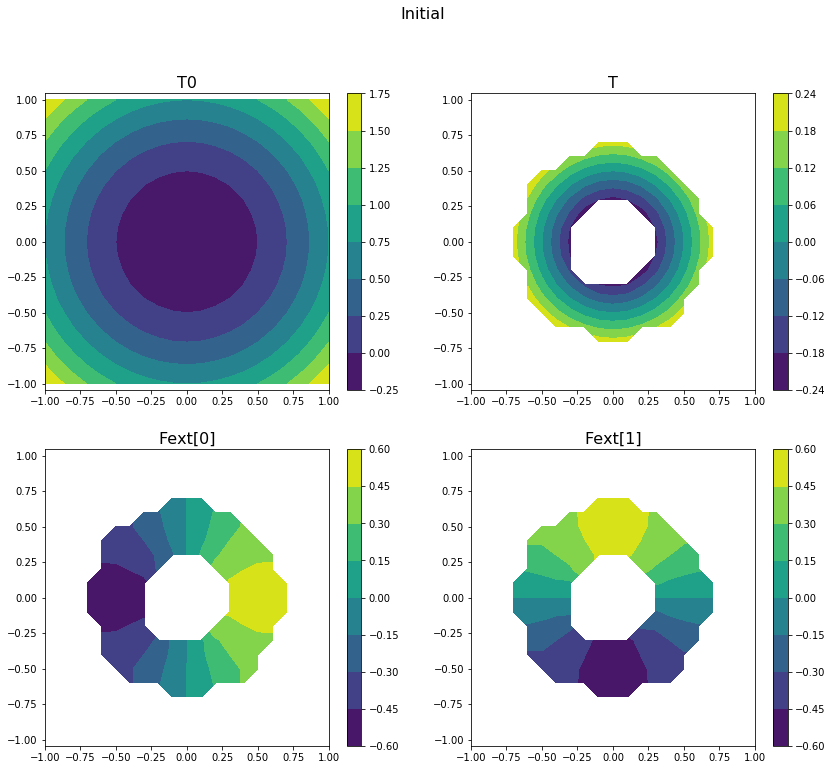

In [608]:
plt.figure(figsize=(14,12))
plt.suptitle('Initial',fontsize=16)
plt.subplot(2,2,1)
grid2D.plot(reinit2D.T0)
plt.title('T0',fontsize=16)
plt.axis('equal')
plt.subplot(2,2,2)
grid2D.plot(reinit2D.T)
plt.title('T',fontsize=16)
plt.axis('equal')
plt.subplot(2,2,3)
grid2D.plot(reinit2D.Fext[0])
plt.title('Fext[0]',fontsize=16)
plt.axis('equal')
plt.subplot(2,2,4)
grid2D.plot(reinit2D.Fext[1])
plt.title('Fext[1]',fontsize=16)
plt.axis('equal')

In [609]:
reinit2D.loop(vstop=1.0)

(-1.0, 1.0, -1.0, 1.0)

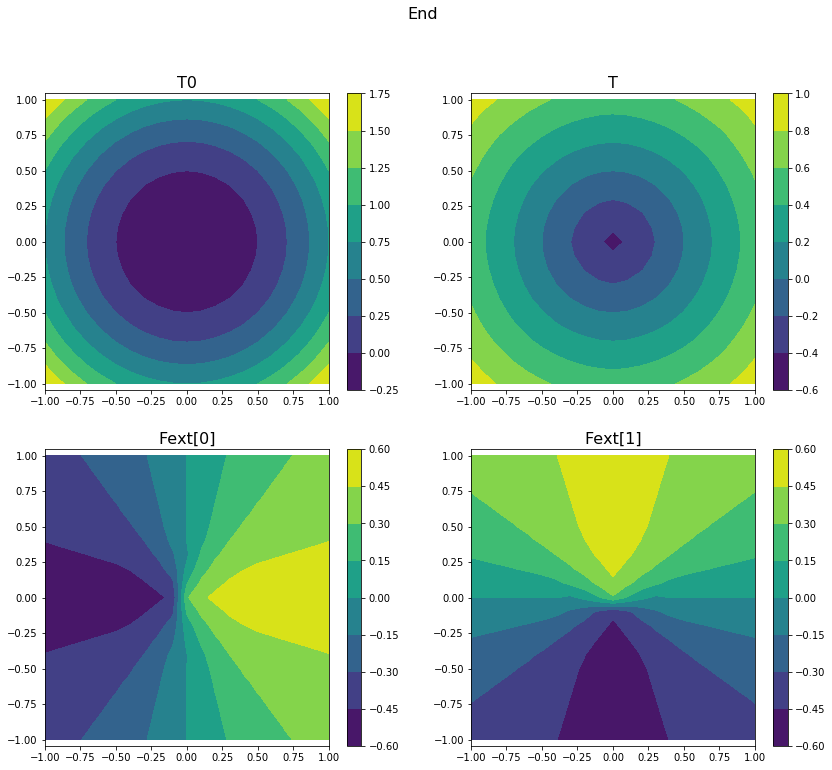

In [610]:
plt.figure(figsize=(14,12))
plt.suptitle('End',fontsize=16)
plt.subplot(2,2,1)
grid2D.plot(reinit2D.T0)
plt.title('T0',fontsize=16)
plt.axis('equal')
plt.subplot(2,2,2)
grid2D.plot(reinit2D.T)
plt.title('T',fontsize=16)
plt.axis('equal')
plt.subplot(2,2,3)
grid2D.plot(reinit2D.Fext[0])
plt.title('Fext[0]',fontsize=16)
plt.axis('equal')
plt.subplot(2,2,4)
grid2D.plot(reinit2D.Fext[1])
plt.title('Fext[1]',fontsize=16)
plt.axis('equal')


C:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
C:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


0.9181298830484838

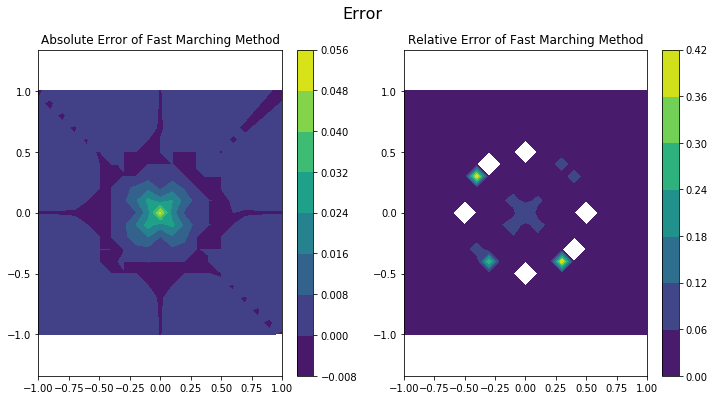

In [612]:
#reinit2D.loop(vstop=0.2)
plt.figure(figsize=(12,6))

plt.suptitle('Error',fontsize=16)
Z=reinit2D.T
Z0=np.sqrt(reinit2D.T0+0.25)-np.sqrt(0.25)
plt.subplot(1,2,1)
grid2D.plot(np.where(reinit2D.Status==1,Z-Z0,np.inf),title='Absolute Error of Fast Marching Method')
plt.axis('equal')
plt.subplot(1,2,2)
grid2D.plot(np.where(reinit2D.Status!=0,np.abs((Z-Z0)/Z0),np.inf),title='Relative Error of Fast Marching Method')
plt.axis('equal')
np.amax(Z[reinit2D.Status==1])

In [613]:
index=(8,9)
cof=reinit2D.cubicCoff(index)
print(index,reinit2D.voxelValues(index,reinit2D.Status),
      reinit2D.voxelValues(index,reinit2D.T0),
      reinit2D.voxelValues(index,reinit2D.T),cof,sep='\n')
vl=reinit2D.voxelValues(index)
points=reinit2D.voxelPoints(index)
for point in points:
    crd=reinit2D.pointCoord(point)
    print(crd,reinit2D.cubicInterpolation(cof,index,crd))

(8, 9)
[[1. 1.]
 [1. 1.]]
[[-0.2  -0.21]
 [-0.23 -0.24]]
[[-0.26060908 -0.29265328]
 [-0.33131976 -0.38000288]]
[[-2.00000000e-01 -2.00000000e-02  1.00000000e-02 -5.55111512e-17]
 [-4.00000000e-02  0.00000000e+00 -2.77555756e-17  1.38777878e-17]
 [ 1.00000000e-02  0.00000000e+00  2.42861287e-16 -2.15105711e-16]
 [ 3.46944695e-17  0.00000000e+00 -2.27595720e-16  1.02695630e-16]]
[-0.19999999999999996, -0.09999999999999998] (-0.2, (-0.3999999999999998, -0.19999999999999996))
[-0.19999999999999996, 0.0] (-0.21000000000000005, (-0.39999999999999997, -1.387778780781446e-15))
[-0.09999999999999998, -0.09999999999999998] (-0.22999999999999998, (-0.1999999999999994, -0.19999999999999996))
[-0.09999999999999998, 0.0] (-0.24000000000000013, (-0.20000000000000273, -4.5796699765787715e-15))


### 3D FMM

In [600]:
grid3D=GridHex(np.linspace(-1,1,21),np.linspace(-1,1,21),np.linspace(-1,1,21))
phi=grid3D.X**2+grid3D.Y**2+grid3D.Z**2-3*0.5**2
reinit3D=ReinitializeFMM(grid3D,phi)

[-0.25 -0.14 -0.18 -0.07 -0.16 -0.05 -0.09  0.02]
[0.40000000000000013, 0.30000000000000004, 0.5] (-0.2499999999999999, (0.8000000000000003, 0.6000000000000008, 0.9999999999999999))
[0.40000000000000013, 0.30000000000000004, 0.6000000000000001] (-0.13999999999999974, (0.8000000000000003, 0.6000000000000008, 1.2000000000000026))
[0.40000000000000013, 0.40000000000000013, 0.5] (-0.17999999999999972, (0.8000000000000003, 0.8000000000000003, 1.0000000000000009))
[0.40000000000000013, 0.40000000000000013, 0.6000000000000001] (-0.06999999999999978, (0.8000000000000003, 0.7999999999999967, 1.1999999999999988))
[0.5, 0.30000000000000004, 0.5] (-0.15999999999999992, (1.0000000000000002, 0.6000000000000008, 1.0000000000000009))
[0.5, 0.30000000000000004, 0.6000000000000001] (-0.05000000000000002, (0.999999999999995, 0.6000000000000011, 1.199999999999997))
[0.5, 0.40000000000000013, 0.5] (-0.08999999999999994, (0.9999999999999978, 0.7999999999999984, 1.0000000000000004))
[0.5, 0.40000000000000013

In [601]:
index=(14,13,15)
cof=reinit3D.cubicCoff(index)
vl=reinit3D.voxelValues(index)
points=reinit3D.voxelPoints(index)
print(vl.flatten())
for point in points:
    crd=reinit3D.pointCoord(point)
    print(crd,reinit3D.cubicInterpolation(cof,index,crd))

[-0.25 -0.14 -0.18 -0.07 -0.16 -0.05 -0.09  0.02]
[0.40000000000000013, 0.30000000000000004, 0.5] (-0.2499999999999999, (0.8000000000000003, 0.6000000000000008, 0.9999999999999999))
[0.40000000000000013, 0.30000000000000004, 0.6000000000000001] (-0.13999999999999974, (0.8000000000000003, 0.6000000000000008, 1.2000000000000026))
[0.40000000000000013, 0.40000000000000013, 0.5] (-0.17999999999999972, (0.8000000000000003, 0.8000000000000003, 1.0000000000000009))
[0.40000000000000013, 0.40000000000000013, 0.6000000000000001] (-0.06999999999999978, (0.8000000000000003, 0.7999999999999967, 1.1999999999999988))
[0.5, 0.30000000000000004, 0.5] (-0.15999999999999992, (1.0000000000000002, 0.6000000000000008, 1.0000000000000009))
[0.5, 0.30000000000000004, 0.6000000000000001] (-0.05000000000000002, (0.999999999999995, 0.6000000000000011, 1.199999999999997))
[0.5, 0.40000000000000013, 0.5] (-0.08999999999999994, (0.9999999999999978, 0.7999999999999984, 1.0000000000000004))
[0.5, 0.40000000000000013

### 裂纹扩展

In [614]:
Nx,Ny=101,101
grid=GridHex(np.linspace(-1,1,Nx),np.linspace(-1,1,Ny))
index=(0,0)
X=np.empty_like(grid.X)
status=np.full((Nx,Ny),-1,dtype=np.int8)

theta=np.pi/4
cet=np.array([(seed[ind]+seed[ind+1])/2 for seed,ind in zip(grid.seeds,index)])
for i,j in product(*[range(2) for _ in range(2)]):
    ind1,ind2=index[0]+i,index[1]+j
    status[ind1,ind2]=1
    crd=np.array([seed[ind] for seed,ind in zip(grid.seeds,(ind1,ind2))])
    X[ind1,ind2]=np.dot(crd-cet,np.array([np.cos(theta),np.sin(theta)]))

fmm=FastMarching(grid,X,status=status)

In [615]:
fmm.loop(vstop=0.3)

C:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:149: RuntimeWarning: invalid value encountered in sqrt
2020-04-18 16:14:45,107 - FastMarching - WARNING - nan get in compute distance of index=(62, 28)
2020-04-18 16:14:45,109 - FastMarching - WARNING - nan get in compute distance of index=(62, 28)
2020-04-18 16:14:45,239 - FastMarching - WARNING - nan get in compute distance of index=(62, 29)
2020-04-18 16:14:45,241 - FastMarching - WARNING - nan get in compute distance of index=(62, 29)
2020-04-18 16:14:45,242 - FastMarching - WARNING - nan get in compute distance of index=(62, 31)
2020-04-18 16:14:45,244 - FastMarching - WARNING - nan get in compute distance of index=(62, 31)
2020-04-18 16:14:45,246 - FastMarching - WARNING - nan get in compute distance of index=(62, 33)
2020-04-18 16:14:45,250 - FastMarching - WARNING - nan get in compute distance of index=(62, 33)
2020-04-18 16:14:45,252 - FastMarching - WARNING - nan get in compute distance of index=(62, 37)
2020-04-18

2020-04-18 16:14:45,453 - FastMarching - WARNING - nan get in compute distance of index=(62, 37)
2020-04-18 16:14:45,456 - FastMarching - WARNING - nan get in compute distance of index=(62, 39)
2020-04-18 16:14:45,458 - FastMarching - WARNING - nan get in compute distance of index=(62, 37)
2020-04-18 16:14:45,460 - FastMarching - WARNING - nan get in compute distance of index=(62, 39)
2020-04-18 16:14:45,463 - FastMarching - WARNING - nan get in compute distance of index=(62, 46)
2020-04-18 16:14:45,465 - FastMarching - WARNING - nan get in compute distance of index=(62, 48)
2020-04-18 16:14:45,467 - FastMarching - WARNING - nan get in compute distance of index=(62, 46)
2020-04-18 16:14:45,469 - FastMarching - WARNING - nan get in compute distance of index=(62, 48)
2020-04-18 16:14:45,471 - FastMarching - WARNING - nan get in compute distance of index=(62, 51)
2020-04-18 16:14:45,475 - FastMarching - WARNING - nan get in compute distance of index=(62, 51)
2020-04-18 16:14:45,484 - Fast

2020-04-18 16:14:45,684 - FastMarching - WARNING - nan get in compute distance of index=(63, 20)
2020-04-18 16:14:45,687 - FastMarching - WARNING - nan get in compute distance of index=(63, 22)
2020-04-18 16:14:45,689 - FastMarching - WARNING - nan get in compute distance of index=(63, 20)
2020-04-18 16:14:45,691 - FastMarching - WARNING - nan get in compute distance of index=(63, 22)
2020-04-18 16:14:45,694 - FastMarching - WARNING - nan get in compute distance of index=(62, 39)
2020-04-18 16:14:45,696 - FastMarching - WARNING - nan get in compute distance of index=(62, 39)
2020-04-18 16:14:45,707 - FastMarching - WARNING - nan get in compute distance of index=(62, 46)
2020-04-18 16:14:45,710 - FastMarching - WARNING - nan get in compute distance of index=(62, 46)
2020-04-18 16:14:45,712 - FastMarching - WARNING - nan get in compute distance of index=(62, 48)
2020-04-18 16:14:45,716 - FastMarching - WARNING - nan get in compute distance of index=(62, 48)
2020-04-18 16:14:45,719 - Fast

2020-04-18 16:14:46,073 - FastMarching - WARNING - nan get in compute distance of index=(64, 45)
2020-04-18 16:14:46,076 - FastMarching - WARNING - nan get in compute distance of index=(64, 45)
2020-04-18 16:14:46,077 - FastMarching - WARNING - nan get in compute distance of index=(64, 50)
2020-04-18 16:14:46,079 - FastMarching - WARNING - nan get in compute distance of index=(64, 50)
2020-04-18 16:14:46,080 - FastMarching - WARNING - nan get in compute distance of index=(64, 61)
2020-04-18 16:14:46,083 - FastMarching - WARNING - nan get in compute distance of index=(64, 61)
2020-04-18 16:14:46,084 - FastMarching - WARNING - nan get in compute distance of index=(65, 19)
2020-04-18 16:14:46,085 - FastMarching - WARNING - nan get in compute distance of index=(65, 19)
2020-04-18 16:14:46,087 - FastMarching - WARNING - nan get in compute distance of index=(62, 28)
2020-04-18 16:14:46,089 - FastMarching - WARNING - nan get in compute distance of index=(64, 28)
2020-04-18 16:14:46,091 - Fast

2020-04-18 16:14:46,888 - FastMarching - WARNING - nan get in compute distance of index=(67, 28)
2020-04-18 16:14:46,891 - FastMarching - WARNING - nan get in compute distance of index=(67, 24)
2020-04-18 16:14:46,894 - FastMarching - WARNING - nan get in compute distance of index=(67, 24)
2020-04-18 16:14:47,021 - FastMarching - WARNING - nan get in compute distance of index=(67, 40)
2020-04-18 16:14:47,023 - FastMarching - WARNING - nan get in compute distance of index=(67, 40)
2020-04-18 16:14:47,044 - FastMarching - WARNING - nan get in compute distance of index=(67, 28)
2020-04-18 16:14:47,047 - FastMarching - WARNING - nan get in compute distance of index=(67, 28)
2020-04-18 16:14:47,063 - FastMarching - WARNING - nan get in compute distance of index=(67, 45)
2020-04-18 16:14:47,065 - FastMarching - WARNING - nan get in compute distance of index=(67, 45)
2020-04-18 16:14:47,102 - FastMarching - WARNING - nan get in compute distance of index=(68, 25)
2020-04-18 16:14:47,105 - Fast

2020-04-18 16:14:48,289 - FastMarching - WARNING - nan get in compute distance of index=(73, 46)
2020-04-18 16:14:48,291 - FastMarching - WARNING - nan get in compute distance of index=(73, 46)
2020-04-18 16:14:48,332 - FastMarching - WARNING - nan get in compute distance of index=(72, 41)
2020-04-18 16:14:48,335 - FastMarching - WARNING - nan get in compute distance of index=(72, 41)
2020-04-18 16:14:48,366 - FastMarching - WARNING - nan get in compute distance of index=(73, 27)
2020-04-18 16:14:48,371 - FastMarching - WARNING - nan get in compute distance of index=(73, 27)
2020-04-18 16:14:48,385 - FastMarching - WARNING - nan get in compute distance of index=(73, 28)
2020-04-18 16:14:48,386 - FastMarching - WARNING - nan get in compute distance of index=(73, 28)
2020-04-18 16:14:48,427 - FastMarching - WARNING - nan get in compute distance of index=(73, 42)
2020-04-18 16:14:48,432 - FastMarching - WARNING - nan get in compute distance of index=(73, 42)
2020-04-18 16:14:48,492 - Fast

(-1.0, 1.0, -1.0, 1.0)

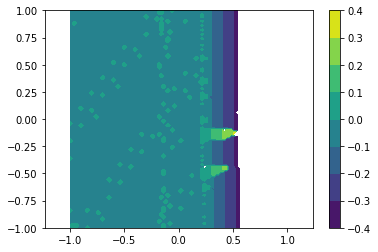

In [616]:
#plt.figure(figsize=(5,5))
grid.plot(fmm.T)
plt.axis('equal')

In [617]:
fmm.T[:4,:4]

array([[-0.01414214,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.01414214,  0.        ,  0.        ],
       [ 0.        ,  0.01931852,  0.        ,  0.        ],
       [ 0.        ,  0.01414214,  0.        ,  0.        ]])

In [618]:
np.sum(fmm.Status==0)

100

### 直裂纹

In [629]:
ch.setLevel(logging.DEBUG)

In [630]:
grid=GridHex(np.linspace(-1,1,21),np.linspace(-1,1,21))
exact=grid.Y-0.3
accept=np.logical_and(np.abs(exact)<0.11,grid.X<=0.)
fmm=FastMarching(grid,np.where(accept,exact,np.infty),
                 status=np.where(accept,1,-1))

2020-04-18 16:18:45,914 - FastMarching - DEBUG - index=(0, 11),t=-0.200000,equation=[[0, 0, 0, inf, inf], [1, -9.999999999999991, -0.9999999999999972, 0.10000000000000009, inf]],neibs=[(0, 12)],neib coffs=[[[1, -10.000000000000002, -0.9999999999999983, 0.09999999999999998, inf], [1, -10.000000000000014, 5.551115123125791e-16, 0.09999999999999987, inf]]]
2020-04-18 16:18:45,915 - FastMarching - DEBUG - a=100.000000,b=20.000000,c=-0.000000
2020-04-18 16:18:45,916 - FastMarching - INFO - f2n: index=(0, 11),coords=[-1.0, 0.10000000000000009],t=-0.200000,old t=inf
2020-04-18 16:18:45,918 - FastMarching - DEBUG - index=(0, 15),t=0.200000,equation=[[0, 0, 0, inf, inf], [-1, 10.000000000000014, -1.0000000000000029, 0.09999999999999987, inf]],neibs=[(0, 14)],neib coffs=[[[1, -10.000000000000002, 1.0000000000000018, 0.09999999999999998, inf], [-1, 9.999999999999991, -5.551115123125778e-16, 0.10000000000000009, inf]]]
2020-04-18 16:18:45,919 - FastMarching - DEBUG - a=100.000000,b=-20.000000,c=0.

2020-04-18 16:18:45,964 - FastMarching - INFO - f2n: index=(7, 11),coords=[-0.29999999999999993, 0.10000000000000009],t=-0.200000,old t=inf
2020-04-18 16:18:45,966 - FastMarching - DEBUG - index=(7, 15),t=0.200000,equation=[[0, 0, 0, inf, inf], [-1, 10.000000000000014, -1.0000000000000029, 0.09999999999999987, inf]],neibs=[(7, 14)],neib coffs=[[[-1, 10.000000000000002, -1.0000000000000018, 0.09999999999999998, inf], [-1, 9.999999999999991, -5.551115123125778e-16, 0.10000000000000009, inf]]]
2020-04-18 16:18:45,968 - FastMarching - DEBUG - a=100.000000,b=-20.000000,c=0.000000
2020-04-18 16:18:45,969 - FastMarching - INFO - f2n: index=(7, 15),coords=[-0.29999999999999993, 0.5],t=0.200000,old t=inf
2020-04-18 16:18:45,970 - FastMarching - DEBUG - index=(8, 11),t=-0.200000,equation=[[0, 0, 0, inf, inf], [1, -9.999999999999991, -0.9999999999999972, 0.10000000000000009, inf]],neibs=[(8, 12)],neib coffs=[[[-1, 10.000000000000002, 0.9999999999999983, 0.09999999999999998, inf], [1, -10.00000000

(-1.0, 1.0, -1.0, 1.0)

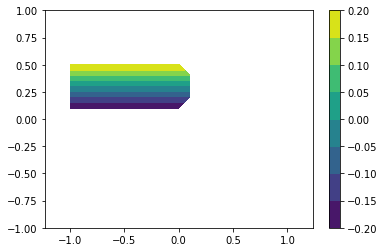

In [620]:
fmm.grid.plot(fmm.T)
plt.axis('equal')

In [631]:
fmm.loop(vstop=2.0)

2020-04-18 16:18:51,826 - FastMarching - INFO - n2k: index=(11, 13),coords=[0.10000000000000009, 0.30000000000000004],t=0.000000
2020-04-18 16:18:51,828 - FastMarching - DEBUG - index=(12, 13),t=0.100000,equation=[[-1, 9.999999999999991, -5.551115123125778e-16, 0.10000000000000009, inf], [0, 0, 0, inf, inf]],neibs=[(11, 13)],neib coffs=[[[-1, 9.999999999999991, -5.551115123125778e-16, 0.10000000000000009, inf], [0, 0, 0, inf, inf]]]
2020-04-18 16:18:51,829 - FastMarching - DEBUG - a=100.000000,b=-0.000000,c=-1.000000
2020-04-18 16:18:51,830 - FastMarching - INFO - f2n: index=(12, 13),coords=[0.20000000000000018, 0.30000000000000004],t=0.100000,old t=inf
2020-04-18 16:18:51,831 - FastMarching - DEBUG - index=(11, 12),t=-0.100000,equation=[[-1, 9.999999999999991, 0.9999999999999972, 0.10000000000000009, inf], [1, -10.000000000000014, 5.551115123125791e-16, 0.09999999999999987, inf]],neibs=[(10, 12), (11, 13)],neib coffs=[[[-1, 10.000000000000002, 0.9999999999999983, 0.09999999999999998, 

2020-04-18 16:18:51,872 - FastMarching - DEBUG - a=100.000000,b=20.000000,c=-0.000000
2020-04-18 16:18:51,873 - FastMarching - DEBUG - index=(12, 13),t=-0.100000,equation=[[-1, 9.999999999999991, -5.551115123125778e-16, 0.10000000000000009, inf], [-1, 10.000000000000014, 0.9999999999999993, 0.09999999999999987, inf]],neibs=[(11, 13), (12, 12)],neib coffs=[[[-1, 9.999999999999991, -5.551115123125778e-16, 0.10000000000000009, inf], [-1, 10.000000000000014, 0.9999999999999993, 0.09999999999999987, inf]], [[-1, 9.999999999999991, 0.9999999999999971, 0.10000000000000009, inf], [0, 0, 0, inf, inf]]]
2020-04-18 16:18:51,874 - FastMarching - DEBUG - a=200.000000,b=20.000000,c=-0.000000
2020-04-18 16:18:51,875 - FastMarching - INFO - n2k: index=(12, 13),coords=[0.20000000000000018, 0.30000000000000004],t=-0.100000
2020-04-18 16:18:51,877 - FastMarching - DEBUG - index=(13, 13),t=-0.200000,equation=[[-1, 10.000000000000014, 1.0000000000000018, 0.09999999999999987, inf], [0, 0, 0, inf, inf]],neib

2020-04-18 16:18:51,919 - FastMarching - DEBUG - a=100.000000,b=40.000000,c=4.000000
2020-04-18 16:18:51,920 - FastMarching - INFO - f2n: index=(13, 11),coords=[0.30000000000000004, 0.10000000000000009],t=-0.200000,old t=inf
2020-04-18 16:18:51,921 - FastMarching - DEBUG - index=(13, 13),t=-0.200000,equation=[[-1, 10.000000000000014, 1.0000000000000018, 0.09999999999999987, inf], [-1, 10.000000000000014, 1.9999999999999991, 0.09999999999999987, inf]],neibs=[(12, 13), (13, 12)],neib coffs=[[[-1, 9.999999999999991, -5.551115123125778e-16, 0.10000000000000009, inf], [1, -9.999999999999991, -0.9999999999999994, 0.10000000000000009, inf]], [[-1, 10.000000000000014, 0.9999999999999993, 0.09999999999999987, inf], [0, 0, 0, inf, inf]]]
2020-04-18 16:18:51,922 - FastMarching - DEBUG - a=200.000000,b=60.000000,c=4.000000
2020-04-18 16:18:51,922 - FastMarching - INFO - f2n: index=(13, 13),coords=[0.30000000000000004, 0.30000000000000004],t=-0.200000,old t=-0.200000
2020-04-18 16:18:51,924 - FastM

2020-04-18 16:18:51,962 - FastMarching - DEBUG - a=200.000000,b=60.000000,c=4.000000
2020-04-18 16:18:51,963 - FastMarching - INFO - f2n: index=(1, 11),coords=[-0.9, 0.10000000000000009],t=-0.200000,old t=-0.200000
2020-04-18 16:18:51,964 - FastMarching - DEBUG - index=(0, 10),t=-0.300000,equation=[[0, 0, 0, inf, inf], [1, -9.999999999999991, -1.999999999999997, 0.10000000000000009, inf]],neibs=[(0, 11)],neib coffs=[[[0, 0, 0, inf, inf], [1, -9.999999999999991, -0.9999999999999972, 0.10000000000000009, inf]]]
2020-04-18 16:18:51,965 - FastMarching - DEBUG - a=100.000000,b=40.000000,c=3.000000
2020-04-18 16:18:51,966 - FastMarching - INFO - f2n: index=(0, 10),coords=[-1.0, 0.0],t=-0.300000,old t=inf
2020-04-18 16:18:51,967 - FastMarching - DEBUG - index=(1, 11),t=-0.200000,equation=[[-1, 10.000000000000002, 1.9999999999999991, 0.09999999999999998, inf], [1, -9.999999999999991, -0.9999999999999972, 0.10000000000000009, inf]],neibs=[(0, 11), (1, 12)],neib coffs=[[[0, 0, 0, inf, inf], [1, 

2020-04-18 16:18:52,006 - FastMarching - DEBUG - a=200.000000,b=60.000000,c=4.000000
2020-04-18 16:18:52,007 - FastMarching - DEBUG - index=(3, 10),t=-0.300000,equation=[[0, 0, 0, inf, inf], [1, -9.999999999999991, -1.9999999999999964, 0.10000000000000009, inf]],neibs=[(3, 11)],neib coffs=[[[-1, 9.999999999999991, 1.9999999999999958, 0.10000000000000009, inf], [1, -9.999999999999991, -0.9999999999999972, 0.10000000000000009, inf]]]
2020-04-18 16:18:52,008 - FastMarching - DEBUG - a=100.000000,b=40.000000,c=3.000000
2020-04-18 16:18:52,009 - FastMarching - INFO - n2k: index=(4, 11),coords=[-0.6, 0.10000000000000009],t=-0.200000
2020-04-18 16:18:52,010 - FastMarching - DEBUG - index=(5, 11),t=-0.200000,equation=[[-1, 10.000000000000002, 1.999999999999998, 0.09999999999999998, inf], [1, -9.999999999999991, -0.9999999999999972, 0.10000000000000009, inf]],neibs=[(4, 11), (5, 12)],neib coffs=[[[-1, 10.000000000000002, 1.9999999999999987, 0.09999999999999998, inf], [1, -9.999999999999991, -0.

2020-04-18 16:18:52,046 - FastMarching - DEBUG - index=(8, 11),t=-0.200000,equation=[[-1, 10.000000000000002, 1.999999999999998, 0.09999999999999998, inf], [1, -9.999999999999991, -0.9999999999999972, 0.10000000000000009, inf]],neibs=[(7, 11), (8, 12)],neib coffs=[[[-1, 10.000000000000002, 1.9999999999999987, 0.09999999999999998, inf], [1, -9.999999999999991, -0.9999999999999972, 0.10000000000000009, inf]], [[-1, 10.000000000000002, 0.9999999999999983, 0.09999999999999998, inf], [1, -10.000000000000014, 5.551115123125791e-16, 0.09999999999999987, inf]]]
2020-04-18 16:18:52,047 - FastMarching - DEBUG - a=200.000000,b=60.000000,c=4.000000
2020-04-18 16:18:52,048 - FastMarching - INFO - f2n: index=(8, 11),coords=[-0.19999999999999996, 0.10000000000000009],t=-0.200000,old t=-0.200000
2020-04-18 16:18:52,049 - FastMarching - DEBUG - index=(7, 10),t=-0.300000,equation=[[0, 0, 0, inf, inf], [1, -9.999999999999991, -1.9999999999999958, 0.10000000000000009, inf]],neibs=[(7, 11)],neib coffs=[[[-

2020-04-18 16:18:52,082 - FastMarching - DEBUG - a=200.000000,b=60.000000,c=4.000000
2020-04-18 16:18:52,083 - FastMarching - INFO - f2n: index=(11, 11),coords=[0.10000000000000009, 0.10000000000000009],t=-0.200000,old t=-0.200000
2020-04-18 16:18:52,084 - FastMarching - DEBUG - index=(10, 10),t=-0.300000,equation=[[0, 0, 0, inf, inf], [1, -9.999999999999991, -1.9999999999999958, 0.10000000000000009, inf]],neibs=[(10, 11)],neib coffs=[[[-1, 10.000000000000002, 1.999999999999998, 0.09999999999999998, inf], [1, -9.999999999999991, -0.9999999999999972, 0.10000000000000009, inf]]]
2020-04-18 16:18:52,085 - FastMarching - DEBUG - a=100.000000,b=40.000000,c=3.000000
2020-04-18 16:18:52,086 - FastMarching - INFO - f2n: index=(10, 10),coords=[0.0, 0.0],t=-0.300000,old t=inf
2020-04-18 16:18:52,088 - FastMarching - DEBUG - index=(11, 11),t=-0.200000,equation=[[-1, 9.999999999999991, 1.9999999999999958, 0.10000000000000009, inf], [1, -9.999999999999991, -0.9999999999999971, 0.10000000000000009, 

2020-04-18 16:18:52,129 - FastMarching - DEBUG - a=100.000000,b=40.000000,c=3.000000
2020-04-18 16:18:52,131 - FastMarching - INFO - f2n: index=(12, 10),coords=[0.20000000000000018, 0.0],t=-0.300000,old t=inf
2020-04-18 16:18:52,132 - FastMarching - DEBUG - index=(12, 10),t=-0.300000,equation=[[0, 0, 0, inf, inf], [1, -9.999999999999991, -1.9999999999999973, 0.10000000000000009, inf]],neibs=[(12, 11)],neib coffs=[[[-1, 9.999999999999991, 1.9999999999999967, 0.10000000000000009, inf], [1, -9.999999999999991, -0.9999999999999971, 0.10000000000000009, inf]]]
2020-04-18 16:18:52,133 - FastMarching - DEBUG - a=100.000000,b=40.000000,c=3.000000
2020-04-18 16:18:52,134 - FastMarching - INFO - n2k: index=(12, 15),coords=[0.20000000000000018, 0.5],t=-0.200000
2020-04-18 16:18:52,135 - FastMarching - DEBUG - index=(13, 15),t=-0.200000,equation=[[-1, 10.000000000000014, 2.0000000000000018, 0.09999999999999987, inf], [0, 0, 0, inf, inf]],neibs=[(12, 15)],neib coffs=[[[-1, 9.999999999999991, 1.9999

2020-04-18 16:18:52,186 - FastMarching - DEBUG - a=100.000000,b=-40.000000,c=3.000000
2020-04-18 16:18:52,187 - FastMarching - INFO - f2n: index=(0, 16),coords=[-1.0, 0.6000000000000001],t=0.300000,old t=inf
2020-04-18 16:18:52,189 - FastMarching - DEBUG - index=(1, 15),t=0.200000,equation=[[-1, 10.000000000000002, -2.0000000000000004, 0.09999999999999998, inf], [-1, 10.000000000000014, -1.0000000000000029, 0.09999999999999987, inf]],neibs=[(0, 15), (1, 14)],neib coffs=[[[0, 0, 0, inf, inf], [-1, 10.000000000000014, -1.0000000000000029, 0.09999999999999987, inf]], [[-1, 10.000000000000002, -1.0000000000000018, 0.09999999999999998, inf], [-1, 9.999999999999991, -5.551115123125778e-16, 0.10000000000000009, inf]]]
2020-04-18 16:18:52,190 - FastMarching - DEBUG - a=200.000000,b=-60.000000,c=4.000000
2020-04-18 16:18:52,191 - FastMarching - DEBUG - index=(0, 16),t=0.300000,equation=[[0, 0, 0, inf, inf], [-1, 9.999999999999991, -1.9999999999999984, 0.10000000000000009, inf]],neibs=[(0, 15)],

2020-04-18 16:18:52,234 - FastMarching - DEBUG - index=(3, 16),t=0.300000,equation=[[0, 0, 0, inf, inf], [-1, 9.999999999999991, -1.9999999999999978, 0.10000000000000009, inf]],neibs=[(3, 15)],neib coffs=[[[-1, 9.999999999999991, -1.999999999999998, 0.10000000000000009, inf], [-1, 10.000000000000014, -1.0000000000000029, 0.09999999999999987, inf]]]
2020-04-18 16:18:52,347 - FastMarching - DEBUG - a=100.000000,b=-40.000000,c=3.000000
2020-04-18 16:18:52,348 - FastMarching - INFO - n2k: index=(4, 15),coords=[-0.6, 0.5],t=0.200000
2020-04-18 16:18:52,350 - FastMarching - DEBUG - index=(5, 15),t=0.200000,equation=[[-1, 10.000000000000002, -2.0000000000000004, 0.09999999999999998, inf], [-1, 10.000000000000014, -1.0000000000000029, 0.09999999999999987, inf]],neibs=[(4, 15), (5, 14)],neib coffs=[[[-1, 10.000000000000002, -2.0, 0.09999999999999998, inf], [-1, 10.000000000000014, -1.0000000000000029, 0.09999999999999987, inf]], [[1, -9.999999999999991, 1.0000000000000004, 0.10000000000000009, 

2020-04-18 16:18:52,386 - FastMarching - DEBUG - a=200.000000,b=-60.000000,c=4.000000
2020-04-18 16:18:52,387 - FastMarching - INFO - f2n: index=(8, 15),coords=[-0.19999999999999996, 0.5],t=0.200000,old t=0.200000
2020-04-18 16:18:52,388 - FastMarching - DEBUG - index=(7, 16),t=0.300000,equation=[[0, 0, 0, inf, inf], [-1, 9.999999999999991, -1.9999999999999978, 0.10000000000000009, inf]],neibs=[(7, 15)],neib coffs=[[[-1, 10.000000000000002, -2.0000000000000004, 0.09999999999999998, inf], [-1, 10.000000000000014, -1.0000000000000029, 0.09999999999999987, inf]]]
2020-04-18 16:18:52,389 - FastMarching - DEBUG - a=100.000000,b=-40.000000,c=3.000000
2020-04-18 16:18:52,390 - FastMarching - INFO - f2n: index=(7, 16),coords=[-0.29999999999999993, 0.6000000000000001],t=0.300000,old t=inf
2020-04-18 16:18:52,391 - FastMarching - DEBUG - index=(8, 15),t=0.200000,equation=[[-1, 10.000000000000002, -2.0, 0.09999999999999998, inf], [-1, 10.000000000000014, -1.0000000000000029, 0.09999999999999987, 

2020-04-18 16:18:52,430 - FastMarching - DEBUG - index=(12, 10),t=-0.300000,equation=[[1, -10.000000000000014, -3.0000000000000004, 0.09999999999999987, inf], [1, -9.999999999999991, -1.9999999999999973, 0.10000000000000009, inf]],neibs=[(13, 10), (12, 11)],neib coffs=[[[0, 0, 0, inf, inf], [1, -9.999999999999991, -1.9999999999999944, 0.10000000000000009, inf]], [[-1, 9.999999999999991, 1.9999999999999967, 0.10000000000000009, inf], [1, -9.999999999999991, -0.9999999999999971, 0.10000000000000009, inf]]]
2020-04-18 16:18:52,431 - FastMarching - DEBUG - a=200.000000,b=100.000000,c=12.000000
2020-04-18 16:18:52,432 - FastMarching - INFO - f2n: index=(12, 10),coords=[0.20000000000000018, 0.0],t=-0.300000,old t=-0.300000
2020-04-18 16:18:52,433 - FastMarching - DEBUG - index=(14, 10),t=-0.300000,equation=[[-1, 9.999999999999991, 2.999999999999994, 0.10000000000000009, inf], [0, 0, 0, inf, inf]],neibs=[(13, 10)],neib coffs=[[[0, 0, 0, inf, inf], [1, -9.999999999999991, -1.9999999999999944, 

2020-04-18 16:18:52,479 - FastMarching - DEBUG - index=(14, 12),t=-0.300000,equation=[[-1, 9.999999999999991, 1.9999999999999947, 0.10000000000000009, inf], [-1, 9.999999999999991, 2.9999999999999916, 0.10000000000000009, inf]],neibs=[(13, 12), (14, 11)],neib coffs=[[[-1, 10.000000000000014, 0.9999999999999993, 0.09999999999999987, inf], [1, -10.000000000000014, -2.0000000000000013, 0.09999999999999987, inf]], [[-1, 9.999999999999991, 1.9999999999999944, 0.10000000000000009, inf], [-1, 9.999999999999991, 2.9999999999999933, 0.10000000000000009, inf]]]
2020-04-18 16:18:52,480 - FastMarching - DEBUG - a=200.000000,b=100.000000,c=12.000000
2020-04-18 16:18:52,481 - FastMarching - INFO - n2k: index=(14, 12),coords=[0.40000000000000013, 0.20000000000000018],t=-0.300000
2020-04-18 16:18:52,482 - FastMarching - DEBUG - index=(15, 12),t=-0.400000,equation=[[-1, 10.000000000000014, 2.9999999999999987, 0.09999999999999987, inf], [0, 0, 0, inf, inf]],neibs=[(14, 12)],neib coffs=[[[-1, 9.999999999

2020-04-18 16:18:52,522 - FastMarching - DEBUG - a=200.000000,b=100.000000,c=12.000000
2020-04-18 16:18:52,523 - FastMarching - DEBUG - index=(3, 9),t=-0.400000,equation=[[0, 0, 0, inf, inf], [1, -10.000000000000002, -2.9999999999999982, 0.09999999999999998, inf]],neibs=[(3, 10)],neib coffs=[[[-1, 9.999999999999991, 2.9999999999999956, 0.10000000000000009, inf], [1, -9.999999999999991, -1.9999999999999964, 0.10000000000000009, inf]]]
2020-04-18 16:18:52,524 - FastMarching - DEBUG - a=100.000000,b=60.000000,c=8.000000
2020-04-18 16:18:52,525 - FastMarching - INFO - n2k: index=(4, 10),coords=[-0.6, 0.0],t=-0.300000
2020-04-18 16:18:52,528 - FastMarching - DEBUG - index=(5, 10),t=-0.300000,equation=[[-1, 10.000000000000002, 2.999999999999998, 0.09999999999999998, inf], [1, -9.999999999999991, -1.9999999999999958, 0.10000000000000009, inf]],neibs=[(4, 10), (5, 11)],neib coffs=[[[-1, 10.000000000000002, 2.9999999999999982, 0.09999999999999998, inf], [1, -9.999999999999991, -1.99999999999999

2020-04-18 16:18:52,568 - FastMarching - DEBUG - a=200.000000,b=100.000000,c=12.000000
2020-04-18 16:18:52,570 - FastMarching - DEBUG - index=(7, 9),t=-0.400000,equation=[[0, 0, 0, inf, inf], [1, -10.000000000000002, -2.9999999999999987, 0.09999999999999998, inf]],neibs=[(7, 10)],neib coffs=[[[0, 0, 0, inf, inf], [1, -9.999999999999991, -1.9999999999999958, 0.10000000000000009, inf]]]
2020-04-18 16:18:52,571 - FastMarching - DEBUG - a=100.000000,b=60.000000,c=8.000000
2020-04-18 16:18:52,572 - FastMarching - INFO - n2k: index=(8, 10),coords=[-0.19999999999999996, 0.0],t=-0.300000
2020-04-18 16:18:52,573 - FastMarching - DEBUG - index=(9, 10),t=-0.300000,equation=[[-1, 10.000000000000002, 2.9999999999999964, 0.09999999999999998, inf], [1, -9.999999999999991, -1.9999999999999958, 0.10000000000000009, inf]],neibs=[(8, 10), (9, 11)],neib coffs=[[[-1, 10.000000000000002, 2.9999999999999987, 0.09999999999999998, inf], [1, -9.999999999999991, -1.9999999999999958, 0.10000000000000009, inf]], [

2020-04-18 16:18:52,794 - FastMarching - DEBUG - a=200.000000,b=100.000000,c=12.000000
2020-04-18 16:18:52,795 - FastMarching - INFO - f2n: index=(11, 10),coords=[0.10000000000000009, 0.0],t=-0.300000,old t=-0.300000
2020-04-18 16:18:52,797 - FastMarching - DEBUG - index=(12, 9),t=-0.400000,equation=[[0, 0, 0, inf, inf], [1, -10.000000000000002, -2.9999999999999987, 0.09999999999999998, inf]],neibs=[(12, 10)],neib coffs=[[[1, -10.000000000000014, -3.0000000000000004, 0.09999999999999987, inf], [1, -9.999999999999991, -1.9999999999999973, 0.10000000000000009, inf]]]
2020-04-18 16:18:52,798 - FastMarching - DEBUG - a=100.000000,b=60.000000,c=8.000000
2020-04-18 16:18:52,798 - FastMarching - INFO - f2n: index=(12, 9),coords=[0.20000000000000018, -0.09999999999999998],t=-0.400000,old t=inf
2020-04-18 16:18:52,800 - FastMarching - DEBUG - index=(11, 10),t=-0.300000,equation=[[1, -9.999999999999991, -2.9999999999999956, 0.10000000000000009, inf], [1, -9.999999999999991, -1.9999999999999967, 

2020-04-18 16:18:52,843 - FastMarching - DEBUG - a=100.000000,b=60.000000,c=8.000000
2020-04-18 16:18:52,844 - FastMarching - INFO - f2n: index=(0, 9),coords=[-1.0, -0.09999999999999998],t=-0.400000,old t=inf
2020-04-18 16:18:52,845 - FastMarching - DEBUG - index=(0, 9),t=-0.400000,equation=[[0, 0, 0, inf, inf], [1, -10.000000000000002, -2.9999999999999973, 0.09999999999999998, inf]],neibs=[(0, 10)],neib coffs=[[[1, -10.000000000000002, -2.9999999999999996, 0.09999999999999998, inf], [1, -9.999999999999991, -1.999999999999997, 0.10000000000000009, inf]]]
2020-04-18 16:18:52,847 - FastMarching - DEBUG - a=100.000000,b=60.000000,c=8.000000
2020-04-18 16:18:52,848 - FastMarching - INFO - n2k: index=(6, 10),coords=[-0.3999999999999999, 0.0],t=-0.300000
2020-04-18 16:18:52,849 - FastMarching - DEBUG - index=(6, 9),t=-0.400000,equation=[[0, 0, 0, inf, inf], [1, -10.000000000000002, -2.9999999999999996, 0.09999999999999998, inf]],neibs=[(6, 10)],neib coffs=[[[1, -10.000000000000002, -2.999999

2020-04-18 16:18:52,891 - FastMarching - DEBUG - a=200.000000,b=100.000000,c=12.000000
2020-04-18 16:18:52,892 - FastMarching - DEBUG - index=(12, 17),t=-0.400000,equation=[[0, 0, 0, inf, inf], [-1, 9.999999999999991, 2.999999999999997, 0.10000000000000009, inf]],neibs=[(12, 16)],neib coffs=[[[-1, 9.999999999999991, 2.9999999999999973, 0.10000000000000009, inf], [-1, 9.999999999999991, 1.9999999999999973, 0.10000000000000009, inf]]]
2020-04-18 16:18:52,893 - FastMarching - DEBUG - a=100.000000,b=60.000000,c=8.000000
2020-04-18 16:18:52,894 - FastMarching - INFO - f2n: index=(12, 17),coords=[0.20000000000000018, 0.7000000000000002],t=-0.400000,old t=inf
2020-04-18 16:18:52,896 - FastMarching - DEBUG - index=(13, 16),t=-0.300000,equation=[[-1, 10.000000000000014, 3.0000000000000036, 0.09999999999999987, inf], [-1, 9.999999999999991, 1.9999999999999973, 0.10000000000000009, inf]],neibs=[(12, 16), (13, 15)],neib coffs=[[[-1, 9.999999999999991, 2.9999999999999973, 0.10000000000000009, inf],

2020-04-18 16:18:52,938 - FastMarching - DEBUG - a=100.000000,b=60.000000,c=8.000000
2020-04-18 16:18:52,938 - FastMarching - INFO - n2k: index=(2, 16),coords=[-0.8, 0.6000000000000001],t=0.300000
2020-04-18 16:18:52,940 - FastMarching - DEBUG - index=(1, 16),t=0.300000,equation=[[1, -10.000000000000002, 3.0000000000000004, 0.09999999999999998, inf], [-1, 9.999999999999991, -1.9999999999999978, 0.10000000000000009, inf]],neibs=[(2, 16), (1, 15)],neib coffs=[[[0, 0, 0, inf, inf], [-1, 9.999999999999991, -1.999999999999998, 0.10000000000000009, inf]], [[-1, 10.000000000000002, -2.0000000000000004, 0.09999999999999998, inf], [-1, 10.000000000000014, -1.0000000000000029, 0.09999999999999987, inf]]]
2020-04-18 16:18:52,941 - FastMarching - DEBUG - a=200.000000,b=-100.000000,c=12.000000
2020-04-18 16:18:52,941 - FastMarching - INFO - f2n: index=(1, 16),coords=[-0.9, 0.6000000000000001],t=0.300000,old t=0.300000
2020-04-18 16:18:52,943 - FastMarching - DEBUG - index=(3, 16),t=0.300000,equatio

2020-04-18 16:18:52,990 - FastMarching - DEBUG - a=200.000000,b=-100.000000,c=12.000000
2020-04-18 16:18:52,991 - FastMarching - DEBUG - index=(5, 16),t=0.300000,equation=[[-1, 10.000000000000002, -3.0000000000000004, 0.09999999999999998, inf], [-1, 9.999999999999991, -1.9999999999999978, 0.10000000000000009, inf]],neibs=[(4, 16), (5, 15)],neib coffs=[[[0, 0, 0, inf, inf], [-1, 9.999999999999991, -1.999999999999998, 0.10000000000000009, inf]], [[1, -9.999999999999991, 1.999999999999998, 0.10000000000000009, inf], [-1, 10.000000000000014, -1.0000000000000029, 0.09999999999999987, inf]]]
2020-04-18 16:18:52,992 - FastMarching - DEBUG - a=200.000000,b=-100.000000,c=12.000000
2020-04-18 16:18:52,993 - FastMarching - DEBUG - index=(4, 17),t=0.400000,equation=[[0, 0, 0, inf, inf], [-1, 9.999999999999991, -2.9999999999999973, 0.10000000000000009, inf]],neibs=[(4, 16)],neib coffs=[[[0, 0, 0, inf, inf], [-1, 9.999999999999991, -1.999999999999998, 0.10000000000000009, inf]]]
2020-04-18 16:18:52,

2020-04-18 16:18:53,205 - FastMarching - DEBUG - index=(7, 16),t=0.300000,equation=[[-1, 10.000000000000002, -2.9999999999999987, 0.09999999999999998, inf], [-1, 9.999999999999991, -1.9999999999999978, 0.10000000000000009, inf]],neibs=[(6, 16), (7, 15)],neib coffs=[[[-1, 9.999999999999991, -2.999999999999997, 0.10000000000000009, inf], [-1, 9.999999999999991, -1.999999999999998, 0.10000000000000009, inf]], [[-1, 10.000000000000002, -2.0000000000000004, 0.09999999999999998, inf], [-1, 10.000000000000014, -1.0000000000000029, 0.09999999999999987, inf]]]
2020-04-18 16:18:53,206 - FastMarching - DEBUG - a=200.000000,b=-100.000000,c=12.000000
2020-04-18 16:18:53,208 - FastMarching - DEBUG - index=(9, 16),t=0.300000,equation=[[-1, 10.000000000000002, -3.0000000000000004, 0.09999999999999998, inf], [-1, 9.999999999999991, -1.9999999999999978, 0.10000000000000009, inf]],neibs=[(8, 16), (9, 15)],neib coffs=[[[0, 0, 0, inf, inf], [-1, 9.999999999999991, -1.999999999999998, 0.10000000000000009, i

2020-04-18 16:18:53,254 - FastMarching - DEBUG - index=(15, 10),t=-0.400000,equation=[[-1, 10.000000000000014, 3.0, 0.09999999999999987, inf], [1, -9.999999999999991, -3.999999999999989, 0.10000000000000009, inf]],neibs=[(14, 10), (15, 11)],neib coffs=[[[-1, 9.999999999999991, 2.999999999999994, 0.10000000000000009, inf], [1, -9.999999999999991, -2.9999999999999916, 0.10000000000000009, inf]], [[-1, 10.000000000000014, 2.9999999999999982, 0.09999999999999987, inf], [0, 0, 0, inf, inf]]]
2020-04-18 16:18:53,255 - FastMarching - DEBUG - a=200.000000,b=140.000000,c=24.000000
2020-04-18 16:18:53,256 - FastMarching - INFO - f2n: index=(15, 10),coords=[0.5, 0.0],t=-0.400000,old t=-0.400000
2020-04-18 16:18:53,257 - FastMarching - DEBUG - index=(15, 12),t=-0.400000,equation=[[-1, 10.000000000000014, 2.9999999999999987, 0.09999999999999987, inf], [-1, 9.999999999999991, 3.999999999999989, 0.10000000000000009, inf]],neibs=[(14, 12), (15, 11)],neib coffs=[[[-1, 9.999999999999991, 1.9999999999999

2020-04-18 16:18:53,299 - FastMarching - DEBUG - index=(16, 12),t=-0.500000,equation=[[-1, 9.999999999999991, 3.999999999999989, 0.10000000000000009, inf], [0, 0, 0, inf, inf]],neibs=[(15, 12)],neib coffs=[[[-1, 10.000000000000014, 2.9999999999999987, 0.09999999999999987, inf], [-1, 9.999999999999991, 3.999999999999989, 0.10000000000000009, inf]]]
2020-04-18 16:18:53,301 - FastMarching - DEBUG - a=100.000000,b=80.000000,c=15.000000
2020-04-18 16:18:53,302 - FastMarching - INFO - f2n: index=(16, 12),coords=[0.6000000000000001, 0.20000000000000018],t=-0.500000,old t=inf
2020-04-18 16:18:53,303 - FastMarching - DEBUG - index=(15, 13),t=-0.400000,equation=[[-1, 10.000000000000014, 3.000000000000002, 0.09999999999999987, inf], [-1, 10.000000000000014, 3.999999999999998, 0.09999999999999987, inf]],neibs=[(14, 13), (15, 12)],neib coffs=[[[-1, 9.999999999999991, 1.9999999999999967, 0.10000000000000009, inf], [1, -9.999999999999991, -2.999999999999997, 0.10000000000000009, inf]], [[-1, 10.00000

2020-04-18 16:18:53,360 - FastMarching - DEBUG - index=(6, 9),t=-0.400000,equation=[[-1, 9.999999999999991, 3.999999999999991, 0.10000000000000009, inf], [1, -10.000000000000002, -2.9999999999999996, 0.09999999999999998, inf]],neibs=[(5, 9), (6, 10)],neib coffs=[[[0, 0, 0, inf, inf], [1, -10.000000000000002, -2.999999999999996, 0.09999999999999998, inf]], [[1, -10.000000000000002, -2.9999999999999987, 0.09999999999999998, inf], [1, -9.999999999999991, -1.9999999999999964, 0.10000000000000009, inf]]]
2020-04-18 16:18:53,363 - FastMarching - DEBUG - a=200.000000,b=140.000000,c=24.000000
2020-04-18 16:18:53,365 - FastMarching - DEBUG - index=(5, 8),t=-0.500000,equation=[[0, 0, 0, inf, inf], [1, -10.000000000000002, -3.9999999999999956, 0.09999999999999998, inf]],neibs=[(5, 9)],neib coffs=[[[0, 0, 0, inf, inf], [1, -10.000000000000002, -2.999999999999996, 0.09999999999999998, inf]]]
2020-04-18 16:18:53,366 - FastMarching - DEBUG - a=100.000000,b=80.000000,c=15.000000
2020-04-18 16:18:53,36

2020-04-18 16:18:53,413 - FastMarching - INFO - f2n: index=(10, 8),coords=[0.0, -0.19999999999999996],t=-0.500000,old t=inf
2020-04-18 16:18:53,415 - FastMarching - DEBUG - index=(9, 9),t=-0.400000,equation=[[-1, 10.000000000000002, 3.9999999999999956, 0.09999999999999998, inf], [1, -10.000000000000002, -2.999999999999998, 0.09999999999999998, inf]],neibs=[(8, 9), (9, 10)],neib coffs=[[[0, 0, 0, inf, inf], [1, -10.000000000000002, -2.9999999999999964, 0.09999999999999998, inf]], [[-1, 10.000000000000002, 2.9999999999999964, 0.09999999999999998, inf], [1, -9.999999999999991, -1.9999999999999958, 0.10000000000000009, inf]]]
2020-04-18 16:18:53,416 - FastMarching - DEBUG - a=200.000000,b=140.000000,c=24.000000
2020-04-18 16:18:53,418 - FastMarching - DEBUG - index=(11, 9),t=-0.400000,equation=[[-1, 9.999999999999991, 3.999999999999991, 0.10000000000000009, inf], [1, -10.000000000000002, -2.9999999999999987, 0.09999999999999998, inf]],neibs=[(10, 9), (11, 10)],neib coffs=[[[0, 0, 0, inf, i

2020-04-18 16:18:53,614 - FastMarching - DEBUG - index=(1, 9),t=-0.400000,equation=[[1, -10.000000000000002, -3.9999999999999942, 0.09999999999999998, inf], [1, -10.000000000000002, -2.9999999999999996, 0.09999999999999998, inf]],neibs=[(2, 9), (1, 10)],neib coffs=[[[1, -9.999999999999991, -3.999999999999988, 0.10000000000000009, inf], [1, -10.000000000000002, -2.9999999999999987, 0.09999999999999998, inf]], [[1, -10.000000000000002, -2.9999999999999987, 0.09999999999999998, inf], [1, -9.999999999999991, -1.9999999999999964, 0.10000000000000009, inf]]]
2020-04-18 16:18:53,615 - FastMarching - DEBUG - a=200.000000,b=140.000000,c=24.000000
2020-04-18 16:18:53,616 - FastMarching - DEBUG - index=(2, 8),t=-0.500000,equation=[[0, 0, 0, inf, inf], [1, -10.000000000000002, -3.9999999999999942, 0.09999999999999998, inf]],neibs=[(2, 9)],neib coffs=[[[1, -9.999999999999991, -3.999999999999988, 0.10000000000000009, inf], [1, -10.000000000000002, -2.9999999999999987, 0.09999999999999998, inf]]]
202

2020-04-18 16:18:53,655 - FastMarching - DEBUG - a=100.000000,b=80.000000,c=15.000000
2020-04-18 16:18:53,656 - FastMarching - INFO - n2k: index=(12, 9),coords=[0.20000000000000018, -0.09999999999999998],t=-0.400000
2020-04-18 16:18:53,657 - FastMarching - DEBUG - index=(12, 8),t=-0.500000,equation=[[0, 0, 0, inf, inf], [1, -10.000000000000002, -3.9999999999999964, 0.09999999999999998, inf]],neibs=[(12, 9)],neib coffs=[[[-1, 9.999999999999991, 3.9999999999999925, 0.10000000000000009, inf], [1, -10.000000000000002, -2.9999999999999987, 0.09999999999999998, inf]]]
2020-04-18 16:18:53,658 - FastMarching - DEBUG - a=100.000000,b=80.000000,c=15.000000
2020-04-18 16:18:53,659 - FastMarching - INFO - f2n: index=(12, 8),coords=[0.20000000000000018, -0.19999999999999996],t=-0.500000,old t=inf
2020-04-18 16:18:53,660 - FastMarching - DEBUG - index=(12, 8),t=-0.500000,equation=[[0, 0, 0, inf, inf], [1, -10.000000000000002, -3.9999999999999964, 0.09999999999999998, inf]],neibs=[(12, 9)],neib coffs

2020-04-18 16:18:53,702 - FastMarching - DEBUG - a=200.000000,b=140.000000,c=24.000000
2020-04-18 16:18:53,704 - FastMarching - DEBUG - index=(16, 14),t=-0.500000,equation=[[-1, 9.999999999999991, 3.9999999999999933, 0.10000000000000009, inf], [0, 0, 0, inf, inf]],neibs=[(15, 14)],neib coffs=[[[-1, 10.000000000000014, 3.0000000000000036, 0.09999999999999987, inf], [-1, 9.999999999999991, 3.9999999999999925, 0.10000000000000009, inf]]]
2020-04-18 16:18:53,705 - FastMarching - DEBUG - a=100.000000,b=80.000000,c=15.000000
2020-04-18 16:18:53,706 - FastMarching - DEBUG - index=(15, 15),t=-0.400000,equation=[[-1, 10.000000000000014, 3.000000000000004, 0.09999999999999987, inf], [-1, 10.000000000000014, 4.000000000000003, 0.09999999999999987, inf]],neibs=[(14, 15), (15, 14)],neib coffs=[[[-1, 9.999999999999991, 1.9999999999999973, 0.10000000000000009, inf], [1, -9.999999999999991, -2.9999999999999973, 0.10000000000000009, inf]], [[-1, 10.000000000000014, 3.0000000000000036, 0.099999999999999

2020-04-18 16:18:53,756 - FastMarching - DEBUG - a=100.000000,b=80.000000,c=15.000000
2020-04-18 16:18:53,757 - FastMarching - DEBUG - index=(15, 18),t=-0.500000,equation=[[0, 0, 0, inf, inf], [-1, 10.000000000000014, 4.000000000000003, 0.09999999999999987, inf]],neibs=[(15, 17)],neib coffs=[[[0, 0, 0, inf, inf], [-1, 9.999999999999991, 3.9999999999999933, 0.10000000000000009, inf]]]
2020-04-18 16:18:53,758 - FastMarching - DEBUG - a=100.000000,b=80.000000,c=15.000000
2020-04-18 16:18:53,759 - FastMarching - INFO - n2k: index=(14, 17),coords=[0.40000000000000013, 0.7000000000000002],t=-0.400000
2020-04-18 16:18:53,760 - FastMarching - DEBUG - index=(13, 17),t=-0.400000,equation=[[1, -9.999999999999991, -3.9999999999999933, 0.10000000000000009, inf], [-1, 9.999999999999991, 2.9999999999999973, 0.10000000000000009, inf]],neibs=[(14, 17), (13, 16)],neib coffs=[[[1, -10.000000000000014, -4.000000000000003, 0.09999999999999987, inf], [-1, 9.999999999999991, 2.9999999999999973, 0.10000000000

2020-04-18 16:18:53,801 - FastMarching - DEBUG - a=200.000000,b=-140.000000,c=24.000000
2020-04-18 16:18:53,803 - FastMarching - DEBUG - index=(7, 18),t=0.500000,equation=[[0, 0, 0, inf, inf], [-1, 10.000000000000014, -3.999999999999998, 0.09999999999999987, inf]],neibs=[(7, 17)],neib coffs=[[[-1, 10.000000000000002, -3.9999999999999996, 0.09999999999999998, inf], [-1, 9.999999999999991, -2.999999999999998, 0.10000000000000009, inf]]]
2020-04-18 16:18:53,804 - FastMarching - DEBUG - a=100.000000,b=-80.000000,c=15.000000
2020-04-18 16:18:53,805 - FastMarching - INFO - n2k: index=(5, 17),coords=[-0.5, 0.7000000000000002],t=0.400000
2020-04-18 16:18:53,806 - FastMarching - DEBUG - index=(4, 17),t=0.400000,equation=[[1, -10.000000000000002, 3.9999999999999982, 0.09999999999999998, inf], [-1, 9.999999999999991, -2.9999999999999973, 0.10000000000000009, inf]],neibs=[(5, 17), (4, 16)],neib coffs=[[[1, -9.999999999999991, 3.999999999999995, 0.10000000000000009, inf], [-1, 9.999999999999991, -2

2020-04-18 16:18:53,853 - FastMarching - DEBUG - a=200.000000,b=140.000000,c=24.000000
2020-04-18 16:18:53,854 - FastMarching - DEBUG - index=(12, 18),t=-0.500000,equation=[[0, 0, 0, inf, inf], [-1, 10.000000000000014, 4.000000000000005, 0.09999999999999987, inf]],neibs=[(12, 17)],neib coffs=[[[0, 0, 0, inf, inf], [-1, 9.999999999999991, 2.999999999999997, 0.10000000000000009, inf]]]
2020-04-18 16:18:53,855 - FastMarching - DEBUG - a=100.000000,b=80.000000,c=15.000000
2020-04-18 16:18:53,856 - FastMarching - INFO - n2k: index=(0, 17),coords=[-1.0, 0.7000000000000002],t=0.400000
2020-04-18 16:18:53,858 - FastMarching - DEBUG - index=(1, 17),t=0.400000,equation=[[-1, 10.000000000000002, -4.000000000000001, 0.09999999999999998, inf], [-1, 9.999999999999991, -2.999999999999997, 0.10000000000000009, inf]],neibs=[(0, 17), (1, 16)],neib coffs=[[[0, 0, 0, inf, inf], [-1, 9.999999999999991, -2.999999999999998, 0.10000000000000009, inf]], [[1, -10.000000000000002, 3.0000000000000004, 0.099999999

2020-04-18 16:18:54,044 - FastMarching - DEBUG - index=(3, 18),t=0.500000,equation=[[0, 0, 0, inf, inf], [-1, 10.000000000000014, -4.000000000000005, 0.09999999999999987, inf]],neibs=[(3, 17)],neib coffs=[[[1, -10.000000000000002, 3.9999999999999956, 0.09999999999999998, inf], [-1, 9.999999999999991, -2.999999999999998, 0.10000000000000009, inf]]]
2020-04-18 16:18:54,045 - FastMarching - DEBUG - a=100.000000,b=-80.000000,c=15.000000
2020-04-18 16:18:54,046 - FastMarching - INFO - n2k: index=(9, 17),coords=[-0.09999999999999998, 0.7000000000000002],t=0.400000
2020-04-18 16:18:54,048 - FastMarching - DEBUG - index=(8, 17),t=0.400000,equation=[[-1, 10.000000000000002, -3.9999999999999933, 0.09999999999999998, inf], [-1, 9.999999999999991, -2.9999999999999973, 0.10000000000000009, inf]],neibs=[(7, 17), (8, 16)],neib coffs=[[[-1, 10.000000000000002, -3.9999999999999996, 0.09999999999999998, inf], [-1, 9.999999999999991, -2.999999999999998, 0.10000000000000009, inf]], [[1, -10.00000000000000

2020-04-18 16:18:54,090 - FastMarching - DEBUG - a=100.000000,b=80.000000,c=15.000000
2020-04-18 16:18:54,091 - FastMarching - INFO - n2k: index=(13, 17),coords=[0.30000000000000004, 0.7000000000000002],t=-0.400000
2020-04-18 16:18:54,093 - FastMarching - DEBUG - index=(13, 18),t=-0.500000,equation=[[0, 0, 0, inf, inf], [-1, 10.000000000000014, 4.000000000000005, 0.09999999999999987, inf]],neibs=[(13, 17)],neib coffs=[[[-1, 10.000000000000014, 4.000000000000005, 0.09999999999999987, inf], [-1, 9.999999999999991, 2.9999999999999973, 0.10000000000000009, inf]]]
2020-04-18 16:18:54,094 - FastMarching - DEBUG - a=100.000000,b=80.000000,c=15.000000
2020-04-18 16:18:54,095 - FastMarching - INFO - f2n: index=(13, 18),coords=[0.30000000000000004, 0.8],t=-0.500000,old t=inf
2020-04-18 16:18:54,097 - FastMarching - DEBUG - index=(13, 18),t=-0.500000,equation=[[0, 0, 0, inf, inf], [-1, 10.000000000000014, 4.000000000000005, 0.09999999999999987, inf]],neibs=[(13, 17)],neib coffs=[[[-1, 10.00000000

2020-04-18 16:18:54,137 - FastMarching - DEBUG - a=100.000000,b=100.000000,c=24.000000
2020-04-18 16:18:54,139 - FastMarching - INFO - n2k: index=(13, 8),coords=[0.30000000000000004, -0.19999999999999996],t=-0.500000
2020-04-18 16:18:54,140 - FastMarching - DEBUG - index=(12, 8),t=-0.500000,equation=[[1, -10.000000000000014, -4.999999999999997, 0.09999999999999987, inf], [1, -10.000000000000002, -3.9999999999999964, 0.09999999999999998, inf]],neibs=[(13, 8), (12, 9)],neib coffs=[[[0, 0, 0, inf, inf], [1, -10.000000000000002, -3.999999999999992, 0.09999999999999998, inf]], [[-1, 9.999999999999991, 3.9999999999999925, 0.10000000000000009, inf], [1, -10.000000000000002, -2.9999999999999987, 0.09999999999999998, inf]]]
2020-04-18 16:18:54,141 - FastMarching - DEBUG - a=200.000000,b=180.000000,c=40.000000
2020-04-18 16:18:54,142 - FastMarching - INFO - f2n: index=(12, 8),coords=[0.20000000000000018, -0.19999999999999996],t=-0.500000,old t=-0.500000
2020-04-18 16:18:54,143 - FastMarching - D

2020-04-18 16:18:54,190 - FastMarching - DEBUG - a=100.000000,b=100.000000,c=24.000000
2020-04-18 16:18:54,191 - FastMarching - INFO - n2k: index=(16, 8),coords=[0.6000000000000001, -0.19999999999999996],t=-0.500000
2020-04-18 16:18:54,192 - FastMarching - DEBUG - index=(17, 8),t=-0.600000,equation=[[-1, 9.999999999999991, 4.999999999999988, 0.10000000000000009, inf], [0, 0, 0, inf, inf]],neibs=[(16, 8)],neib coffs=[[[-1, 9.999999999999991, 4.999999999999988, 0.10000000000000009, inf], [0, 0, 0, inf, inf]]]
2020-04-18 16:18:54,193 - FastMarching - DEBUG - a=100.000000,b=100.000000,c=24.000000
2020-04-18 16:18:54,195 - FastMarching - INFO - f2n: index=(17, 8),coords=[0.7000000000000002, -0.19999999999999996],t=-0.600000,old t=inf
2020-04-18 16:18:54,196 - FastMarching - DEBUG - index=(16, 7),t=-0.600000,equation=[[0, 0, 0, inf, inf], [1, -10.000000000000002, -4.999999999999993, 0.09999999999999998, inf]],neibs=[(16, 8)],neib coffs=[[[-1, 9.999999999999991, 4.999999999999988, 0.100000000

2020-04-18 16:18:54,236 - FastMarching - DEBUG - a=200.000000,b=180.000000,c=40.000000
2020-04-18 16:18:54,237 - FastMarching - DEBUG - index=(16, 12),t=-0.500000,equation=[[-1, 9.999999999999991, 3.999999999999989, 0.10000000000000009, inf], [-1, 9.999999999999991, 4.999999999999988, 0.10000000000000009, inf]],neibs=[(15, 12), (16, 11)],neib coffs=[[[-1, 10.000000000000014, 2.9999999999999987, 0.09999999999999987, inf], [1, -10.000000000000014, -4.000000000000001, 0.09999999999999987, inf]], [[-1, 9.999999999999991, 3.999999999999989, 0.10000000000000009, inf], [0, 0, 0, inf, inf]]]
2020-04-18 16:18:54,238 - FastMarching - DEBUG - a=200.000000,b=180.000000,c=40.000000
2020-04-18 16:18:54,239 - FastMarching - INFO - n2k: index=(16, 12),coords=[0.6000000000000001, 0.20000000000000018],t=-0.500000
2020-04-18 16:18:54,241 - FastMarching - DEBUG - index=(17, 12),t=-0.600000,equation=[[-1, 9.999999999999991, 4.999999999999988, 0.10000000000000009, inf], [0, 0, 0, inf, inf]],neibs=[(16, 12)]

2020-04-18 16:18:54,429 - FastMarching - DEBUG - a=200.000000,b=180.000000,c=40.000000
2020-04-18 16:18:54,431 - FastMarching - DEBUG - index=(2, 7),t=-0.600000,equation=[[0, 0, 0, inf, inf], [1, -10.000000000000002, -4.999999999999994, 0.09999999999999998, inf]],neibs=[(2, 8)],neib coffs=[[[1, -9.999999999999991, -4.999999999999986, 0.10000000000000009, inf], [1, -10.000000000000002, -3.9999999999999942, 0.09999999999999998, inf]]]
2020-04-18 16:18:54,432 - FastMarching - DEBUG - a=100.000000,b=100.000000,c=24.000000
2020-04-18 16:18:54,433 - FastMarching - INFO - n2k: index=(5, 8),coords=[-0.5, -0.19999999999999996],t=-0.500000
2020-04-18 16:18:54,435 - FastMarching - DEBUG - index=(6, 8),t=-0.500000,equation=[[-1, 9.999999999999991, 4.9999999999999885, 0.10000000000000009, inf], [1, -10.000000000000002, -3.9999999999999933, 0.09999999999999998, inf]],neibs=[(5, 8), (6, 9)],neib coffs=[[[-1, 10.000000000000002, 4.9999999999999885, 0.09999999999999998, inf], [1, -10.000000000000002, -

2020-04-18 16:18:54,474 - FastMarching - DEBUG - index=(1, 19),t=0.600000,equation=[[0, 0, 0, inf, inf], [-1, 9.999999999999991, -4.9999999999999885, 0.10000000000000009, inf]],neibs=[(1, 18)],neib coffs=[[[0, 0, 0, inf, inf], [-1, 10.000000000000014, -4.000000000000001, 0.09999999999999987, inf]]]
2020-04-18 16:18:54,476 - FastMarching - DEBUG - a=100.000000,b=-100.000000,c=24.000000
2020-04-18 16:18:54,477 - FastMarching - INFO - f2n: index=(1, 19),coords=[-0.9, 0.9000000000000001],t=0.600000,old t=inf
2020-04-18 16:18:54,479 - FastMarching - DEBUG - index=(0, 18),t=0.500000,equation=[[1, -10.000000000000002, 4.999999999999994, 0.09999999999999998, inf], [-1, 10.000000000000014, -4.000000000000005, 0.09999999999999987, inf]],neibs=[(1, 18), (0, 17)],neib coffs=[[[0, 0, 0, inf, inf], [-1, 10.000000000000014, -4.000000000000001, 0.09999999999999987, inf]], [[1, -10.000000000000002, 3.9999999999999964, 0.09999999999999998, inf], [-1, 9.999999999999991, -2.999999999999998, 0.100000000000

2020-04-18 16:18:54,522 - FastMarching - DEBUG - a=200.000000,b=-180.000000,c=40.000000
2020-04-18 16:18:54,523 - FastMarching - DEBUG - index=(4, 19),t=0.600000,equation=[[0, 0, 0, inf, inf], [-1, 9.999999999999991, -4.9999999999999885, 0.10000000000000009, inf]],neibs=[(4, 18)],neib coffs=[[[0, 0, 0, inf, inf], [-1, 10.000000000000014, -4.0, 0.09999999999999987, inf]]]
2020-04-18 16:18:54,524 - FastMarching - DEBUG - a=100.000000,b=-100.000000,c=24.000000
2020-04-18 16:18:54,525 - FastMarching - INFO - n2k: index=(5, 18),coords=[-0.5, 0.8],t=0.500000
2020-04-18 16:18:54,527 - FastMarching - DEBUG - index=(6, 18),t=0.500000,equation=[[1, -10.000000000000002, 4.999999999999993, 0.09999999999999998, inf], [-1, 10.000000000000014, -4.0000000000000036, 0.09999999999999987, inf]],neibs=[(7, 18), (6, 17)],neib coffs=[[[0, 0, 0, inf, inf], [-1, 10.000000000000014, -3.999999999999998, 0.09999999999999987, inf]], [[1, -10.000000000000002, 3.9999999999999933, 0.09999999999999998, inf], [-1, 9.9

2020-04-18 16:18:54,571 - FastMarching - DEBUG - index=(7, 7),t=-0.600000,equation=[[0, 0, 0, inf, inf], [1, -10.000000000000002, -4.999999999999995, 0.09999999999999998, inf]],neibs=[(7, 8)],neib coffs=[[[-1, 10.000000000000002, 4.999999999999993, 0.09999999999999998, inf], [1, -10.000000000000002, -3.9999999999999973, 0.09999999999999998, inf]]]
2020-04-18 16:18:54,572 - FastMarching - DEBUG - a=100.000000,b=100.000000,c=24.000000
2020-04-18 16:18:54,573 - FastMarching - INFO - f2n: index=(7, 7),coords=[-0.29999999999999993, -0.29999999999999993],t=-0.600000,old t=inf
2020-04-18 16:18:54,574 - FastMarching - DEBUG - index=(8, 8),t=-0.500000,equation=[[-1, 10.000000000000002, 4.999999999999995, 0.09999999999999998, inf], [1, -10.000000000000002, -3.9999999999999956, 0.09999999999999998, inf]],neibs=[(7, 8), (8, 9)],neib coffs=[[[-1, 10.000000000000002, 4.999999999999993, 0.09999999999999998, inf], [1, -10.000000000000002, -3.9999999999999973, 0.09999999999999998, inf]], [[-1, 10.00000

2020-04-18 16:18:54,616 - FastMarching - DEBUG - index=(11, 8),t=-0.500000,equation=[[-1, 9.999999999999991, 4.999999999999985, 0.10000000000000009, inf], [1, -10.000000000000002, -3.9999999999999964, 0.09999999999999998, inf]],neibs=[(10, 8), (11, 9)],neib coffs=[[[-1, 10.000000000000002, 4.99999999999999, 0.09999999999999998, inf], [1, -10.000000000000002, -3.9999999999999956, 0.09999999999999998, inf]], [[1, -9.999999999999991, -3.9999999999999925, 0.10000000000000009, inf], [1, -10.000000000000002, -2.9999999999999987, 0.09999999999999998, inf]]]
2020-04-18 16:18:54,617 - FastMarching - DEBUG - a=200.000000,b=180.000000,c=40.000000
2020-04-18 16:18:54,618 - FastMarching - DEBUG - index=(10, 7),t=-0.600000,equation=[[0, 0, 0, inf, inf], [1, -10.000000000000002, -4.99999999999999, 0.09999999999999998, inf]],neibs=[(10, 8)],neib coffs=[[[-1, 10.000000000000002, 4.99999999999999, 0.09999999999999998, inf], [1, -10.000000000000002, -3.9999999999999956, 0.09999999999999998, inf]]]
2020-0

2020-04-18 16:18:54,861 - FastMarching - DEBUG - a=200.000000,b=180.000000,c=40.000000
2020-04-18 16:18:54,863 - FastMarching - DEBUG - index=(14, 19),t=-0.600000,equation=[[0, 0, 0, inf, inf], [-1, 9.999999999999991, 4.999999999999992, 0.10000000000000009, inf]],neibs=[(14, 18)],neib coffs=[[[0, 0, 0, inf, inf], [-1, 10.000000000000014, 4.000000000000003, 0.09999999999999987, inf]]]
2020-04-18 16:18:54,863 - FastMarching - DEBUG - a=100.000000,b=100.000000,c=24.000000
2020-04-18 16:18:54,864 - FastMarching - INFO - f2n: index=(14, 19),coords=[0.40000000000000013, 0.9000000000000001],t=-0.600000,old t=inf
2020-04-18 16:18:54,866 - FastMarching - DEBUG - index=(13, 18),t=-0.500000,equation=[[1, -9.999999999999991, -4.999999999999992, 0.10000000000000009, inf], [-1, 10.000000000000014, 4.000000000000005, 0.09999999999999987, inf]],neibs=[(14, 18), (13, 17)],neib coffs=[[[0, 0, 0, inf, inf], [-1, 10.000000000000014, 4.000000000000003, 0.09999999999999987, inf]], [[-1, 10.000000000000014, 

2020-04-18 16:18:54,904 - FastMarching - DEBUG - index=(17, 15),t=-0.600000,equation=[[-1, 9.999999999999991, 4.9999999999999885, 0.10000000000000009, inf], [0, 0, 0, inf, inf]],neibs=[(16, 15)],neib coffs=[[[-1, 9.999999999999991, 3.9999999999999933, 0.10000000000000009, inf], [-1, 10.000000000000014, 5.0000000000000036, 0.09999999999999987, inf]]]
2020-04-18 16:18:54,906 - FastMarching - DEBUG - a=100.000000,b=100.000000,c=24.000000
2020-04-18 16:18:54,907 - FastMarching - DEBUG - index=(16, 16),t=-0.500000,equation=[[-1, 9.999999999999991, 3.9999999999999933, 0.10000000000000009, inf], [-1, 9.999999999999991, 4.9999999999999885, 0.10000000000000009, inf]],neibs=[(15, 16), (16, 15)],neib coffs=[[[-1, 10.000000000000014, 3.000000000000004, 0.09999999999999987, inf], [-1, 9.999999999999991, 3.9999999999999933, 0.10000000000000009, inf]], [[-1, 9.999999999999991, 3.9999999999999933, 0.10000000000000009, inf], [-1, 10.000000000000014, 5.0000000000000036, 0.09999999999999987, inf]]]
2020-

2020-04-18 16:18:54,947 - FastMarching - DEBUG - a=200.000000,b=-180.000000,c=40.000000
2020-04-18 16:18:54,949 - FastMarching - INFO - f2n: index=(9, 18),coords=[-0.09999999999999998, 0.8],t=0.500000,old t=0.500000
2020-04-18 16:18:54,950 - FastMarching - DEBUG - index=(8, 19),t=0.600000,equation=[[0, 0, 0, inf, inf], [-1, 9.999999999999991, -4.999999999999994, 0.10000000000000009, inf]],neibs=[(8, 18)],neib coffs=[[[-1, 10.000000000000002, -4.999999999999993, 0.09999999999999998, inf], [-1, 10.000000000000014, -4.000000000000005, 0.09999999999999987, inf]]]
2020-04-18 16:18:54,951 - FastMarching - DEBUG - a=100.000000,b=-100.000000,c=24.000000
2020-04-18 16:18:54,951 - FastMarching - INFO - f2n: index=(8, 19),coords=[-0.19999999999999996, 0.9000000000000001],t=0.600000,old t=inf
2020-04-18 16:18:54,953 - FastMarching - DEBUG - index=(9, 18),t=0.500000,equation=[[-1, 10.000000000000002, -4.999999999999999, 0.09999999999999998, inf], [-1, 10.000000000000014, -4.000000000000005, 0.09999

2020-04-18 16:18:54,991 - FastMarching - DEBUG - a=200.000000,b=180.000000,c=40.000000
2020-04-18 16:18:54,992 - FastMarching - DEBUG - index=(11, 19),t=nan,equation=[[0, 0, 0, inf, inf], [-1, 9.999999999999991, 4.999999999999995, 0.10000000000000009, inf]],neibs=[(11, 18)],neib coffs=[[[-1, 9.999999999999991, -4.999999999999991, 0.10000000000000009, inf], [-1, 10.000000000000014, 4.000000000000005, 0.09999999999999987, inf]]]
2020-04-18 16:18:54,993 - FastMarching - DEBUG - a=100.000000,b=100.000000,c=124.000000
2020-04-18 16:18:54,994 - FastMarching - WARNING - nan get in compute distance of index=(11, 19)
2020-04-18 16:18:54,996 - FastMarching - INFO - n2k: index=(12, 18),coords=[0.20000000000000018, 0.8],t=-0.500000
2020-04-18 16:18:54,997 - FastMarching - DEBUG - index=(13, 18),t=-0.500000,equation=[[-1, 10.000000000000014, 5.000000000000006, 0.09999999999999987, inf], [-1, 10.000000000000014, 4.000000000000005, 0.09999999999999987, inf]],neibs=[(12, 18), (13, 17)],neib coffs=[[[-

2020-04-18 16:18:55,050 - FastMarching - DEBUG - a=200.000000,b=220.000000,c=60.000000
2020-04-18 16:18:55,052 - FastMarching - DEBUG - index=(1, 6),t=-0.700000,equation=[[0, 0, 0, inf, inf], [1, -10.000000000000002, -5.999999999999988, 0.09999999999999998, inf]],neibs=[(1, 7)],neib coffs=[[[0, 0, 0, inf, inf], [1, -10.000000000000002, -4.99999999999999, 0.09999999999999998, inf]]]
2020-04-18 16:18:55,053 - FastMarching - DEBUG - a=100.000000,b=120.000000,c=35.000000
2020-04-18 16:18:55,055 - FastMarching - INFO - n2k: index=(4, 7),coords=[-0.6, -0.29999999999999993],t=-0.600000
2020-04-18 16:18:55,056 - FastMarching - DEBUG - index=(3, 7),t=-0.600000,equation=[[1, -10.000000000000002, -5.999999999999988, 0.09999999999999998, inf], [1, -10.000000000000002, -4.999999999999992, 0.09999999999999998, inf]],neibs=[(4, 7), (3, 8)],neib coffs=[[[0, 0, 0, inf, inf], [1, -10.000000000000002, -4.9999999999999885, 0.09999999999999998, inf]], [[-1, 9.999999999999991, 4.9999999999999885, 0.10000000

2020-04-18 16:18:55,095 - FastMarching - DEBUG - a=200.000000,b=220.000000,c=60.000000
2020-04-18 16:18:55,096 - FastMarching - DEBUG - index=(9, 6),t=-0.700000,equation=[[0, 0, 0, inf, inf], [1, -10.000000000000002, -5.999999999999988, 0.09999999999999998, inf]],neibs=[(9, 7)],neib coffs=[[[-1, 10.000000000000002, 5.999999999999988, 0.09999999999999998, inf], [1, -10.000000000000002, -4.99999999999999, 0.09999999999999998, inf]]]
2020-04-18 16:18:55,097 - FastMarching - DEBUG - a=100.000000,b=120.000000,c=35.000000
2020-04-18 16:18:55,098 - FastMarching - INFO - f2n: index=(9, 6),coords=[-0.09999999999999998, -0.3999999999999999],t=-0.700000,old t=inf
2020-04-18 16:18:55,100 - FastMarching - DEBUG - index=(10, 7),t=-0.600000,equation=[[-1, 10.000000000000002, 5.999999999999988, 0.09999999999999998, inf], [1, -10.000000000000002, -4.99999999999999, 0.09999999999999998, inf]],neibs=[(9, 7), (10, 8)],neib coffs=[[[-1, 10.000000000000002, 5.999999999999988, 0.09999999999999998, inf], [1, 

2020-04-18 16:18:55,297 - FastMarching - DEBUG - a=100.000000,b=120.000000,c=35.000000
2020-04-18 16:18:55,298 - FastMarching - INFO - f2n: index=(14, 6),coords=[0.40000000000000013, -0.3999999999999999],t=-0.700000,old t=inf
2020-04-18 16:18:55,300 - FastMarching - DEBUG - index=(13, 7),t=-0.600000,equation=[[1, -9.999999999999991, -5.999999999999981, 0.10000000000000009, inf], [1, -10.000000000000002, -4.999999999999992, 0.09999999999999998, inf]],neibs=[(14, 7), (13, 8)],neib coffs=[[[0, 0, 0, inf, inf], [1, -10.000000000000002, -4.99999999999999, 0.09999999999999998, inf]], [[-1, 10.000000000000014, 5.000000000000001, 0.09999999999999987, inf], [1, -10.000000000000002, -3.999999999999992, 0.09999999999999998, inf]]]
2020-04-18 16:18:55,301 - FastMarching - DEBUG - a=200.000000,b=220.000000,c=60.000000
2020-04-18 16:18:55,302 - FastMarching - DEBUG - index=(15, 7),t=-0.600000,equation=[[-1, 10.000000000000014, 5.999999999999995, 0.09999999999999987, inf], [1, -10.000000000000002, -4

2020-04-18 16:18:55,341 - FastMarching - DEBUG - a=100.000000,b=120.000000,c=35.000000
2020-04-18 16:18:55,342 - FastMarching - INFO - f2n: index=(12, 6),coords=[0.20000000000000018, -0.3999999999999999],t=-0.700000,old t=inf
2020-04-18 16:18:55,344 - FastMarching - DEBUG - index=(12, 6),t=-0.700000,equation=[[0, 0, 0, inf, inf], [1, -10.000000000000002, -5.9999999999999885, 0.09999999999999998, inf]],neibs=[(12, 7)],neib coffs=[[[1, -10.000000000000014, -5.999999999999991, 0.09999999999999987, inf], [1, -10.000000000000002, -4.999999999999996, 0.09999999999999998, inf]]]
2020-04-18 16:18:55,345 - FastMarching - DEBUG - a=100.000000,b=120.000000,c=35.000000
2020-04-18 16:18:55,346 - FastMarching - INFO - n2k: index=(2, 7),coords=[-0.8, -0.29999999999999993],t=-0.600000
2020-04-18 16:18:55,347 - FastMarching - DEBUG - index=(3, 7),t=-0.600000,equation=[[-1, 9.999999999999991, 5.999999999999983, 0.10000000000000009, inf], [1, -10.000000000000002, -4.999999999999992, 0.09999999999999998, 

2020-04-18 16:18:55,389 - FastMarching - DEBUG - a=200.000000,b=220.000000,c=60.000000
2020-04-18 16:18:55,390 - FastMarching - DEBUG - index=(6, 6),t=-0.700000,equation=[[0, 0, 0, inf, inf], [1, -10.000000000000002, -5.999999999999987, 0.09999999999999998, inf]],neibs=[(6, 7)],neib coffs=[[[-1, 9.999999999999991, 5.999999999999983, 0.10000000000000009, inf], [1, -10.000000000000002, -4.999999999999993, 0.09999999999999998, inf]]]
2020-04-18 16:18:55,391 - FastMarching - DEBUG - a=100.000000,b=120.000000,c=35.000000
2020-04-18 16:18:55,393 - FastMarching - INFO - n2k: index=(15, 7),coords=[0.5, -0.29999999999999993],t=-0.600000
2020-04-18 16:18:55,394 - FastMarching - DEBUG - index=(16, 7),t=-0.600000,equation=[[-1, 9.999999999999991, 5.999999999999983, 0.10000000000000009, inf], [1, -10.000000000000002, -4.999999999999993, 0.09999999999999998, inf]],neibs=[(15, 7), (16, 8)],neib coffs=[[[-1, 10.000000000000014, 5.999999999999995, 0.09999999999999987, inf], [1, -10.000000000000002, -4.

2020-04-18 16:18:55,435 - FastMarching - DEBUG - a=200.000000,b=220.000000,c=60.000000
2020-04-18 16:18:55,436 - FastMarching - INFO - n2k: index=(17, 8),coords=[0.7000000000000002, -0.19999999999999996],t=-0.600000
2020-04-18 16:18:55,437 - FastMarching - DEBUG - index=(18, 8),t=-0.700000,equation=[[-1, 10.000000000000014, 5.9999999999999964, 0.09999999999999987, inf], [0, 0, 0, inf, inf]],neibs=[(17, 8)],neib coffs=[[[-1, 9.999999999999991, 4.999999999999988, 0.10000000000000009, inf], [-1, 10.000000000000002, 5.999999999999987, 0.09999999999999998, inf]]]
2020-04-18 16:18:55,438 - FastMarching - DEBUG - a=100.000000,b=120.000000,c=35.000000
2020-04-18 16:18:55,439 - FastMarching - INFO - f2n: index=(18, 8),coords=[0.8, -0.19999999999999996],t=-0.700000,old t=inf
2020-04-18 16:18:55,441 - FastMarching - DEBUG - index=(17, 9),t=-0.600000,equation=[[-1, 9.999999999999991, 4.999999999999986, 0.10000000000000009, inf], [-1, 10.000000000000002, 5.99999999999999, 0.09999999999999998, inf]]

2020-04-18 16:18:55,479 - FastMarching - INFO - f2n: index=(18, 11),coords=[0.8, 0.10000000000000009],t=-0.700000,old t=inf
2020-04-18 16:18:55,480 - FastMarching - DEBUG - index=(17, 12),t=-0.600000,equation=[[-1, 9.999999999999991, 4.999999999999988, 0.10000000000000009, inf], [-1, 9.999999999999991, 5.999999999999974, 0.10000000000000009, inf]],neibs=[(16, 12), (17, 11)],neib coffs=[[[-1, 9.999999999999991, 3.999999999999989, 0.10000000000000009, inf], [1, -10.000000000000014, -5.000000000000002, 0.09999999999999987, inf]], [[-1, 9.999999999999991, 4.999999999999988, 0.10000000000000009, inf], [-1, 9.999999999999991, 5.9999999999999805, 0.10000000000000009, inf]]]
2020-04-18 16:18:55,481 - FastMarching - DEBUG - a=200.000000,b=220.000000,c=60.000000
2020-04-18 16:18:55,483 - FastMarching - INFO - f2n: index=(17, 12),coords=[0.7000000000000002, 0.20000000000000018],t=-0.600000,old t=-0.600000
2020-04-18 16:18:55,485 - FastMarching - DEBUG - index=(18, 11),t=-0.700000,equation=[[-1, 1

2020-04-18 16:18:55,683 - FastMarching - DEBUG - index=(1, 19),t=0.600000,equation=[[1, -10.000000000000002, 5.999999999999988, 0.09999999999999998, inf], [-1, 9.999999999999991, -4.9999999999999885, 0.10000000000000009, inf]],neibs=[(2, 19), (1, 18)],neib coffs=[[[0, 0, 0, inf, inf], [-1, 9.999999999999991, -4.999999999999983, 0.10000000000000009, inf]], [[1, -10.000000000000002, 4.9999999999999885, 0.09999999999999998, inf], [-1, 10.000000000000014, -4.000000000000001, 0.09999999999999987, inf]]]
2020-04-18 16:18:55,685 - FastMarching - DEBUG - a=200.000000,b=-220.000000,c=60.000000
2020-04-18 16:18:55,686 - FastMarching - DEBUG - index=(0, 20),t=0.700000,equation=[[0, 0, 0, inf, inf], [-1, 10.000000000000014, -5.9999999999999964, 0.09999999999999987, inf]],neibs=[(0, 19)],neib coffs=[[[0, 0, 0, inf, inf], [-1, 9.999999999999991, -4.999999999999988, 0.10000000000000009, inf]]]
2020-04-18 16:18:55,687 - FastMarching - DEBUG - a=100.000000,b=-120.000000,c=35.000000
2020-04-18 16:18:55,

2020-04-18 16:18:55,726 - FastMarching - DEBUG - a=100.000000,b=-120.000000,c=35.000000
2020-04-18 16:18:55,727 - FastMarching - INFO - f2n: index=(9, 20),coords=[-0.09999999999999998, 1.0],t=0.700000,old t=inf
2020-04-18 16:18:55,728 - FastMarching - DEBUG - index=(10, 19),t=0.600000,equation=[[-1, 10.000000000000002, -5.999999999999987, 0.09999999999999998, inf], [-1, 9.999999999999991, -4.999999999999991, 0.10000000000000009, inf]],neibs=[(9, 19), (10, 18)],neib coffs=[[[-1, 10.000000000000002, -5.999999999999986, 0.09999999999999998, inf], [-1, 9.999999999999991, -4.99999999999999, 0.10000000000000009, inf]], [[1, -9.999999999999991, -4.999999999999995, 0.10000000000000009, inf], [-1, 10.000000000000014, -4.000000000000005, 0.09999999999999987, inf]]]
2020-04-18 16:18:55,729 - FastMarching - DEBUG - a=200.000000,b=-220.000000,c=60.000000
2020-04-18 16:18:55,730 - FastMarching - DEBUG - index=(9, 20),t=0.700000,equation=[[0, 0, 0, inf, inf], [-1, 10.000000000000014, -5.9999999999999

2020-04-18 16:18:55,776 - FastMarching - DEBUG - a=100.000000,b=-120.000000,c=35.000000
2020-04-18 16:18:55,777 - FastMarching - INFO - f2n: index=(6, 20),coords=[-0.3999999999999999, 1.0],t=0.700000,old t=inf
2020-04-18 16:18:55,779 - FastMarching - DEBUG - index=(5, 19),t=0.600000,equation=[[1, -9.999999999999991, 5.999999999999986, 0.10000000000000009, inf], [-1, 9.999999999999991, -4.9999999999999885, 0.10000000000000009, inf]],neibs=[(6, 19), (5, 18)],neib coffs=[[[1, -10.000000000000002, 5.99999999999999, 0.09999999999999998, inf], [-1, 9.999999999999991, -4.9999999999999885, 0.10000000000000009, inf]], [[-1, 10.000000000000002, -4.999999999999994, 0.09999999999999998, inf], [-1, 10.000000000000014, -4.000000000000003, 0.09999999999999987, inf]]]
2020-04-18 16:18:55,780 - FastMarching - DEBUG - a=200.000000,b=-220.000000,c=60.000000
2020-04-18 16:18:55,782 - FastMarching - DEBUG - index=(6, 20),t=0.700000,equation=[[0, 0, 0, inf, inf], [-1, 10.000000000000014, -5.999999999999999,

2020-04-18 16:18:55,820 - FastMarching - DEBUG - a=100.000000,b=120.000000,c=35.000000
2020-04-18 16:18:55,821 - FastMarching - DEBUG - index=(17, 16),t=-0.600000,equation=[[-1, 9.999999999999991, 4.999999999999994, 0.10000000000000009, inf], [1, -9.999999999999991, -5.999999999999989, 0.10000000000000009, inf]],neibs=[(16, 16), (17, 17)],neib coffs=[[[-1, 9.999999999999991, 3.9999999999999933, 0.10000000000000009, inf], [-1, 9.999999999999991, 4.9999999999999885, 0.10000000000000009, inf]], [[-1, 9.999999999999991, 4.9999999999999885, 0.10000000000000009, inf], [0, 0, 0, inf, inf]]]
2020-04-18 16:18:55,822 - FastMarching - DEBUG - a=200.000000,b=220.000000,c=60.000000
2020-04-18 16:18:55,823 - FastMarching - DEBUG - index=(17, 18),t=-0.600000,equation=[[-1, 9.999999999999991, 4.999999999999992, 0.10000000000000009, inf], [-1, 10.000000000000014, 6.000000000000003, 0.09999999999999987, inf]],neibs=[(16, 18), (17, 17)],neib coffs=[[[-1, 9.999999999999991, 4.999999999999992, 0.1000000000

2020-04-18 16:18:55,863 - FastMarching - DEBUG - a=200.000000,b=220.000000,c=60.000000
2020-04-18 16:18:55,865 - FastMarching - DEBUG - index=(15, 19),t=-0.600000,equation=[[-1, 10.000000000000014, 6.000000000000004, 0.09999999999999987, inf], [-1, 9.999999999999991, 4.999999999999992, 0.10000000000000009, inf]],neibs=[(14, 19), (15, 18)],neib coffs=[[[0, 0, 0, inf, inf], [-1, 9.999999999999991, 4.999999999999992, 0.10000000000000009, inf]], [[-1, 10.000000000000014, 5.0000000000000036, 0.09999999999999987, inf], [-1, 10.000000000000014, 4.000000000000003, 0.09999999999999987, inf]]]
2020-04-18 16:18:55,866 - FastMarching - DEBUG - a=200.000000,b=220.000000,c=60.000000
2020-04-18 16:18:55,867 - FastMarching - DEBUG - index=(14, 20),t=-0.700000,equation=[[0, 0, 0, inf, inf], [-1, 10.000000000000014, 6.000000000000004, 0.09999999999999987, inf]],neibs=[(14, 19)],neib coffs=[[[0, 0, 0, inf, inf], [-1, 9.999999999999991, 4.999999999999992, 0.10000000000000009, inf]]]
2020-04-18 16:18:55,86

2020-04-18 16:18:56,070 - FastMarching - DEBUG - a=200.000000,b=220.000000,c=60.000000
2020-04-18 16:18:56,071 - FastMarching - DEBUG - index=(17, 20),t=-0.700000,equation=[[0, 0, 0, inf, inf], [-1, 10.000000000000014, 5.999999999999997, 0.09999999999999987, inf]],neibs=[(17, 19)],neib coffs=[[[-1, 9.999999999999991, 5.999999999999985, 0.10000000000000009, inf], [0, 0, 0, inf, inf]]]
2020-04-18 16:18:56,072 - FastMarching - DEBUG - a=100.000000,b=120.000000,c=35.000000
2020-04-18 16:18:56,073 - FastMarching - INFO - n2k: index=(13, 19),coords=[0.30000000000000004, 0.9000000000000001],t=-0.600000
2020-04-18 16:18:56,075 - FastMarching - DEBUG - index=(12, 19),t=-0.600000,equation=[[1, -10.000000000000014, -6.000000000000003, 0.09999999999999987, inf], [-1, 9.999999999999991, 4.999999999999995, 0.10000000000000009, inf]],neibs=[(13, 19), (12, 18)],neib coffs=[[[1, -9.999999999999991, -5.999999999999991, 0.10000000000000009, inf], [-1, 9.999999999999991, 4.999999999999995, 0.1000000000000

2020-04-18 16:18:56,118 - FastMarching - DEBUG - a=200.000000,b=220.000000,c=60.000000
2020-04-18 16:18:56,119 - FastMarching - DEBUG - index=(12, 20),t=-0.700000,equation=[[0, 0, 0, inf, inf], [-1, 10.000000000000014, 6.000000000000007, 0.09999999999999987, inf]],neibs=[(12, 19)],neib coffs=[[[1, -10.000000000000014, -6.000000000000003, 0.09999999999999987, inf], [-1, 9.999999999999991, 4.999999999999995, 0.10000000000000009, inf]]]
2020-04-18 16:18:56,120 - FastMarching - DEBUG - a=100.000000,b=120.000000,c=35.000000
2020-04-18 16:18:56,121 - FastMarching - INFO - n2k: index=(11, 19),coords=[0.10000000000000009, 0.9000000000000001],t=-0.600000
2020-04-18 16:18:56,123 - FastMarching - DEBUG - index=(11, 20),t=-0.700000,equation=[[0, 0, 0, inf, inf], [-1, 10.000000000000014, 6.0000000000000036, 0.09999999999999987, inf]],neibs=[(11, 19)],neib coffs=[[[1, -9.999999999999991, -5.999999999999994, 0.10000000000000009, inf], [-1, 9.999999999999991, 4.999999999999995, 0.10000000000000009, in

2020-04-18 16:18:56,173 - FastMarching - DEBUG - a=200.000000,b=260.000000,c=84.000000
2020-04-18 16:18:56,174 - FastMarching - DEBUG - index=(11, 5),t=-0.800000,equation=[[0, 0, 0, inf, inf], [1, -9.999999999999991, -6.9999999999999725, 0.10000000000000009, inf]],neibs=[(11, 6)],neib coffs=[[[0, 0, 0, inf, inf], [1, -10.000000000000002, -5.999999999999983, 0.09999999999999998, inf]]]
2020-04-18 16:18:56,175 - FastMarching - DEBUG - a=100.000000,b=140.000000,c=48.000000
2020-04-18 16:18:56,176 - FastMarching - INFO - n2k: index=(12, 6),coords=[0.20000000000000018, -0.3999999999999999],t=-0.700000
2020-04-18 16:18:56,177 - FastMarching - DEBUG - index=(13, 6),t=-0.700000,equation=[[-1, 10.000000000000014, 6.999999999999982, 0.09999999999999987, inf], [1, -10.000000000000002, -5.999999999999984, 0.09999999999999998, inf]],neibs=[(12, 6), (13, 7)],neib coffs=[[[-1, 9.999999999999991, 6.9999999999999725, 0.10000000000000009, inf], [1, -10.000000000000002, -5.9999999999999885, 0.09999999999

2020-04-18 16:18:56,216 - FastMarching - DEBUG - index=(19, 12),t=-0.800000,equation=[[-1, 9.999999999999991, 6.9999999999999725, 0.10000000000000009, inf], [0, 0, 0, inf, inf]],neibs=[(18, 12)],neib coffs=[[[-1, 10.000000000000014, 5.999999999999995, 0.09999999999999987, inf], [-1, 9.999999999999991, 6.99999999999997, 0.10000000000000009, inf]]]
2020-04-18 16:18:56,217 - FastMarching - DEBUG - a=100.000000,b=140.000000,c=48.000000
2020-04-18 16:18:56,218 - FastMarching - INFO - f2n: index=(19, 12),coords=[0.9000000000000001, 0.20000000000000018],t=-0.800000,old t=inf
2020-04-18 16:18:56,219 - FastMarching - DEBUG - index=(18, 13),t=-0.700000,equation=[[-1, 10.000000000000014, 5.999999999999995, 0.09999999999999987, inf], [-1, 10.000000000000014, 6.999999999999988, 0.09999999999999987, inf]],neibs=[(17, 13), (18, 12)],neib coffs=[[[-1, 9.999999999999991, 4.99999999999999, 0.10000000000000009, inf], [1, -9.999999999999991, -5.999999999999987, 0.10000000000000009, inf]], [[-1, 10.0000000

2020-04-18 16:18:56,262 - FastMarching - DEBUG - a=200.000000,b=260.000000,c=84.000000
2020-04-18 16:18:56,263 - FastMarching - DEBUG - index=(19, 15),t=-0.800000,equation=[[-1, 9.999999999999991, 6.999999999999968, 0.10000000000000009, inf], [0, 0, 0, inf, inf]],neibs=[(18, 15)],neib coffs=[[[-1, 10.000000000000014, 6.000000000000001, 0.09999999999999987, inf], [-1, 10.000000000000014, 6.999999999999988, 0.09999999999999987, inf]]]
2020-04-18 16:18:56,265 - FastMarching - DEBUG - a=100.000000,b=140.000000,c=48.000000
2020-04-18 16:18:56,267 - FastMarching - DEBUG - index=(18, 16),t=-0.700000,equation=[[-1, 10.000000000000014, 6.000000000000005, 0.09999999999999987, inf], [-1, 9.999999999999991, 6.999999999999968, 0.10000000000000009, inf]],neibs=[(17, 16), (18, 15)],neib coffs=[[[-1, 9.999999999999991, 4.999999999999994, 0.10000000000000009, inf], [1, -9.999999999999991, -5.999999999999989, 0.10000000000000009, inf]], [[-1, 10.000000000000014, 6.000000000000001, 0.09999999999999987, i

2020-04-18 16:18:56,311 - FastMarching - DEBUG - a=100.000000,b=140.000000,c=48.000000
2020-04-18 16:18:56,312 - FastMarching - INFO - n2k: index=(16, 6),coords=[0.6000000000000001, -0.3999999999999999],t=-0.700000
2020-04-18 16:18:56,314 - FastMarching - DEBUG - index=(17, 6),t=-0.700000,equation=[[-1, 9.999999999999991, 6.999999999999976, 0.10000000000000009, inf], [1, -10.000000000000002, -5.999999999999987, 0.09999999999999998, inf]],neibs=[(16, 6), (17, 7)],neib coffs=[[[-1, 9.999999999999991, 6.999999999999973, 0.10000000000000009, inf], [1, -10.000000000000002, -5.999999999999987, 0.09999999999999998, inf]], [[-1, 9.999999999999991, 5.9999999999999805, 0.10000000000000009, inf], [1, -10.000000000000002, -5.99999999999999, 0.09999999999999998, inf]]]
2020-04-18 16:18:56,315 - FastMarching - DEBUG - a=200.000000,b=260.000000,c=84.000000
2020-04-18 16:18:56,316 - FastMarching - INFO - f2n: index=(17, 6),coords=[0.7000000000000002, -0.3999999999999999],t=-0.700000,old t=-0.700000
20

2020-04-18 16:18:56,501 - FastMarching - DEBUG - a=200.000000,b=260.000000,c=84.000000
2020-04-18 16:18:56,502 - FastMarching - INFO - f2n: index=(5, 6),coords=[-0.5, -0.3999999999999999],t=-0.700000,old t=-0.700000
2020-04-18 16:18:56,504 - FastMarching - DEBUG - index=(7, 6),t=-0.700000,equation=[[-1, 10.000000000000002, 6.999999999999984, 0.09999999999999998, inf], [1, -10.000000000000002, -5.999999999999991, 0.09999999999999998, inf]],neibs=[(6, 6), (7, 7)],neib coffs=[[[0, 0, 0, inf, inf], [1, -10.000000000000002, -5.999999999999987, 0.09999999999999998, inf]], [[1, -10.000000000000002, -5.999999999999988, 0.09999999999999998, inf], [1, -10.000000000000002, -4.999999999999995, 0.09999999999999998, inf]]]
2020-04-18 16:18:56,505 - FastMarching - DEBUG - a=200.000000,b=260.000000,c=84.000000
2020-04-18 16:18:56,507 - FastMarching - INFO - f2n: index=(7, 6),coords=[-0.29999999999999993, -0.3999999999999999],t=-0.700000,old t=-0.700000
2020-04-18 16:18:56,508 - FastMarching - DEBUG - 

2020-04-18 16:18:56,544 - FastMarching - DEBUG - a=200.000000,b=260.000000,c=84.000000
2020-04-18 16:18:56,546 - FastMarching - DEBUG - index=(14, 20),t=-0.700000,equation=[[1, -10.000000000000014, -6.999999999999986, 0.09999999999999987, inf], [-1, 10.000000000000014, 6.000000000000004, 0.09999999999999987, inf]],neibs=[(15, 20), (14, 19)],neib coffs=[[[1, -9.999999999999991, -6.999999999999977, 0.10000000000000009, inf], [-1, 10.000000000000014, 6.0, 0.09999999999999987, inf]], [[-1, 9.999999999999991, 5.999999999999989, 0.10000000000000009, inf], [-1, 9.999999999999991, 4.999999999999992, 0.10000000000000009, inf]]]
2020-04-18 16:18:56,547 - FastMarching - DEBUG - a=200.000000,b=260.000000,c=84.000000
2020-04-18 16:18:56,548 - FastMarching - INFO - n2k: index=(17, 20),coords=[0.7000000000000002, 1.0],t=-0.700000
2020-04-18 16:18:56,549 - FastMarching - DEBUG - index=(18, 20),t=-0.700000,equation=[[-1, 10.000000000000014, 6.999999999999992, 0.09999999999999987, inf], [0, 0, 0, inf, i

2020-04-18 16:18:56,591 - FastMarching - DEBUG - a=200.000000,b=-260.000000,c=84.000000
2020-04-18 16:18:56,592 - FastMarching - DEBUG - index=(2, 20),t=0.700000,equation=[[-1, 10.000000000000002, -6.999999999999984, 0.09999999999999998, inf], [-1, 10.000000000000014, -5.999999999999995, 0.09999999999999987, inf]],neibs=[(1, 20), (2, 19)],neib coffs=[[[0, 0, 0, inf, inf], [-1, 10.000000000000014, -5.999999999999997, 0.09999999999999987, inf]], [[-1, 10.000000000000002, -5.999999999999991, 0.09999999999999998, inf], [-1, 9.999999999999991, -4.999999999999983, 0.10000000000000009, inf]]]
2020-04-18 16:18:56,593 - FastMarching - DEBUG - a=200.000000,b=-260.000000,c=84.000000
2020-04-18 16:18:56,594 - FastMarching - INFO - n2k: index=(2, 20),coords=[-0.8, 1.0],t=0.700000
2020-04-18 16:18:56,596 - FastMarching - DEBUG - index=(3, 20),t=0.700000,equation=[[-1, 9.999999999999991, -6.999999999999977, 0.10000000000000009, inf], [-1, 10.000000000000014, -6.000000000000005, 0.09999999999999987, i

2020-04-18 16:18:56,640 - FastMarching - DEBUG - index=(18, 8),t=-0.700000,equation=[[-1, 10.000000000000014, 5.9999999999999964, 0.09999999999999987, inf], [-1, 10.000000000000002, 6.999999999999986, 0.09999999999999998, inf]],neibs=[(17, 8), (18, 7)],neib coffs=[[[-1, 9.999999999999991, 4.999999999999988, 0.10000000000000009, inf], [-1, 10.000000000000002, 5.999999999999987, 0.09999999999999998, inf]], [[-1, 10.000000000000014, 5.999999999999993, 0.09999999999999987, inf], [-1, 10.000000000000002, 6.999999999999974, 0.09999999999999998, inf]]]
2020-04-18 16:18:56,641 - FastMarching - DEBUG - a=200.000000,b=260.000000,c=84.000000
2020-04-18 16:18:56,643 - FastMarching - INFO - n2k: index=(18, 8),coords=[0.8, -0.19999999999999996],t=-0.700000
2020-04-18 16:18:56,644 - FastMarching - DEBUG - index=(19, 8),t=-0.800000,equation=[[-1, 9.999999999999991, 6.999999999999969, 0.10000000000000009, inf], [0, 0, 0, inf, inf]],neibs=[(18, 8)],neib coffs=[[[-1, 10.000000000000014, 5.999999999999996

2020-04-18 16:18:56,687 - FastMarching - DEBUG - index=(8, 20),t=0.700000,equation=[[1, -10.000000000000002, 6.999999999999986, 0.09999999999999998, inf], [-1, 10.000000000000014, -5.999999999999992, 0.09999999999999987, inf]],neibs=[(9, 20), (8, 19)],neib coffs=[[[1, -10.000000000000002, 6.999999999999984, 0.09999999999999998, inf], [-1, 10.000000000000014, -5.999999999999993, 0.09999999999999987, inf]], [[1, -10.000000000000002, 5.999999999999987, 0.09999999999999998, inf], [-1, 9.999999999999991, -4.999999999999994, 0.10000000000000009, inf]]]
2020-04-18 16:18:56,688 - FastMarching - DEBUG - a=200.000000,b=-260.000000,c=84.000000
2020-04-18 16:18:56,690 - FastMarching - DEBUG - index=(8, 20),t=0.700000,equation=[[1, -10.000000000000002, 6.999999999999986, 0.09999999999999998, inf], [-1, 10.000000000000014, -5.999999999999992, 0.09999999999999987, inf]],neibs=[(9, 20), (8, 19)],neib coffs=[[[1, -10.000000000000002, 6.999999999999984, 0.09999999999999998, inf], [-1, 10.000000000000014

2020-04-18 16:18:56,879 - FastMarching - DEBUG - a=100.000000,b=140.000000,c=48.000000
2020-04-18 16:18:56,880 - FastMarching - INFO - f2n: index=(3, 5),coords=[-0.7, -0.5],t=-0.800000,old t=inf
2020-04-18 16:18:56,882 - FastMarching - DEBUG - index=(4, 6),t=-0.700000,equation=[[-1, 10.000000000000002, 6.999999999999979, 0.09999999999999998, inf], [1, -10.000000000000002, -5.999999999999988, 0.09999999999999998, inf]],neibs=[(3, 6), (4, 7)],neib coffs=[[[-1, 9.999999999999991, 6.999999999999961, 0.10000000000000009, inf], [1, -10.000000000000002, -5.99999999999999, 0.09999999999999998, inf]], [[-1, 10.000000000000002, 5.99999999999999, 0.09999999999999998, inf], [1, -10.000000000000002, -4.9999999999999885, 0.09999999999999998, inf]]]
2020-04-18 16:18:56,883 - FastMarching - DEBUG - a=200.000000,b=260.000000,c=84.000000
2020-04-18 16:18:56,884 - FastMarching - DEBUG - index=(3, 5),t=-0.800000,equation=[[0, 0, 0, inf, inf], [1, -9.999999999999991, -6.999999999999972, 0.10000000000000009

2020-04-18 16:18:56,925 - FastMarching - DEBUG - index=(6, 20),t=0.700000,equation=[[1, -10.000000000000002, 6.999999999999987, 0.09999999999999998, inf], [-1, 10.000000000000014, -5.999999999999999, 0.09999999999999987, inf]],neibs=[(7, 20), (6, 19)],neib coffs=[[[1, -10.000000000000002, 6.999999999999988, 0.09999999999999998, inf], [-1, 10.000000000000014, -5.9999999999999964, 0.09999999999999987, inf]], [[1, -10.000000000000002, 5.99999999999999, 0.09999999999999998, inf], [-1, 9.999999999999991, -4.9999999999999885, 0.10000000000000009, inf]]]
2020-04-18 16:18:56,926 - FastMarching - DEBUG - a=200.000000,b=-260.000000,c=84.000000
2020-04-18 16:18:56,927 - FastMarching - INFO - n2k: index=(6, 20),coords=[-0.3999999999999999, 1.0],t=0.700000
2020-04-18 16:18:56,928 - FastMarching - DEBUG - index=(5, 20),t=0.700000,equation=[[1, -9.999999999999991, 6.99999999999997, 0.10000000000000009, inf], [-1, 10.000000000000014, -6.000000000000003, 0.09999999999999987, inf]],neibs=[(6, 20), (5, 1

2020-04-18 16:18:56,969 - FastMarching - DEBUG - a=200.000000,b=260.000000,c=84.000000
2020-04-18 16:18:56,970 - FastMarching - INFO - n2k: index=(11, 20),coords=[0.10000000000000009, 1.0],t=-0.700000
2020-04-18 16:18:56,971 - FastMarching - DEBUG - index=(12, 20),t=-0.700000,equation=[[-1, 9.999999999999991, 6.999999999999988, 0.10000000000000009, inf], [-1, 10.000000000000014, 6.000000000000007, 0.09999999999999987, inf]],neibs=[(11, 20), (12, 19)],neib coffs=[[[-1, 9.999999999999991, -6.999999999999977, 0.10000000000000009, inf], [-1, 10.000000000000014, 6.0000000000000036, 0.09999999999999987, inf]], [[-1, 9.999999999999991, 5.99999999999999, 0.10000000000000009, inf], [-1, 9.999999999999991, 4.999999999999995, 0.10000000000000009, inf]]]
2020-04-18 16:18:56,972 - FastMarching - DEBUG - a=200.000000,b=260.000000,c=84.000000
2020-04-18 16:18:56,973 - FastMarching - INFO - f2n: index=(12, 20),coords=[0.20000000000000018, 1.0],t=-0.700000,old t=-0.700000
2020-04-18 16:18:56,975 - Fast

2020-04-18 16:18:57,014 - FastMarching - DEBUG - a=200.000000,b=300.000000,c=112.000000
2020-04-18 16:18:57,015 - FastMarching - DEBUG - index=(2, 4),t=-0.900000,equation=[[0, 0, 0, inf, inf], [1, -10.000000000000002, -7.999999999999965, 0.09999999999999998, inf]],neibs=[(2, 5)],neib coffs=[[[0, 0, 0, inf, inf], [1, -9.999999999999991, -6.999999999999961, 0.10000000000000009, inf]]]
2020-04-18 16:18:57,016 - FastMarching - DEBUG - a=100.000000,b=160.000000,c=63.000000
2020-04-18 16:18:57,018 - FastMarching - INFO - n2k: index=(14, 5),coords=[0.40000000000000013, -0.5],t=-0.800000
2020-04-18 16:18:57,020 - FastMarching - DEBUG - index=(13, 5),t=-0.800000,equation=[[1, -9.999999999999991, -7.999999999999961, 0.10000000000000009, inf], [1, -9.999999999999991, -6.99999999999997, 0.10000000000000009, inf]],neibs=[(14, 5), (13, 6)],neib coffs=[[[0, 0, 0, inf, inf], [1, -9.999999999999991, -6.999999999999965, 0.10000000000000009, inf]], [[-1, 10.000000000000014, 6.999999999999982, 0.099999999

2020-04-18 16:18:57,059 - FastMarching - DEBUG - a=200.000000,b=300.000000,c=112.000000
2020-04-18 16:18:57,060 - FastMarching - DEBUG - index=(20, 12),t=-0.900000,equation=[[-1, 10.000000000000014, 7.9999999999999645, 0.09999999999999987, inf], [0, 0, 0, inf, inf]],neibs=[(19, 12)],neib coffs=[[[-1, 9.999999999999991, 6.9999999999999725, 0.10000000000000009, inf], [1, -10.000000000000014, -7.999999999999979, 0.09999999999999987, inf]]]
2020-04-18 16:18:57,061 - FastMarching - DEBUG - a=100.000000,b=160.000000,c=63.000000
2020-04-18 16:18:57,062 - FastMarching - DEBUG - index=(19, 11),t=-0.800000,equation=[[-1, 9.999999999999991, 6.99999999999997, 0.10000000000000009, inf], [1, -9.999999999999991, -7.999999999999947, 0.10000000000000009, inf]],neibs=[(18, 11), (19, 12)],neib coffs=[[[-1, 10.000000000000014, 5.999999999999988, 0.09999999999999987, inf], [-1, 9.999999999999991, 6.999999999999977, 0.10000000000000009, inf]], [[-1, 9.999999999999991, 6.9999999999999725, 0.10000000000000009

2020-04-18 16:18:57,101 - FastMarching - DEBUG - a=200.000000,b=300.000000,c=112.000000
2020-04-18 16:18:57,103 - FastMarching - DEBUG - index=(17, 4),t=-0.900000,equation=[[0, 0, 0, inf, inf], [1, -10.000000000000002, -7.9999999999999725, 0.09999999999999998, inf]],neibs=[(17, 5)],neib coffs=[[[0, 0, 0, inf, inf], [1, -9.999999999999991, -6.999999999999968, 0.10000000000000009, inf]]]
2020-04-18 16:18:57,104 - FastMarching - DEBUG - a=100.000000,b=160.000000,c=63.000000
2020-04-18 16:18:57,104 - FastMarching - INFO - f2n: index=(17, 4),coords=[0.7000000000000002, -0.6],t=-0.900000,old t=inf
2020-04-18 16:18:57,105 - FastMarching - DEBUG - index=(16, 5),t=-0.800000,equation=[[1, -9.999999999999991, -7.999999999999964, 0.10000000000000009, inf], [1, -9.999999999999991, -6.999999999999976, 0.10000000000000009, inf]],neibs=[(17, 5), (16, 6)],neib coffs=[[[0, 0, 0, inf, inf], [1, -9.999999999999991, -6.999999999999968, 0.10000000000000009, inf]], [[-1, 9.999999999999991, 6.999999999999973,

2020-04-18 16:18:57,309 - FastMarching - DEBUG - a=200.000000,b=300.000000,c=112.000000
2020-04-18 16:18:57,311 - FastMarching - DEBUG - index=(19, 16),t=-0.800000,equation=[[-1, 9.999999999999991, 6.999999999999992, 0.10000000000000009, inf], [-1, 9.999999999999991, 7.999999999999964, 0.10000000000000009, inf]],neibs=[(18, 16), (19, 15)],neib coffs=[[[-1, 10.000000000000014, 6.000000000000005, 0.09999999999999987, inf], [1, -9.999999999999991, -6.99999999999999, 0.10000000000000009, inf]], [[-1, 9.999999999999991, 6.999999999999968, 0.10000000000000009, inf], [0, 0, 0, inf, inf]]]
2020-04-18 16:18:57,312 - FastMarching - DEBUG - a=200.000000,b=300.000000,c=112.000000
2020-04-18 16:18:57,313 - FastMarching - INFO - n2k: index=(19, 19),coords=[0.9000000000000001, 0.9000000000000001],t=-0.800000
2020-04-18 16:18:57,314 - FastMarching - DEBUG - index=(20, 19),t=-0.900000,equation=[[-1, 10.000000000000014, 7.999999999999981, 0.09999999999999987, inf], [0, 0, 0, inf, inf]],neibs=[(19, 19)],

2020-04-18 16:18:57,354 - FastMarching - DEBUG - a=200.000000,b=300.000000,c=112.000000
2020-04-18 16:18:57,355 - FastMarching - DEBUG - index=(12, 4),t=-0.900000,equation=[[0, 0, 0, inf, inf], [1, -10.000000000000002, -7.999999999999965, 0.09999999999999998, inf]],neibs=[(12, 5)],neib coffs=[[[1, -10.000000000000014, -7.999999999999983, 0.09999999999999987, inf], [1, -9.999999999999991, -6.999999999999967, 0.10000000000000009, inf]]]
2020-04-18 16:18:57,356 - FastMarching - DEBUG - a=100.000000,b=160.000000,c=63.000000
2020-04-18 16:18:57,357 - FastMarching - INFO - n2k: index=(19, 11),coords=[0.9000000000000001, 0.10000000000000009],t=-0.800000
2020-04-18 16:18:57,359 - FastMarching - DEBUG - index=(20, 11),t=-0.900000,equation=[[-1, 10.000000000000014, 7.999999999999983, 0.09999999999999987, inf], [0, 0, 0, inf, inf]],neibs=[(19, 11)],neib coffs=[[[-1, 9.999999999999991, 6.99999999999997, 0.10000000000000009, inf], [1, -9.999999999999991, -7.999999999999947, 0.10000000000000009, inf

2020-04-18 16:18:57,400 - FastMarching - DEBUG - a=200.000000,b=300.000000,c=112.000000
2020-04-18 16:18:57,401 - FastMarching - DEBUG - index=(5, 4),t=-0.900000,equation=[[0, 0, 0, inf, inf], [1, -10.000000000000002, -7.999999999999979, 0.09999999999999998, inf]],neibs=[(5, 5)],neib coffs=[[[0, 0, 0, inf, inf], [1, -9.999999999999991, -6.999999999999969, 0.10000000000000009, inf]]]
2020-04-18 16:18:57,403 - FastMarching - DEBUG - a=100.000000,b=160.000000,c=63.000000
2020-04-18 16:18:57,404 - FastMarching - INFO - n2k: index=(6, 5),coords=[-0.3999999999999999, -0.5],t=-0.800000
2020-04-18 16:18:57,405 - FastMarching - DEBUG - index=(7, 5),t=-0.800000,equation=[[-1, 10.000000000000002, 7.9999999999999725, 0.09999999999999998, inf], [1, -9.999999999999991, -6.999999999999979, 0.10000000000000009, inf]],neibs=[(6, 5), (7, 6)],neib coffs=[[[-1, 9.999999999999991, 7.99999999999997, 0.10000000000000009, inf], [1, -9.999999999999991, -6.999999999999977, 0.10000000000000009, inf]], [[1, -10.0

2020-04-18 16:18:57,441 - FastMarching - DEBUG - a=100.000000,b=160.000000,c=63.000000
2020-04-18 16:18:57,442 - FastMarching - DEBUG - index=(19, 6),t=-0.800000,equation=[[-1, 9.999999999999991, 6.999999999999967, 0.10000000000000009, inf], [1, -10.000000000000002, -7.999999999999973, 0.09999999999999998, inf]],neibs=[(18, 6), (19, 7)],neib coffs=[[[-1, 10.000000000000014, 6.999999999999983, 0.09999999999999987, inf], [1, -10.000000000000002, -6.999999999999986, 0.09999999999999998, inf]], [[-1, 9.999999999999991, 6.999999999999978, 0.10000000000000009, inf], [1, -10.000000000000002, -7.999999999999979, 0.09999999999999998, inf]]]
2020-04-18 16:18:57,443 - FastMarching - DEBUG - a=200.000000,b=300.000000,c=112.000000
2020-04-18 16:18:57,444 - FastMarching - INFO - n2k: index=(19, 9),coords=[0.9000000000000001, -0.09999999999999998],t=-0.800000
2020-04-18 16:18:57,445 - FastMarching - DEBUG - index=(20, 9),t=-0.900000,equation=[[-1, 10.000000000000014, 7.999999999999982, 0.099999999999

2020-04-18 16:18:57,482 - FastMarching - DEBUG - a=100.000000,b=160.000000,c=63.000000
2020-04-18 16:18:57,483 - FastMarching - INFO - n2k: index=(18, 5),coords=[0.8, -0.5],t=-0.800000
2020-04-18 16:18:57,485 - FastMarching - DEBUG - index=(18, 4),t=-0.900000,equation=[[0, 0, 0, inf, inf], [1, -10.000000000000002, -7.999999999999966, 0.09999999999999998, inf]],neibs=[(18, 5)],neib coffs=[[[1, -9.999999999999991, -7.999999999999967, 0.10000000000000009, inf], [1, -9.999999999999991, -6.999999999999967, 0.10000000000000009, inf]]]
2020-04-18 16:18:57,487 - FastMarching - DEBUG - a=100.000000,b=160.000000,c=63.000000
2020-04-18 16:18:57,489 - FastMarching - INFO - f2n: index=(18, 4),coords=[0.8, -0.6],t=-0.900000,old t=inf
2020-04-18 16:18:57,490 - FastMarching - DEBUG - index=(18, 4),t=-0.900000,equation=[[0, 0, 0, inf, inf], [1, -10.000000000000002, -7.999999999999966, 0.09999999999999998, inf]],neibs=[(18, 5)],neib coffs=[[[1, -9.999999999999991, -7.999999999999967, 0.10000000000000009

2020-04-18 16:18:57,689 - FastMarching - DEBUG - a=100.000000,b=160.000000,c=63.000000
2020-04-18 16:18:57,690 - FastMarching - INFO - n2k: index=(0, 5),coords=[-1.0, -0.5],t=-0.800000
2020-04-18 16:18:57,691 - FastMarching - DEBUG - index=(0, 4),t=-0.900000,equation=[[0, 0, 0, inf, inf], [1, -10.000000000000002, -7.999999999999978, 0.09999999999999998, inf]],neibs=[(0, 5)],neib coffs=[[[1, -10.000000000000002, -7.999999999999984, 0.09999999999999998, inf], [1, -9.999999999999991, -6.999999999999981, 0.10000000000000009, inf]]]
2020-04-18 16:18:57,692 - FastMarching - DEBUG - a=100.000000,b=160.000000,c=63.000000
2020-04-18 16:18:57,693 - FastMarching - INFO - f2n: index=(0, 4),coords=[-1.0, -0.6],t=-0.900000,old t=inf
2020-04-18 16:18:57,695 - FastMarching - DEBUG - index=(0, 4),t=-0.900000,equation=[[0, 0, 0, inf, inf], [1, -10.000000000000002, -7.999999999999978, 0.09999999999999998, inf]],neibs=[(0, 5)],neib coffs=[[[1, -10.000000000000002, -7.999999999999984, 0.09999999999999998, 

2020-04-18 16:18:57,737 - FastMarching - INFO - n2k: index=(19, 16),coords=[0.9000000000000001, 0.6000000000000001],t=-0.800000
2020-04-18 16:18:57,738 - FastMarching - DEBUG - index=(20, 16),t=-0.900000,equation=[[-1, 10.000000000000014, 8.000000000000005, 0.09999999999999987, inf], [0, 0, 0, inf, inf]],neibs=[(19, 16)],neib coffs=[[[-1, 9.999999999999991, 6.999999999999992, 0.10000000000000009, inf], [-1, 9.999999999999991, 7.999999999999964, 0.10000000000000009, inf]]]
2020-04-18 16:18:57,739 - FastMarching - DEBUG - a=100.000000,b=160.000000,c=63.000000
2020-04-18 16:18:57,740 - FastMarching - INFO - f2n: index=(20, 16),coords=[1.0, 0.6000000000000001],t=-0.900000,old t=inf
2020-04-18 16:18:57,742 - FastMarching - DEBUG - index=(19, 17),t=-0.800000,equation=[[-1, 9.999999999999991, 6.99999999999999, 0.10000000000000009, inf], [-1, 9.999999999999991, 7.999999999999988, 0.10000000000000009, inf]],neibs=[(18, 17), (19, 16)],neib coffs=[[[-1, 10.000000000000014, 6.000000000000003, 0.09

2020-04-18 16:18:57,782 - FastMarching - DEBUG - a=100.000000,b=180.000000,c=80.000000
2020-04-18 16:18:57,783 - FastMarching - INFO - f2n: index=(14, 3),coords=[0.40000000000000013, -0.7],t=-1.000000,old t=inf
2020-04-18 16:18:57,784 - FastMarching - DEBUG - index=(13, 4),t=-0.900000,equation=[[1, -9.999999999999991, -8.999999999999932, 0.10000000000000009, inf], [1, -10.000000000000002, -7.999999999999974, 0.09999999999999998, inf]],neibs=[(14, 4), (13, 5)],neib coffs=[[[1, -10.000000000000014, -8.999999999999966, 0.09999999999999987, inf], [1, -10.000000000000002, -7.99999999999997, 0.09999999999999998, inf]], [[1, -9.999999999999991, -7.999999999999961, 0.10000000000000009, inf], [1, -9.999999999999991, -6.99999999999997, 0.10000000000000009, inf]]]
2020-04-18 16:18:57,785 - FastMarching - DEBUG - a=200.000000,b=340.000000,c=144.000000
2020-04-18 16:18:57,786 - FastMarching - DEBUG - index=(14, 3),t=-1.000000,equation=[[0, 0, 0, inf, inf], [1, -10.000000000000002, -8.99999999999994

2020-04-18 16:18:57,825 - FastMarching - DEBUG - a=100.000000,b=180.000000,c=80.000000
2020-04-18 16:18:57,826 - FastMarching - INFO - f2n: index=(19, 3),coords=[0.9000000000000001, -0.7],t=-1.000000,old t=inf
2020-04-18 16:18:57,828 - FastMarching - DEBUG - index=(20, 4),t=-0.900000,equation=[[-1, 10.000000000000014, 8.999999999999966, 0.09999999999999987, inf], [0, 0, 0, inf, inf]],neibs=[(19, 4)],neib coffs=[[[-1, 9.999999999999991, 8.999999999999947, 0.10000000000000009, inf], [1, -10.000000000000002, -7.999999999999975, 0.09999999999999998, inf]]]
2020-04-18 16:18:57,829 - FastMarching - DEBUG - a=100.000000,b=180.000000,c=81.000000
2020-04-18 16:18:57,830 - FastMarching - DEBUG - index=(19, 3),t=-1.000000,equation=[[0, 0, 0, inf, inf], [1, -10.000000000000002, -8.999999999999956, 0.09999999999999998, inf]],neibs=[(19, 4)],neib coffs=[[[-1, 9.999999999999991, 8.999999999999947, 0.10000000000000009, inf], [1, -10.000000000000002, -7.999999999999975, 0.09999999999999998, inf]]]
2020

2020-04-18 16:18:57,866 - FastMarching - DEBUG - a=200.000000,b=340.000000,c=144.000000
2020-04-18 16:18:57,866 - FastMarching - INFO - f2n: index=(3, 4),coords=[-0.7, -0.6],t=-0.900000,old t=-0.900000
2020-04-18 16:18:57,867 - FastMarching - DEBUG - index=(2, 3),t=-1.000000,equation=[[0, 0, 0, inf, inf], [1, -10.000000000000002, -8.999999999999966, 0.09999999999999998, inf]],neibs=[(2, 4)],neib coffs=[[[0, 0, 0, inf, inf], [1, -10.000000000000002, -7.999999999999965, 0.09999999999999998, inf]]]
2020-04-18 16:18:57,868 - FastMarching - DEBUG - a=100.000000,b=180.000000,c=80.000000
2020-04-18 16:18:57,869 - FastMarching - INFO - f2n: index=(2, 3),coords=[-0.8, -0.7],t=-1.000000,old t=inf
2020-04-18 16:18:57,871 - FastMarching - DEBUG - index=(1, 4),t=-0.900000,equation=[[1, -10.000000000000002, -8.999999999999966, 0.09999999999999998, inf], [1, -10.000000000000002, -7.999999999999984, 0.09999999999999998, inf]],neibs=[(2, 4), (1, 5)],neib coffs=[[[0, 0, 0, inf, inf], [1, -10.00000000000

2020-04-18 16:18:58,058 - FastMarching - INFO - f2n: index=(13, 4),coords=[0.30000000000000004, -0.6],t=-0.900000,old t=-0.900000
2020-04-18 16:18:58,059 - FastMarching - DEBUG - index=(12, 3),t=-1.000000,equation=[[0, 0, 0, inf, inf], [1, -10.000000000000002, -8.999999999999966, 0.09999999999999998, inf]],neibs=[(12, 4)],neib coffs=[[[0, 0, 0, inf, inf], [1, -10.000000000000002, -7.999999999999965, 0.09999999999999998, inf]]]
2020-04-18 16:18:58,060 - FastMarching - DEBUG - a=100.000000,b=180.000000,c=80.000000
2020-04-18 16:18:58,061 - FastMarching - INFO - f2n: index=(12, 3),coords=[0.20000000000000018, -0.7],t=-1.000000,old t=inf
2020-04-18 16:18:58,063 - FastMarching - DEBUG - index=(11, 4),t=-0.900000,equation=[[1, -9.999999999999991, -8.999999999999956, 0.10000000000000009, inf], [1, -10.000000000000002, -7.999999999999977, 0.09999999999999998, inf]],neibs=[(12, 4), (11, 5)],neib coffs=[[[0, 0, 0, inf, inf], [1, -10.000000000000002, -7.999999999999965, 0.09999999999999998, inf]]

2020-04-18 16:18:58,105 - FastMarching - DEBUG - a=200.000000,b=340.000000,c=144.000000
2020-04-18 16:18:58,107 - FastMarching - INFO - f2n: index=(11, 4),coords=[0.10000000000000009, -0.6],t=-0.900000,old t=-0.900000
2020-04-18 16:18:58,108 - FastMarching - DEBUG - index=(10, 3),t=-1.000000,equation=[[0, 0, 0, inf, inf], [1, -10.000000000000002, -8.999999999999968, 0.09999999999999998, inf]],neibs=[(10, 4)],neib coffs=[[[0, 0, 0, inf, inf], [1, -10.000000000000002, -7.999999999999969, 0.09999999999999998, inf]]]
2020-04-18 16:18:58,109 - FastMarching - DEBUG - a=100.000000,b=180.000000,c=80.000000
2020-04-18 16:18:58,110 - FastMarching - INFO - f2n: index=(10, 3),coords=[0.0, -0.7],t=-1.000000,old t=inf
2020-04-18 16:18:58,111 - FastMarching - DEBUG - index=(9, 4),t=-0.900000,equation=[[1, -10.000000000000002, -8.999999999999968, 0.09999999999999998, inf], [1, -10.000000000000002, -7.9999999999999725, 0.09999999999999998, inf]],neibs=[(10, 4), (9, 5)],neib coffs=[[[0, 0, 0, inf, inf],

2020-04-18 16:18:58,148 - FastMarching - DEBUG - a=200.000000,b=340.000000,c=144.000000
2020-04-18 16:18:58,149 - FastMarching - INFO - n2k: index=(9, 4),coords=[-0.09999999999999998, -0.6],t=-0.900000
2020-04-18 16:18:58,150 - FastMarching - DEBUG - index=(8, 4),t=-0.900000,equation=[[1, -10.000000000000002, -8.99999999999997, 0.09999999999999998, inf], [1, -10.000000000000002, -7.999999999999988, 0.09999999999999998, inf]],neibs=[(9, 4), (8, 5)],neib coffs=[[[1, -10.000000000000002, -8.999999999999968, 0.09999999999999998, inf], [1, -10.000000000000002, -7.9999999999999725, 0.09999999999999998, inf]], [[-1, 10.000000000000002, 7.9999999999999885, 0.09999999999999998, inf], [1, -9.999999999999991, -6.999999999999979, 0.10000000000000009, inf]]]
2020-04-18 16:18:58,151 - FastMarching - DEBUG - a=200.000000,b=340.000000,c=144.000000
2020-04-18 16:18:58,154 - FastMarching - INFO - f2n: index=(8, 4),coords=[-0.19999999999999996, -0.6],t=-0.900000,old t=-0.900000
2020-04-18 16:18:58,156 - 

2020-04-18 16:18:58,197 - FastMarching - INFO - f2n: index=(6, 3),coords=[-0.3999999999999999, -0.7],t=-1.000000,old t=inf
2020-04-18 16:18:58,199 - FastMarching - DEBUG - index=(5, 4),t=-0.900000,equation=[[1, -9.999999999999991, -8.999999999999963, 0.10000000000000009, inf], [1, -10.000000000000002, -7.999999999999979, 0.09999999999999998, inf]],neibs=[(6, 4), (5, 5)],neib coffs=[[[0, 0, 0, inf, inf], [1, -10.000000000000002, -7.9999999999999725, 0.09999999999999998, inf]], [[1, -9.999999999999991, -7.999999999999964, 0.10000000000000009, inf], [1, -9.999999999999991, -6.999999999999969, 0.10000000000000009, inf]]]
2020-04-18 16:18:58,200 - FastMarching - DEBUG - a=200.000000,b=340.000000,c=144.000000
2020-04-18 16:18:58,201 - FastMarching - DEBUG - index=(7, 4),t=-0.900000,equation=[[-1, 10.000000000000002, 8.999999999999972, 0.09999999999999998, inf], [1, -10.000000000000002, -7.9999999999999885, 0.09999999999999998, inf]],neibs=[(6, 4), (7, 5)],neib coffs=[[[0, 0, 0, inf, inf], [1

2020-04-18 16:18:58,243 - FastMarching - DEBUG - a=200.000000,b=340.000000,c=144.000000
2020-04-18 16:18:58,245 - FastMarching - DEBUG - index=(20, 18),t=-0.900000,equation=[[-1, 10.000000000000014, 8.000000000000002, 0.09999999999999987, inf], [1, -9.999999999999991, -8.999999999999963, 0.10000000000000009, inf]],neibs=[(19, 18), (20, 19)],neib coffs=[[[-1, 9.999999999999991, 6.999999999999986, 0.10000000000000009, inf], [-1, 10.000000000000014, 8.000000000000009, 0.09999999999999987, inf]], [[-1, 10.000000000000014, 7.999999999999981, 0.09999999999999987, inf], [0, 0, 0, inf, inf]]]
2020-04-18 16:18:58,246 - FastMarching - DEBUG - a=200.000000,b=340.000000,c=144.000000
2020-04-18 16:18:58,248 - FastMarching - DEBUG - index=(20, 20),t=-0.900000,equation=[[-1, 10.000000000000014, 7.999999999999995, 0.09999999999999987, inf], [-1, 10.000000000000014, 8.999999999999984, 0.09999999999999987, inf]],neibs=[(19, 20), (20, 19)],neib coffs=[[[-1, 9.999999999999991, 6.999999999999976, 0.1000000

2020-04-18 16:18:58,292 - FastMarching - DEBUG - a=100.000000,b=200.000000,c=99.000000
2020-04-18 16:18:58,293 - FastMarching - INFO - f2n: index=(14, 2),coords=[0.40000000000000013, -0.8],t=-1.100000,old t=inf
2020-04-18 16:18:58,295 - FastMarching - DEBUG - index=(13, 3),t=-1.000000,equation=[[1, -9.999999999999991, -9.999999999999925, 0.10000000000000009, inf], [1, -10.000000000000002, -8.99999999999995, 0.09999999999999998, inf]],neibs=[(14, 3), (13, 4)],neib coffs=[[[0, 0, 0, inf, inf], [1, -10.000000000000002, -8.999999999999941, 0.09999999999999998, inf]], [[-1, 10.000000000000014, 8.999999999999975, 0.09999999999999987, inf], [1, -10.000000000000002, -7.999999999999974, 0.09999999999999998, inf]]]
2020-04-18 16:18:58,296 - FastMarching - DEBUG - a=200.000000,b=380.000000,c=180.000000
2020-04-18 16:18:58,298 - FastMarching - DEBUG - index=(15, 3),t=-1.000000,equation=[[-1, 10.000000000000014, 9.999999999999948, 0.09999999999999987, inf], [1, -10.000000000000002, -8.9999999999999

2020-04-18 16:18:58,493 - FastMarching - DEBUG - index=(12, 3),t=-1.000000,equation=[[1, -10.000000000000014, -9.999999999999954, 0.09999999999999987, inf], [1, -10.000000000000002, -8.999999999999966, 0.09999999999999998, inf]],neibs=[(13, 3), (12, 4)],neib coffs=[[[1, -9.999999999999991, -9.999999999999925, 0.10000000000000009, inf], [1, -10.000000000000002, -8.99999999999995, 0.09999999999999998, inf]], [[-1, 9.999999999999991, 8.999999999999941, 0.10000000000000009, inf], [1, -10.000000000000002, -7.999999999999965, 0.09999999999999998, inf]]]
2020-04-18 16:18:58,494 - FastMarching - DEBUG - a=200.000000,b=380.000000,c=180.000000
2020-04-18 16:18:58,495 - FastMarching - DEBUG - index=(13, 2),t=-1.100000,equation=[[0, 0, 0, inf, inf], [1, -9.999999999999991, -9.99999999999993, 0.10000000000000009, inf]],neibs=[(13, 3)],neib coffs=[[[1, -9.999999999999991, -9.999999999999925, 0.10000000000000009, inf], [1, -10.000000000000002, -8.99999999999995, 0.09999999999999998, inf]]]
2020-04-18

2020-04-18 16:18:58,530 - FastMarching - INFO - f2n: index=(18, 2),coords=[0.8, -0.8],t=-1.100000,old t=inf
2020-04-18 16:18:58,532 - FastMarching - DEBUG - index=(19, 3),t=-1.000000,equation=[[-1, 9.999999999999991, 9.999999999999922, 0.10000000000000009, inf], [1, -10.000000000000002, -8.999999999999956, 0.09999999999999998, inf]],neibs=[(18, 3), (19, 4)],neib coffs=[[[-1, 10.000000000000014, 9.99999999999996, 0.09999999999999987, inf], [1, -10.000000000000002, -8.999999999999957, 0.09999999999999998, inf]], [[-1, 9.999999999999991, 8.999999999999947, 0.10000000000000009, inf], [1, -10.000000000000002, -7.999999999999975, 0.09999999999999998, inf]]]
2020-04-18 16:18:58,533 - FastMarching - DEBUG - a=200.000000,b=380.000000,c=180.000000
2020-04-18 16:18:58,534 - FastMarching - DEBUG - index=(18, 2),t=-1.100000,equation=[[0, 0, 0, inf, inf], [1, -9.999999999999991, -9.999999999999922, 0.10000000000000009, inf]],neibs=[(18, 3)],neib coffs=[[[-1, 10.000000000000014, 9.99999999999996, 0.0

2020-04-18 16:18:58,577 - FastMarching - DEBUG - a=200.000000,b=380.000000,c=180.000000
2020-04-18 16:18:58,580 - FastMarching - DEBUG - index=(3, 3),t=-1.000000,equation=[[-1, 9.999999999999991, 9.999999999999945, 0.10000000000000009, inf], [1, -10.000000000000002, -8.999999999999964, 0.09999999999999998, inf]],neibs=[(2, 3), (3, 4)],neib coffs=[[[0, 0, 0, inf, inf], [1, -10.000000000000002, -8.999999999999966, 0.09999999999999998, inf]], [[1, -10.000000000000002, -8.999999999999966, 0.09999999999999998, inf], [1, -10.000000000000002, -7.999999999999981, 0.09999999999999998, inf]]]
2020-04-18 16:18:58,581 - FastMarching - DEBUG - a=200.000000,b=380.000000,c=180.000000
2020-04-18 16:18:58,583 - FastMarching - DEBUG - index=(2, 2),t=-1.100000,equation=[[0, 0, 0, inf, inf], [1, -9.999999999999991, -9.999999999999945, 0.10000000000000009, inf]],neibs=[(2, 3)],neib coffs=[[[0, 0, 0, inf, inf], [1, -10.000000000000002, -8.999999999999966, 0.09999999999999998, inf]]]
2020-04-18 16:18:58,584 

2020-04-18 16:18:58,626 - FastMarching - DEBUG - a=100.000000,b=200.000000,c=99.000000
2020-04-18 16:18:58,627 - FastMarching - INFO - f2n: index=(0, 2),coords=[-1.0, -0.8],t=-1.100000,old t=inf
2020-04-18 16:18:58,628 - FastMarching - DEBUG - index=(0, 2),t=-1.100000,equation=[[0, 0, 0, inf, inf], [1, -9.999999999999991, -9.99999999999995, 0.10000000000000009, inf]],neibs=[(0, 3)],neib coffs=[[[1, -10.000000000000002, -9.99999999999995, 0.09999999999999998, inf], [1, -10.000000000000002, -8.999999999999972, 0.09999999999999998, inf]]]
2020-04-18 16:18:58,630 - FastMarching - DEBUG - a=100.000000,b=200.000000,c=99.000000
2020-04-18 16:18:58,631 - FastMarching - INFO - n2k: index=(10, 3),coords=[0.0, -0.7],t=-1.000000
2020-04-18 16:18:58,632 - FastMarching - DEBUG - index=(9, 3),t=-1.000000,equation=[[1, -10.000000000000002, -9.999999999999968, 0.09999999999999998, inf], [1, -10.000000000000002, -8.99999999999997, 0.09999999999999998, inf]],neibs=[(10, 3), (9, 4)],neib coffs=[[[1, -9.99

2020-04-18 16:18:58,672 - FastMarching - DEBUG - a=200.000000,b=380.000000,c=180.000000
2020-04-18 16:18:58,673 - FastMarching - DEBUG - index=(7, 2),t=-1.100000,equation=[[0, 0, 0, inf, inf], [1, -9.999999999999991, -9.999999999999922, 0.10000000000000009, inf]],neibs=[(7, 3)],neib coffs=[[[1, -10.000000000000002, -9.99999999999997, 0.09999999999999998, inf], [1, -10.000000000000002, -8.999999999999972, 0.09999999999999998, inf]]]
2020-04-18 16:18:58,674 - FastMarching - DEBUG - a=100.000000,b=200.000000,c=99.000000
2020-04-18 16:18:58,675 - FastMarching - INFO - n2k: index=(9, 3),coords=[-0.09999999999999998, -0.7],t=-1.000000
2020-04-18 16:18:58,676 - FastMarching - DEBUG - index=(9, 2),t=-1.100000,equation=[[0, 0, 0, inf, inf], [1, -9.999999999999991, -9.99999999999994, 0.10000000000000009, inf]],neibs=[(9, 3)],neib coffs=[[[-1, 10.000000000000002, 9.99999999999997, 0.09999999999999998, inf], [1, -10.000000000000002, -8.99999999999997, 0.09999999999999998, inf]]]
2020-04-18 16:18:5

2020-04-18 16:18:58,884 - FastMarching - DEBUG - a=200.000000,b=420.000000,c=220.000000
2020-04-18 16:18:58,885 - FastMarching - DEBUG - index=(15, 1),t=-1.200000,equation=[[0, 0, 0, inf, inf], [1, -10.000000000000002, -10.999999999999922, 0.09999999999999998, inf]],neibs=[(15, 2)],neib coffs=[[[0, 0, 0, inf, inf], [1, -9.999999999999991, -9.999999999999917, 0.10000000000000009, inf]]]
2020-04-18 16:18:58,887 - FastMarching - DEBUG - a=100.000000,b=220.000000,c=120.000000
2020-04-18 16:18:58,888 - FastMarching - INFO - n2k: index=(16, 2),coords=[0.6000000000000001, -0.8],t=-1.100000
2020-04-18 16:18:58,889 - FastMarching - DEBUG - index=(17, 2),t=-1.100000,equation=[[-1, 9.999999999999991, 10.999999999999895, 0.10000000000000009, inf], [1, -9.999999999999991, -9.999999999999936, 0.10000000000000009, inf]],neibs=[(16, 2), (17, 3)],neib coffs=[[[-1, 9.999999999999991, 10.99999999999991, 0.10000000000000009, inf], [1, -9.999999999999991, -9.999999999999924, 0.10000000000000009, inf]], [[-

2020-04-18 16:18:58,929 - FastMarching - DEBUG - a=200.000000,b=420.000000,c=220.000000
2020-04-18 16:18:58,930 - FastMarching - INFO - f2n: index=(18, 2),coords=[0.8, -0.8],t=-1.100000,old t=-1.100000
2020-04-18 16:18:58,931 - FastMarching - DEBUG - index=(19, 1),t=-1.200000,equation=[[0, 0, 0, inf, inf], [1, -10.000000000000002, -10.99999999999993, 0.09999999999999998, inf]],neibs=[(19, 2)],neib coffs=[[[1, -10.000000000000014, -10.999999999999932, 0.09999999999999987, inf], [1, -9.999999999999991, -9.99999999999993, 0.10000000000000009, inf]]]
2020-04-18 16:18:58,932 - FastMarching - DEBUG - a=100.000000,b=220.000000,c=120.000000
2020-04-18 16:18:58,933 - FastMarching - INFO - f2n: index=(19, 1),coords=[0.9000000000000001, -0.9],t=-1.200000,old t=inf
2020-04-18 16:18:58,934 - FastMarching - DEBUG - index=(18, 2),t=-1.100000,equation=[[1, -9.999999999999991, -10.999999999999918, 0.10000000000000009, inf], [1, -9.999999999999991, -9.999999999999922, 0.10000000000000009, inf]],neibs=[(

2020-04-18 16:18:58,972 - FastMarching - DEBUG - a=200.000000,b=420.000000,c=220.000000
2020-04-18 16:18:58,974 - FastMarching - DEBUG - index=(7, 1),t=-1.200000,equation=[[0, 0, 0, inf, inf], [1, -10.000000000000002, -10.999999999999934, 0.09999999999999998, inf]],neibs=[(7, 2)],neib coffs=[[[0, 0, 0, inf, inf], [1, -9.999999999999991, -9.999999999999922, 0.10000000000000009, inf]]]
2020-04-18 16:18:58,975 - FastMarching - DEBUG - a=100.000000,b=220.000000,c=120.000000
2020-04-18 16:18:58,976 - FastMarching - INFO - n2k: index=(6, 2),coords=[-0.3999999999999999, -0.8],t=-1.100000
2020-04-18 16:18:58,977 - FastMarching - DEBUG - index=(5, 2),t=-1.100000,equation=[[1, -9.999999999999991, -10.999999999999902, 0.10000000000000009, inf], [1, -9.999999999999991, -9.999999999999943, 0.10000000000000009, inf]],neibs=[(6, 2), (5, 3)],neib coffs=[[[1, -10.000000000000002, -10.999999999999934, 0.09999999999999998, inf], [1, -9.999999999999991, -9.999999999999961, 0.10000000000000009, inf]], [[1,

2020-04-18 16:18:59,023 - FastMarching - DEBUG - a=200.000000,b=420.000000,c=220.000000
2020-04-18 16:18:59,024 - FastMarching - DEBUG - index=(2, 1),t=-1.200000,equation=[[0, 0, 0, inf, inf], [1, -10.000000000000002, -10.999999999999913, 0.09999999999999998, inf]],neibs=[(2, 2)],neib coffs=[[[-1, 10.000000000000002, 10.999999999999943, 0.09999999999999998, inf], [1, -9.999999999999991, -9.999999999999945, 0.10000000000000009, inf]]]
2020-04-18 16:18:59,025 - FastMarching - DEBUG - a=100.000000,b=220.000000,c=120.000000
2020-04-18 16:18:59,027 - FastMarching - INFO - n2k: index=(0, 2),coords=[-1.0, -0.8],t=-1.100000
2020-04-18 16:18:59,029 - FastMarching - DEBUG - index=(0, 1),t=-1.200000,equation=[[0, 0, 0, inf, inf], [1, -10.000000000000002, -10.999999999999932, 0.09999999999999998, inf]],neibs=[(0, 2)],neib coffs=[[[1, -10.000000000000002, -10.999999999999943, 0.09999999999999998, inf], [1, -9.999999999999991, -9.99999999999995, 0.10000000000000009, inf]]]
2020-04-18 16:18:59,030 - 

2020-04-18 16:18:59,083 - FastMarching - DEBUG - a=200.000000,b=420.000000,c=220.000000
2020-04-18 16:18:59,084 - FastMarching - DEBUG - index=(10, 1),t=-1.200000,equation=[[0, 0, 0, inf, inf], [1, -10.000000000000002, -10.999999999999936, 0.09999999999999998, inf]],neibs=[(10, 2)],neib coffs=[[[-1, 10.000000000000002, 10.999999999999943, 0.09999999999999998, inf], [1, -9.999999999999991, -9.999999999999957, 0.10000000000000009, inf]]]
2020-04-18 16:18:59,085 - FastMarching - DEBUG - a=100.000000,b=220.000000,c=120.000000
2020-04-18 16:18:59,086 - FastMarching - INFO - n2k: index=(11, 2),coords=[0.10000000000000009, -0.8],t=-1.100000
2020-04-18 16:18:59,088 - FastMarching - DEBUG - index=(12, 2),t=-1.100000,equation=[[-1, 9.999999999999991, 10.999999999999929, 0.10000000000000009, inf], [1, -9.999999999999991, -9.999999999999941, 0.10000000000000009, inf]],neibs=[(11, 2), (12, 3)],neib coffs=[[[-1, 9.999999999999991, 10.999999999999925, 0.10000000000000009, inf], [1, -9.999999999999991

2020-04-18 16:18:59,305 - FastMarching - DEBUG - a=200.000000,b=420.000000,c=220.000000
2020-04-18 16:18:59,306 - FastMarching - DEBUG - index=(4, 1),t=-1.200000,equation=[[0, 0, 0, inf, inf], [1, -10.000000000000002, -10.999999999999948, 0.09999999999999998, inf]],neibs=[(4, 2)],neib coffs=[[[0, 0, 0, inf, inf], [1, -9.999999999999991, -9.999999999999945, 0.10000000000000009, inf]]]
2020-04-18 16:18:59,307 - FastMarching - DEBUG - a=100.000000,b=220.000000,c=120.000000
2020-04-18 16:18:59,309 - FastMarching - INFO - n2k: index=(12, 2),coords=[0.20000000000000018, -0.8],t=-1.100000
2020-04-18 16:18:59,311 - FastMarching - DEBUG - index=(12, 1),t=-1.200000,equation=[[0, 0, 0, inf, inf], [1, -10.000000000000002, -10.999999999999948, 0.09999999999999998, inf]],neibs=[(12, 2)],neib coffs=[[[1, -10.000000000000014, -10.999999999999956, 0.09999999999999987, inf], [1, -9.999999999999991, -9.999999999999941, 0.10000000000000009, inf]]]
2020-04-18 16:18:59,312 - FastMarching - DEBUG - a=100.000

2020-04-18 16:18:59,356 - FastMarching - DEBUG - index=(15, 0),t=-1.300000,equation=[[0, 0, 0, inf, inf], [1, -10.000000000000002, -11.999999999999888, 0.09999999999999998, inf]],neibs=[(15, 1)],neib coffs=[[[1, -9.999999999999991, -11.999999999999885, 0.10000000000000009, inf], [1, -10.000000000000002, -10.999999999999922, 0.09999999999999998, inf]]]
2020-04-18 16:18:59,357 - FastMarching - DEBUG - a=100.000000,b=240.000000,c=143.000000
2020-04-18 16:18:59,358 - FastMarching - INFO - f2n: index=(15, 0),coords=[0.5, -1.0],t=-1.300000,old t=inf
2020-04-18 16:18:59,360 - FastMarching - DEBUG - index=(14, 1),t=-1.200000,equation=[[1, -10.000000000000014, -11.999999999999902, 0.09999999999999987, inf], [1, -10.000000000000002, -10.99999999999991, 0.09999999999999998, inf]],neibs=[(15, 1), (14, 2)],neib coffs=[[[1, -9.999999999999991, -11.999999999999885, 0.10000000000000009, inf], [1, -10.000000000000002, -10.999999999999922, 0.09999999999999998, inf]], [[-1, 9.999999999999991, 10.99999999

2020-04-18 16:18:59,401 - FastMarching - DEBUG - a=200.000000,b=460.000000,c=264.000000
2020-04-18 16:18:59,403 - FastMarching - DEBUG - index=(18, 0),t=-1.300000,equation=[[0, 0, 0, inf, inf], [1, -10.000000000000002, -11.999999999999888, 0.09999999999999998, inf]],neibs=[(18, 1)],neib coffs=[[[-1, 10.000000000000014, 11.999999999999902, 0.09999999999999987, inf], [1, -10.000000000000002, -10.999999999999932, 0.09999999999999998, inf]]]
2020-04-18 16:18:59,404 - FastMarching - DEBUG - a=100.000000,b=240.000000,c=143.000000
2020-04-18 16:18:59,405 - FastMarching - INFO - n2k: index=(13, 1),coords=[0.30000000000000004, -0.9],t=-1.200000
2020-04-18 16:18:59,407 - FastMarching - DEBUG - index=(12, 1),t=-1.200000,equation=[[1, -10.000000000000014, -11.999999999999913, 0.09999999999999987, inf], [1, -10.000000000000002, -10.999999999999948, 0.09999999999999998, inf]],neibs=[(13, 1), (12, 2)],neib coffs=[[[1, -9.999999999999991, -11.999999999999847, 0.10000000000000009, inf], [1, -10.0000000

2020-04-18 16:18:59,446 - FastMarching - DEBUG - a=200.000000,b=460.000000,c=264.000000
2020-04-18 16:18:59,447 - FastMarching - DEBUG - index=(7, 0),t=-1.300000,equation=[[0, 0, 0, inf, inf], [1, -10.000000000000002, -11.9999999999999, 0.09999999999999998, inf]],neibs=[(7, 1)],neib coffs=[[[-1, 10.000000000000002, 11.999999999999904, 0.09999999999999998, inf], [1, -10.000000000000002, -10.999999999999934, 0.09999999999999998, inf]]]
2020-04-18 16:18:59,448 - FastMarching - DEBUG - a=100.000000,b=240.000000,c=143.000000
2020-04-18 16:18:59,449 - FastMarching - INFO - n2k: index=(19, 1),coords=[0.9000000000000001, -0.9],t=-1.200000
2020-04-18 16:18:59,450 - FastMarching - DEBUG - index=(20, 1),t=-1.200000,equation=[[-1, 10.000000000000014, 11.999999999999922, 0.09999999999999987, inf], [1, -10.000000000000002, -10.999999999999922, 0.09999999999999998, inf]],neibs=[(19, 1), (20, 2)],neib coffs=[[[-1, 9.999999999999991, 11.999999999999876, 0.10000000000000009, inf], [1, -10.00000000000000

2020-04-18 16:18:59,487 - FastMarching - INFO - f2n: index=(11, 1),coords=[0.10000000000000009, -0.9],t=-1.200000,old t=-1.200000
2020-04-18 16:18:59,488 - FastMarching - DEBUG - index=(12, 0),t=-1.300000,equation=[[0, 0, 0, inf, inf], [1, -10.000000000000002, -11.999999999999922, 0.09999999999999998, inf]],neibs=[(12, 1)],neib coffs=[[[1, -10.000000000000014, -11.999999999999913, 0.09999999999999987, inf], [1, -10.000000000000002, -10.999999999999948, 0.09999999999999998, inf]]]
2020-04-18 16:18:59,489 - FastMarching - DEBUG - a=100.000000,b=240.000000,c=143.000000
2020-04-18 16:18:59,490 - FastMarching - INFO - f2n: index=(12, 0),coords=[0.20000000000000018, -1.0],t=-1.300000,old t=inf
2020-04-18 16:18:59,491 - FastMarching - DEBUG - index=(11, 1),t=-1.200000,equation=[[1, -9.999999999999991, -11.99999999999991, 0.10000000000000009, inf], [1, -10.000000000000002, -10.999999999999941, 0.09999999999999998, inf]],neibs=[(12, 1), (11, 2)],neib coffs=[[[1, -10.000000000000014, -11.9999999

2020-04-18 16:18:59,546 - FastMarching - DEBUG - a=200.000000,b=460.000000,c=264.000000
2020-04-18 16:18:59,548 - FastMarching - DEBUG - index=(0, 0),t=-1.300000,equation=[[0, 0, 0, inf, inf], [1, -10.000000000000002, -11.999999999999924, 0.09999999999999998, inf]],neibs=[(0, 1)],neib coffs=[[[0, 0, 0, inf, inf], [1, -10.000000000000002, -10.999999999999932, 0.09999999999999998, inf]]]
2020-04-18 16:18:59,550 - FastMarching - DEBUG - a=100.000000,b=240.000000,c=143.000000
2020-04-18 16:18:59,551 - FastMarching - INFO - n2k: index=(1, 1),coords=[-0.9, -0.9],t=-1.200000
2020-04-18 16:18:59,553 - FastMarching - DEBUG - index=(1, 0),t=-1.300000,equation=[[0, 0, 0, inf, inf], [1, -10.000000000000002, -11.999999999999895, 0.09999999999999998, inf]],neibs=[(1, 1)],neib coffs=[[[-1, 10.000000000000002, 11.999999999999924, 0.09999999999999998, inf], [1, -10.000000000000002, -10.999999999999943, 0.09999999999999998, inf]]]
2020-04-18 16:18:59,555 - FastMarching - DEBUG - a=100.000000,b=240.00000

2020-04-18 16:18:59,750 - FastMarching - DEBUG - a=200.000000,b=460.000000,c=264.000000
2020-04-18 16:18:59,751 - FastMarching - DEBUG - index=(3, 0),t=-1.300000,equation=[[0, 0, 0, inf, inf], [1, -10.000000000000002, -11.99999999999993, 0.09999999999999998, inf]],neibs=[(3, 1)],neib coffs=[[[-1, 9.999999999999991, 11.999999999999899, 0.10000000000000009, inf], [1, -10.000000000000002, -10.999999999999954, 0.09999999999999998, inf]]]
2020-04-18 16:18:59,752 - FastMarching - DEBUG - a=100.000000,b=240.000000,c=143.000000
2020-04-18 16:18:59,752 - FastMarching - INFO - n2k: index=(4, 1),coords=[-0.6, -0.9],t=-1.200000
2020-04-18 16:18:59,754 - FastMarching - DEBUG - index=(4, 0),t=-1.300000,equation=[[0, 0, 0, inf, inf], [1, -10.000000000000002, -11.99999999999992, 0.09999999999999998, inf]],neibs=[(4, 1)],neib coffs=[[[-1, 10.000000000000002, 11.99999999999993, 0.09999999999999998, inf], [1, -10.000000000000002, -10.999999999999948, 0.09999999999999998, inf]]]
2020-04-18 16:18:59,755 - 

2020-04-18 16:18:59,795 - FastMarching - INFO - f2n: index=(11, 0),coords=[0.10000000000000009, -1.0],t=-1.300000,old t=-1.300000
2020-04-18 16:18:59,796 - FastMarching - DEBUG - index=(9, 0),t=-1.300000,equation=[[1, -10.000000000000002, -12.999999999999874, 0.09999999999999998, inf], [1, -10.000000000000002, -11.999999999999932, 0.09999999999999998, inf]],neibs=[(10, 0), (9, 1)],neib coffs=[[[0, 0, 0, inf, inf], [1, -10.000000000000002, -11.999999999999893, 0.09999999999999998, inf]], [[-1, 10.000000000000002, 11.999999999999927, 0.09999999999999998, inf], [1, -10.000000000000002, -10.999999999999943, 0.09999999999999998, inf]]]
2020-04-18 16:18:59,797 - FastMarching - DEBUG - a=200.000000,b=500.000000,c=312.000000
2020-04-18 16:18:59,798 - FastMarching - DEBUG - index=(11, 0),t=-1.300000,equation=[[-1, 9.999999999999991, 12.99999999999986, 0.10000000000000009, inf], [1, -10.000000000000002, -11.999999999999893, 0.09999999999999998, inf]],neibs=[(10, 0), (11, 1)],neib coffs=[[[0, 0, 

2020-04-18 16:18:59,835 - FastMarching - DEBUG - a=200.000000,b=500.000000,c=312.000000
2020-04-18 16:18:59,837 - FastMarching - DEBUG - index=(8, 0),t=-1.300000,equation=[[-1, 10.000000000000002, 12.99999999999989, 0.09999999999999998, inf], [1, -10.000000000000002, -11.999999999999927, 0.09999999999999998, inf]],neibs=[(7, 0), (8, 1)],neib coffs=[[[0, 0, 0, inf, inf], [1, -10.000000000000002, -11.9999999999999, 0.09999999999999998, inf]], [[1, -10.000000000000002, -11.999999999999932, 0.09999999999999998, inf], [1, -10.000000000000002, -10.999999999999936, 0.09999999999999998, inf]]]
2020-04-18 16:18:59,838 - FastMarching - DEBUG - a=200.000000,b=500.000000,c=312.000000
2020-04-18 16:18:59,839 - FastMarching - INFO - n2k: index=(12, 0),coords=[0.20000000000000018, -1.0],t=-1.300000
2020-04-18 16:18:59,841 - FastMarching - INFO - n2k: index=(17, 0),coords=[0.7000000000000002, -1.0],t=-1.300000
2020-04-18 16:18:59,842 - FastMarching - DEBUG - index=(16, 0),t=-1.300000,equation=[[1, -9.

2020-04-18 16:18:59,877 - FastMarching - INFO - n2k: index=(2, 0),coords=[-0.8, -1.0],t=-1.300000
2020-04-18 16:18:59,878 - FastMarching - DEBUG - index=(3, 0),t=-1.300000,equation=[[-1, 9.999999999999991, 12.999999999999885, 0.10000000000000009, inf], [1, -10.000000000000002, -11.99999999999993, 0.09999999999999998, inf]],neibs=[(2, 0), (3, 1)],neib coffs=[[[-1, 10.000000000000002, 12.999999999999886, 0.09999999999999998, inf], [1, -10.000000000000002, -11.999999999999911, 0.09999999999999998, inf]], [[1, -10.000000000000002, -11.99999999999992, 0.09999999999999998, inf], [1, -10.000000000000002, -10.999999999999954, 0.09999999999999998, inf]]]
2020-04-18 16:18:59,879 - FastMarching - DEBUG - a=200.000000,b=500.000000,c=312.000000
2020-04-18 16:18:59,880 - FastMarching - INFO - f2n: index=(3, 0),coords=[-0.7, -1.0],t=-1.300000,old t=-1.300000
2020-04-18 16:18:59,882 - FastMarching - DEBUG - index=(3, 0),t=-1.300000,equation=[[-1, 9.999999999999991, 12.999999999999885, 0.10000000000000

(-1.0, 1.0, -1.0, 1.0)

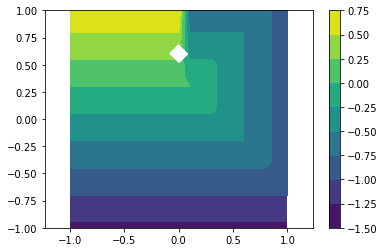

In [622]:
fmm.grid.plot(fmm.T)
plt.axis('equal')

### 圆裂纹

In [623]:
grid=GridHex(np.linspace(-1,1,101),np.linspace(-1,1,101))
exact=np.sqrt(grid.X**2+grid.Y**2)-0.5
accept=exact<=0.15
T=np.where(accept,exact,np.infty)
status=np.where(accept,1,-1)
fmm=FastMarching(grid,T,status=status)


In [624]:
fmm.loop(vstop=0.3)

(-1.0, 1.0, -1.0, 1.0)

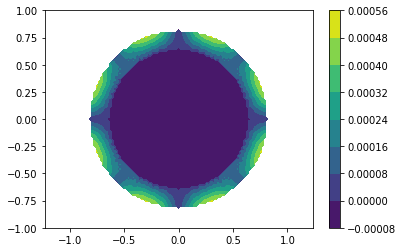

In [625]:
fmm.grid.plot(fmm.T-exact)
plt.axis('equal')

### 折线裂纹

In [414]:
fmmlogger.handlers[0].setLevel(logging.WARN)

In [626]:
grid=GridHex(np.linspace(-1,1,101),np.linspace(-1,1,101))
phi,psi=np.where(grid.X<=-0.1,(grid.X+grid.Y+0.1)/np.sqrt(2),grid.Y),grid.X
accept=np.abs(phi)<0.2
fmm=FastMarching(grid,np.where(accept,phi,np.infty),
                 status=np.where(accept,1,-1))

C:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:149: RuntimeWarning: invalid value encountered in sqrt
2020-04-18 16:17:48,072 - FastMarching - WARNING - nan get in compute distance of index=(45, 39)
2020-04-18 16:17:48,074 - FastMarching - WARNING - nan get in compute distance of index=(45, 61)
2020-04-18 16:17:48,078 - FastMarching - WARNING - nan get in compute distance of index=(45, 39)
2020-04-18 16:17:48,081 - FastMarching - WARNING - nan get in compute distance of index=(45, 61)


In [627]:
%time fmm.loop(vstop=0.2)

C:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:149: RuntimeWarning: invalid value encountered in sqrt
2020-04-18 16:17:52,822 - FastMarching - WARNING - nan get in compute distance of index=(46, 61)
2020-04-18 16:17:52,824 - FastMarching - WARNING - nan get in compute distance of index=(46, 61)
2020-04-18 16:17:52,829 - FastMarching - WARNING - nan get in compute distance of index=(46, 61)
2020-04-18 16:17:52,832 - FastMarching - WARNING - nan get in compute distance of index=(46, 61)
2020-04-18 16:17:52,838 - FastMarching - WARNING - nan get in compute distance of index=(45, 39)
2020-04-18 16:17:52,841 - FastMarching - WARNING - nan get in compute distance of index=(45, 39)


Wall time: 24 ms


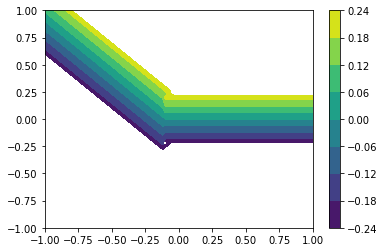

In [628]:
grid.plot(fmm.T)